In [7]:
#This assignment will use MNIST data to build an active learning model
#We will use the entire MNIST data set, with an 80/20 split for training and testing


#references
1#ttps://en.wikipedia.org/wiki/Active_learning_(machine_learning)


1

In [8]:
#1. import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

from graphviz import Digraph

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

from sklearn.datasets import fetch_openml

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor


from IPython.display import Image

from datetime import datetime

In [9]:
#homework framework
#check data path
data_path = '/../data/mnist/'


mnist_data_file = 'mnist_full_784.npy'
mnist_labels_file = 'mnist_full_labels_784.npy'


if os.path.exists(os.getcwd() + data_path + mnist_data_file):
    X = np.load(os.getcwd() + data_path + mnist_data_file, allow_pickle=True)

if os.path.exists(os.getcwd() + data_path + mnist_labels_file):
    y = np.load(os.getcwd() + data_path + mnist_labels_file, allow_pickle=True)

#define report location
report_folder = '/report/'
report_images = report_folder + 'resources/images/'

#check if the folder exists
if not os.path.exists(report_image_path := os.getcwd() + report_images):
    os.makedirs(os.getcwd() + report_images)
    
if not os.path.exists(os.getcwd() + report_images):
    print(f'{report_image_path} could not be created')
    exit()

print(f'Using {report_image_path} for report images.')


Using /Users/kjensen/Documents/GitHub/csc730/assignment 8/report/resources/images/ for report images.


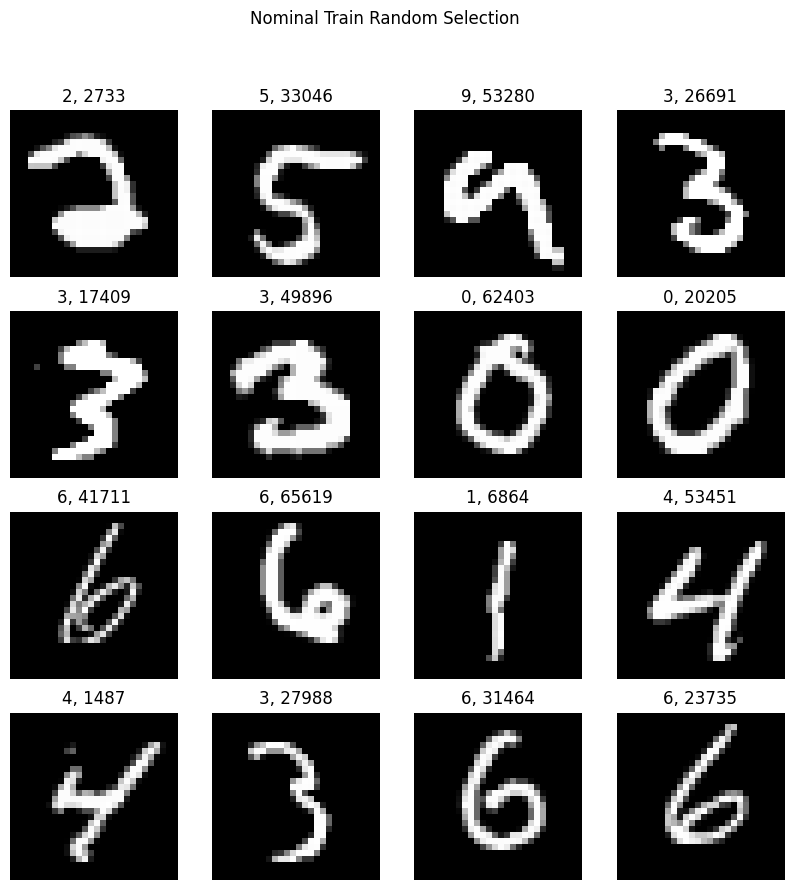

In [10]:
#generate example data figures
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = np.random.randint(0, X.shape[0])
        ax[i, j].imshow(X[index].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f'{y[index]}, {index}')
        ax[i, j].axis('off')
plt.suptitle('Nominal Train Random Selection')        
plt.savefig(report_image_path + '_nominal_train_random_selection.png')
plt.show()

The active learning algorithm has the following psuedocode  

Input: Dl, Du, h  
Output: h  

Psuedocode from paper
1) Train h using Dl
2) While stopping conditions not met Do  
    1) For each instance Xi in Du  
        1) ui = u(Xi, h)  
    1) End for  
    1) i* = argmax(ui, i)
    2) x* = xi*
    3) y* = query(x*)
    4) Dl = Dl union (x*, y*)
    5) Du = Du subtract x*
    6) Update h based on new Dl
9) End while

My interpretation
utility_value(x) returns the utility value of point x

1) confusion_matrices = []
1) stopping_condition = (accuracy(X_test) >= threshold) or (max_iterations >= iteration_threshold)
1) Dl = empty list
2) Dl.append(choose_first_point(X,y))
2) model = active_learn.fit(Dl)
2) confusion_matrices.append(model)
3) stopping_condition = (accuracy(X_test) >= threshold) or (max_iterations >= iteration_threshold)
3) while not stopping_condition
    3) utility_scores = [utility_value(x) for x in Du]
    3) best_utility_index = argmax(utility_scores)
    4) Dl.append(X_train[best_utility_index], y_train[best_utility_index])
    4) Du.remove(X_train[best_utility_index], y_train[best_utility_index])
    5) model = active_learn.fit(Dl)
    5) confusion_matrices.append(model)
    6) stopping_condition = (accuracy(X_test) >= threshold) or (max_iterations >= iteration_threshold)    
4) Generate graphs

@article{tharwat2023survey,
  title={A survey on active learning: state-of-the-art, practical challenges and research directions},
  author={Tharwat, Alaa and Schenck, Wolfram},
  journal={Mathematics},
  volume={11},
  number={4},
  pages={820},
  year={2023},
  publisher={MDPI},
  url={https://doi.org/10.3390/math11040820}
}

<https://doi.org/10.3390/math11040820>

In [11]:

class active_model_learning():
    def __init__(self, model, accuracy_threshold=0.95, max_iterations=1000, verbose=True, random_state=42, strategy_function=None,  test_split=0.2):
        self.model = model
        self.strategy_function = strategy_function
        
        self._test_split = test_split
        self._random_state = random_state                  
        
        self.confusion_matrices = []
        self.calculable_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": [], "roc_auc": [], "pr_auc": []}
        self.accuracy_threshold = accuracy_threshold
        self.accuracy_threshold_reached = False
        self.max_iterations = max_iterations
        self.current_iteration = 0
        self.verbose = verbose
        self.X_test = None
        self.y_test = None
        self._next_index=0
        
        
        
        
    def _select_point_from_pool(self):
        #place X[index] and y[index] into Dl_X and Dl_y
        if self.Dl_X.shape[0] == 0:
            self.Dl_X = self.Du_X[self._next_index].reshape(1, -1)
            self.Dl_y = np.array([self.Du_y[self._next_index]])
        else:        
            self.Dl_X = np.append(self.Dl_X,self.Du_X[self._next_index].reshape(1, -1), axis=0)
            self.Dl_y = np.append(self.Dl_y, [self.Du_y[self._next_index]], axis=0)
        
        #remove X[index] and y[index] from Du_X and Du_y
        self.Du_X = np.delete(self.Du_X, self._next_index, axis=0)
        self.Du_y = np.delete(self.Du_y, self._next_index, axis=0)
    
    def _train_model(self):
        if self.verbose:
            print(f"Training model on {len(self.Dl_X)} points. Iteration {self.current_iteration} at {datetime.now()}")
            start_time = datetime.now()
            
        try:
            self.model.fit(self.Dl_X, self.Dl_y)
        except ValueError as e:
            print(f"Error: {e}")
            print(f"Model: {self.model}")
            print(f"X: {self.Dl_X}")
            print(f"y: {self.Dl_y}")
            #add data point to the model and continue
            self._next_index = np.random.randint(0, self.Du_X.shape[0])
            self._select_point_from_pool()
        
        if self.verbose:
            print(f"Training time: {datetime.now() - start_time}")
        
    def test_model(self, X, y):
        y_pred = self.model.predict(X)
        self.confusion_matrices.append(confusion_matrix(y, y_pred))
        
        if self.verbose:
            print(f"Confusion matrix for iteration {self.current_iteration}: {self.confusion_matrices[-1]}")
            
    def _test_model(self):            
        self.test_model(self.X_test, self.y_test)        
        
    def evaluate_model(self, X, y):
        self.test_model(X, y)
        
        fp = (self.confusion_matrices[-1].sum(axis=0) - np.diag(self.confusion_matrices[-1]))
        fn = (self.confusion_matrices[-1].sum(axis=1) - np.diag(self.confusion_matrices[-1]))
        tp = np.diag(self.confusion_matrices[-1])
        tn = self.confusion_matrices[-1].sum() - (fn + tp + fn)
        
        accuracy = (tp + tn) / (tp + tn + fn + fp)
        self.calculable_metrics["accuracy"].append(accuracy)
        self.calculable_metrics["precision"].append(tp / (tp + fp))
        self.calculable_metrics["recall"].append(tp / (tp + fn))
        self.calculable_metrics["f1"].append(2 * (self.calculable_metrics["precision"][-1] * self.calculable_metrics["recall"][-1]) / (self.calculable_metrics["precision"][-1] + self.calculable_metrics["recall"][-1]))
        #self.calculable_metrics["roc_auc"].append(roc_auc_score(y, self.model.predict_proba(X)))
        #self.calculable_metrics["pr_auc"].append(auc(*precision_recall_curve(y, self.model.predict_proba(X))[:2]))        
        
        if self.verbose:
            print(f"Accuracy for iteration {self.current_iteration}: {accuracy}")
            
        if accuracy.min() >= self.accuracy_threshold:
            self.accuracy_threshold_reached = True
            if self.verbose:
                print(f"Accuracy threshold reached at iteration {self.current_iteration}")
        return accuracy

    def _evaluate_model(self):
        return self.evaluate_model(self.X_test, self.y_test)
        
    def utility_function(self, X):
        #return the point with the highest uncertainty
        if self.strategy_function is None:
            #check if the model has a predict_proba method
            if not hasattr(self.model, "predict_proba"):
                array = np.zeros(X.shape[0])
                array[np.random.randint(0, X.shape[0])] = 1
                return array                
                
            return self.model.predict_proba(X)
        else:
            return self.strategy_function(self, X)
    
    def utility_function_index(self, X):
        #return the point with the highest uncertainty
        return np.argmax(self.utility_function(X))
    
    def _utility_function_index(self):
        #return the point with the highest uncertainty
        self._next_index = np.argmax(self.utility_function(self.Du_X))
        
        if self._next_index >= self.Du_X.shape[0]:
            if self.verbose:
                print(f"Index out of range: {self._next_index}")
            self._next_index = np.random.randint(0, self.Du_X.shape[0])
            
        if self.verbose:
            print(f"Selected index {self._next_index} for iteration {self.current_iteration}")
        return self._next_index
    
    def _run_next(self):
        self.current_iteration += 1
        if self.accuracy_threshold_reached:
            return False
        if self.current_iteration >= self.max_iterations:
            return False
        return True
    
    def report(self):
        print(f"Final accuracy: {self.evaluate_model(self.X_test, self.y_test)}")
        print(f"Final confusion matrix: {self.confusion_matrices[-1]}")
        print(f"Final iteration: {self.current_iteration}")
        print(f"Final accuracy threshold reached: {self.accuracy_threshold_reached}")
    
    def generate_graphs(self):
        #add 5 confusion matrices images into the main plot as insets
        figs = []
        axes = []
        
        fig, ax = plt.subplots(1, 5, figsize=(20, 4))
        figs.append(fig)
        axes.append(ax)
        indices_to_plot = np.linspace(1, len(self.confusion_matrices), 5).astype(int)
                
        for i in range(5):
            ax[i].imshow(self.confusion_matrices[indices_to_plot[i]-1], cmap='binary')
            ax[i].set_title(f"Confusion matrix {indices_to_plot[i]}")
        fig.suptitle(f"Confusion matrices for {self.model.__class__.__name__}", fontsize=24)
        
        fig.show()      
        
        fig, ax = plt.subplots(figsize=(20, 20))
        figs.append(fig)
        axes.append(ax)
        ax.plot(self.calculable_metrics["accuracy"], label=np.unique(self.Du_y))
        ax.set_title(f"Accuracy over iterations {self.model.__class__.__name__}\nStrategy: {self.strategy_function.__name__} ", fontsize=24)
        ax.set_xlabel("Iteration", fontsize=18)
        ax.set_ylabel("Accuracy", fontsize=18)  
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.legend(prop={'size': 14})                  
        plt.show()
        
        fig, ax = plt.subplots(figsize=(20, 20))
        figs.append(fig)
        axes.append(ax)
        ax.plot(np.average(np.array(self.calculable_metrics["accuracy"]),axis=1), label="Average accuracy")
        ax.plot(np.amin(np.array(self.calculable_metrics["accuracy"]),axis=1), label="Minimum accuracy")
        ax.plot(np.amax(np.array(self.calculable_metrics["accuracy"]),axis=1), label="Maximum accuracy")
        ax.set_title(f"Average accuracy over iterations {self.model.__class__.__name__}\nStrategy: {self.strategy_function.__name__}", fontsize=24)
        ax.set_xlabel("Iteration", fontsize=18)
        ax.set_ylabel("Accuracy", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_ylim([0, 1])
        ax.set_xlim([0, self.current_iteration])    
        
        
        ax.legend(prop={'size': 14})
        
        #add confusion matrix images into the main plot as insets
        #MARK: add confusion matrix images into the main plot as insets
        for i in range(5):
            #ax_inset = fig.add_axes([indices_to_plot[i]-1, indices_to_plot[i]+self.current_iteration/5, 0.4, 0.4 ])
            
            height_new_plot = 0.125
            width_new_plot = 0.125
            y_range = fig.axes[0].get_ylim()[1] - fig.axes[0].get_ylim()[0]            
            x_range = fig.axes[0].get_xlim()[1] - fig.axes[0].get_xlim()[0]
            
            y_point = np.average(np.array(self.calculable_metrics["accuracy"]),axis=1)[indices_to_plot[i]-1]
            x_point = indices_to_plot[i] - 1
                                    
            left_position =  0.02+(i/6.5)
            bottom_position = 0.25#(y_relative - height_new_plot) if y_relative < 0.5 else (y_relative + height_new_plot)
                        
            ax_inset = fig.add_axes([left_position+width_new_plot, bottom_position,width_new_plot,height_new_plot ],alpha=0.5)
            
            ax_inset.imshow(self.confusion_matrices[indices_to_plot[i]-1], cmap='binary')
            ax_inset.set_xticks(np.arange(0.5, 10.5, 1))
            ax_inset.set_yticks(np.arange(0.5, 10.5, 1))
            ax_inset.set_xticklabels(np.arange(0, 10, 1))
            ax_inset.set_yticklabels(np.arange(0, 10, 1))
            ax_inset.grid(True)
            #now draw a line to the data point
            
            #ax.plot([indices_to_plot[i]-1, indices_to_plot[i]-1], [bottom_position, np.average(np.array(self.calculable_metrics["accuracy"]),axis=1)[indices_to_plot[i]-1]], color='black', linestyle='--')
            
            ax_inset.set_title(f"Confusion matrix {indices_to_plot[i]}", fontsize=18)           
            #ax_inset.set_title(f"{left_position:0.2f}, {bottom_position:0.2f}, {width_new_plot:0.2f}, {height_new_plot:0.2f}")
        plt.show()
        
        return figs, axes
    
    
    def fit(self, X, y):
         
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=self._test_split, random_state=self._random_state)           
                        
        self.Du_X = np.array(self.X_train); self.Du_y = np.array(self.y_train); self.Du = (self.Du_X, self.Du_y)
        #match the shape of the data, except for the index column which will be 1
        #shape = list(X.shape); shape[0] = 1; shape = tuple(shape)
        self.Dl_X = np.array([]); self.Dl_y = np.array([]); self.Dl = (self.Dl_X, self.Dl_y) 
        
        #select a point from the pool at random
        self._next_index = np.random.randint(0, self.Du_X.shape[0])
        self._select_point_from_pool()                     
        
        self._next_index = np.random.randint(0, self.Du_X.shape[0])
        self._select_point_from_pool()
        self._train_model()               
        
        while self._run_next():   
            self._utility_function_index()
            self._select_point_from_pool()
            self._train_model()
            self._evaluate_model()
                        
        if self.verbose:
            print(f"Model training complete at iteration {self.current_iteration}")
            
        return self.accuracy_threshold_reached

def default_strategy(obj, X):
    return obj.model.predict_proba(X)

def random_strategy(obj, X):
    array = np.zeros(X.shape[0])
    array[np.random.randint(0, X.shape[0])] = 1
    return array    

def uncertainty_strategy(obj, X):
    return 1 - obj.model.predict_proba(X).max(axis=1)

def margin_strategy(obj, X):
    #return the difference between the two highest probabilities in each class    
    #this is not correct - its getting late
    return np.abs(obj.model.predict_proba(X).max(axis=1) - obj.model.predict_proba(X).min(axis=1))

def entropy_strategy(obj, X):
    return -np.sum(obj.model.predict_proba(X) * np.log(obj.model.predict_proba(X)), axis=1) 

def query_by_comittee_strategy(obj, X):
    #get the predictions from the model
    predictions = obj.model.predict(X)
    #get the unique predictions
    unique_predictions = np.unique(predictions)
    #get the number of unique predictions
    number_of_unique_predictions = unique_predictions.shape[0]
    #create an array to store the votes
    votes = np.zeros((X.shape[0], number_of_unique_predictions))
    #for each unique prediction
    for i, unique_prediction in enumerate(unique_predictions):
        #get the votes for the unique prediction
        votes[:, i] = predictions == unique_prediction
    #return the sum of the votes
    return votes.sum(axis=1)





/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7

Final accuracy: [0.97989523 0.9568859  0.96122226 0.95758611 0.95832136 0.95081486
 0.96687997 0.96647727 0.95497596 0.95138391]
Final confusion matrix: [[1264    1   11    4    2    3   44    2    8    4]
 [   0 1569    2    4    0    5    1    6   11    2]
 [  34  122  986   20   14    1  104   49   38   12]
 [  24   72   28 1161    3   47   21   39   30    8]
 [   4    9    4    2  963   10   61   13   17  212]
 [  75  111    3  159   68  749   49   15   22   22]
 [  26   30    6    0   33   21 1271    6    3    0]
 [  30   41   39    5   34    0    5 1307    6   36]
 [   2  169   31  106   16   46   54    6  911   16]
 [  10   42   15   24   78   13    7  140   37 1054]]
Final iteration: 232
Final accuracy threshold reached: True


/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:152: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


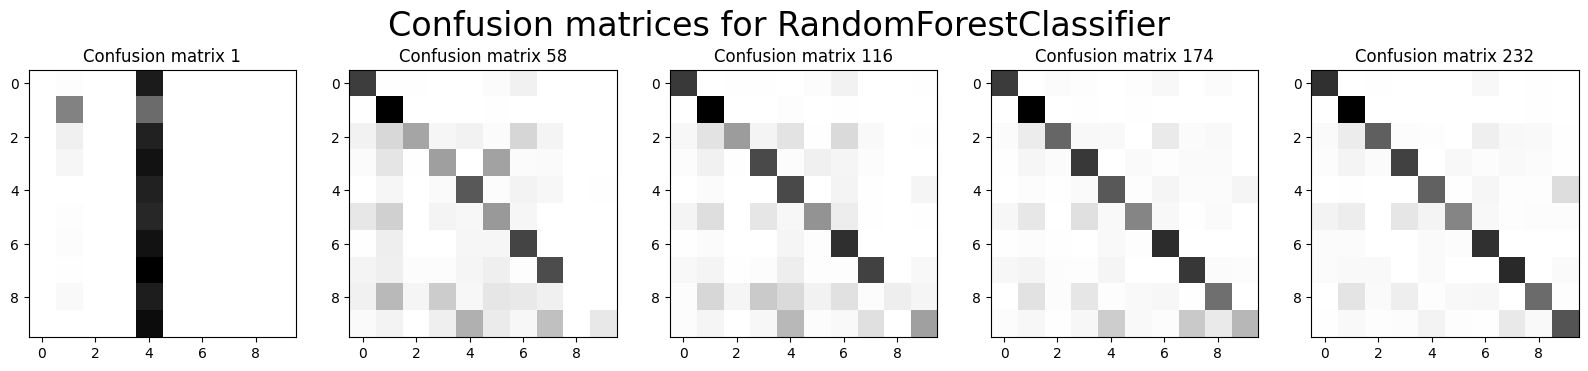

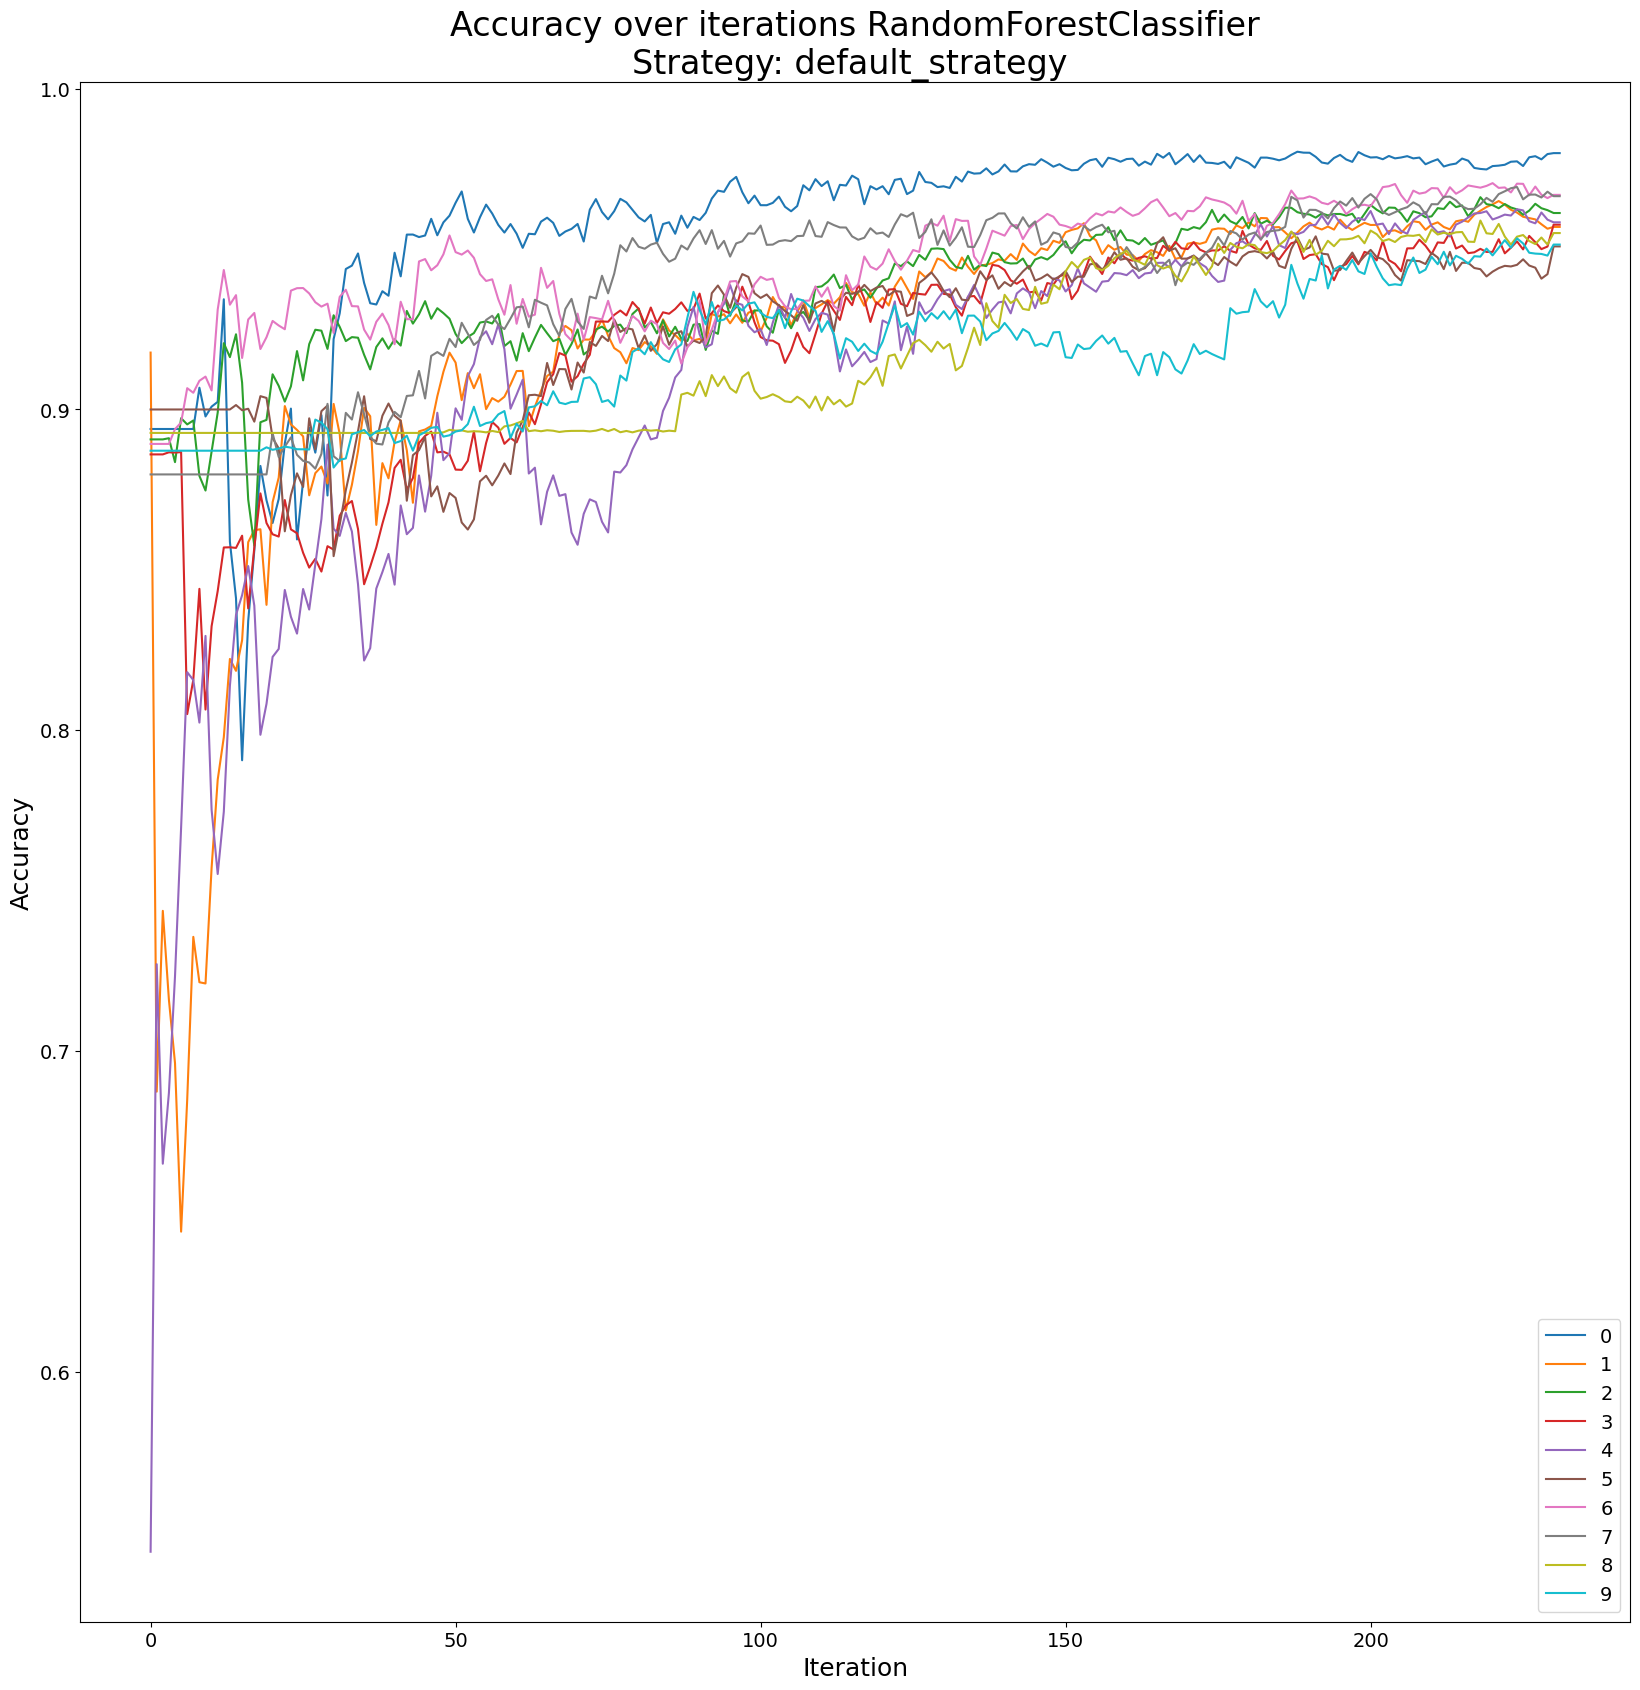

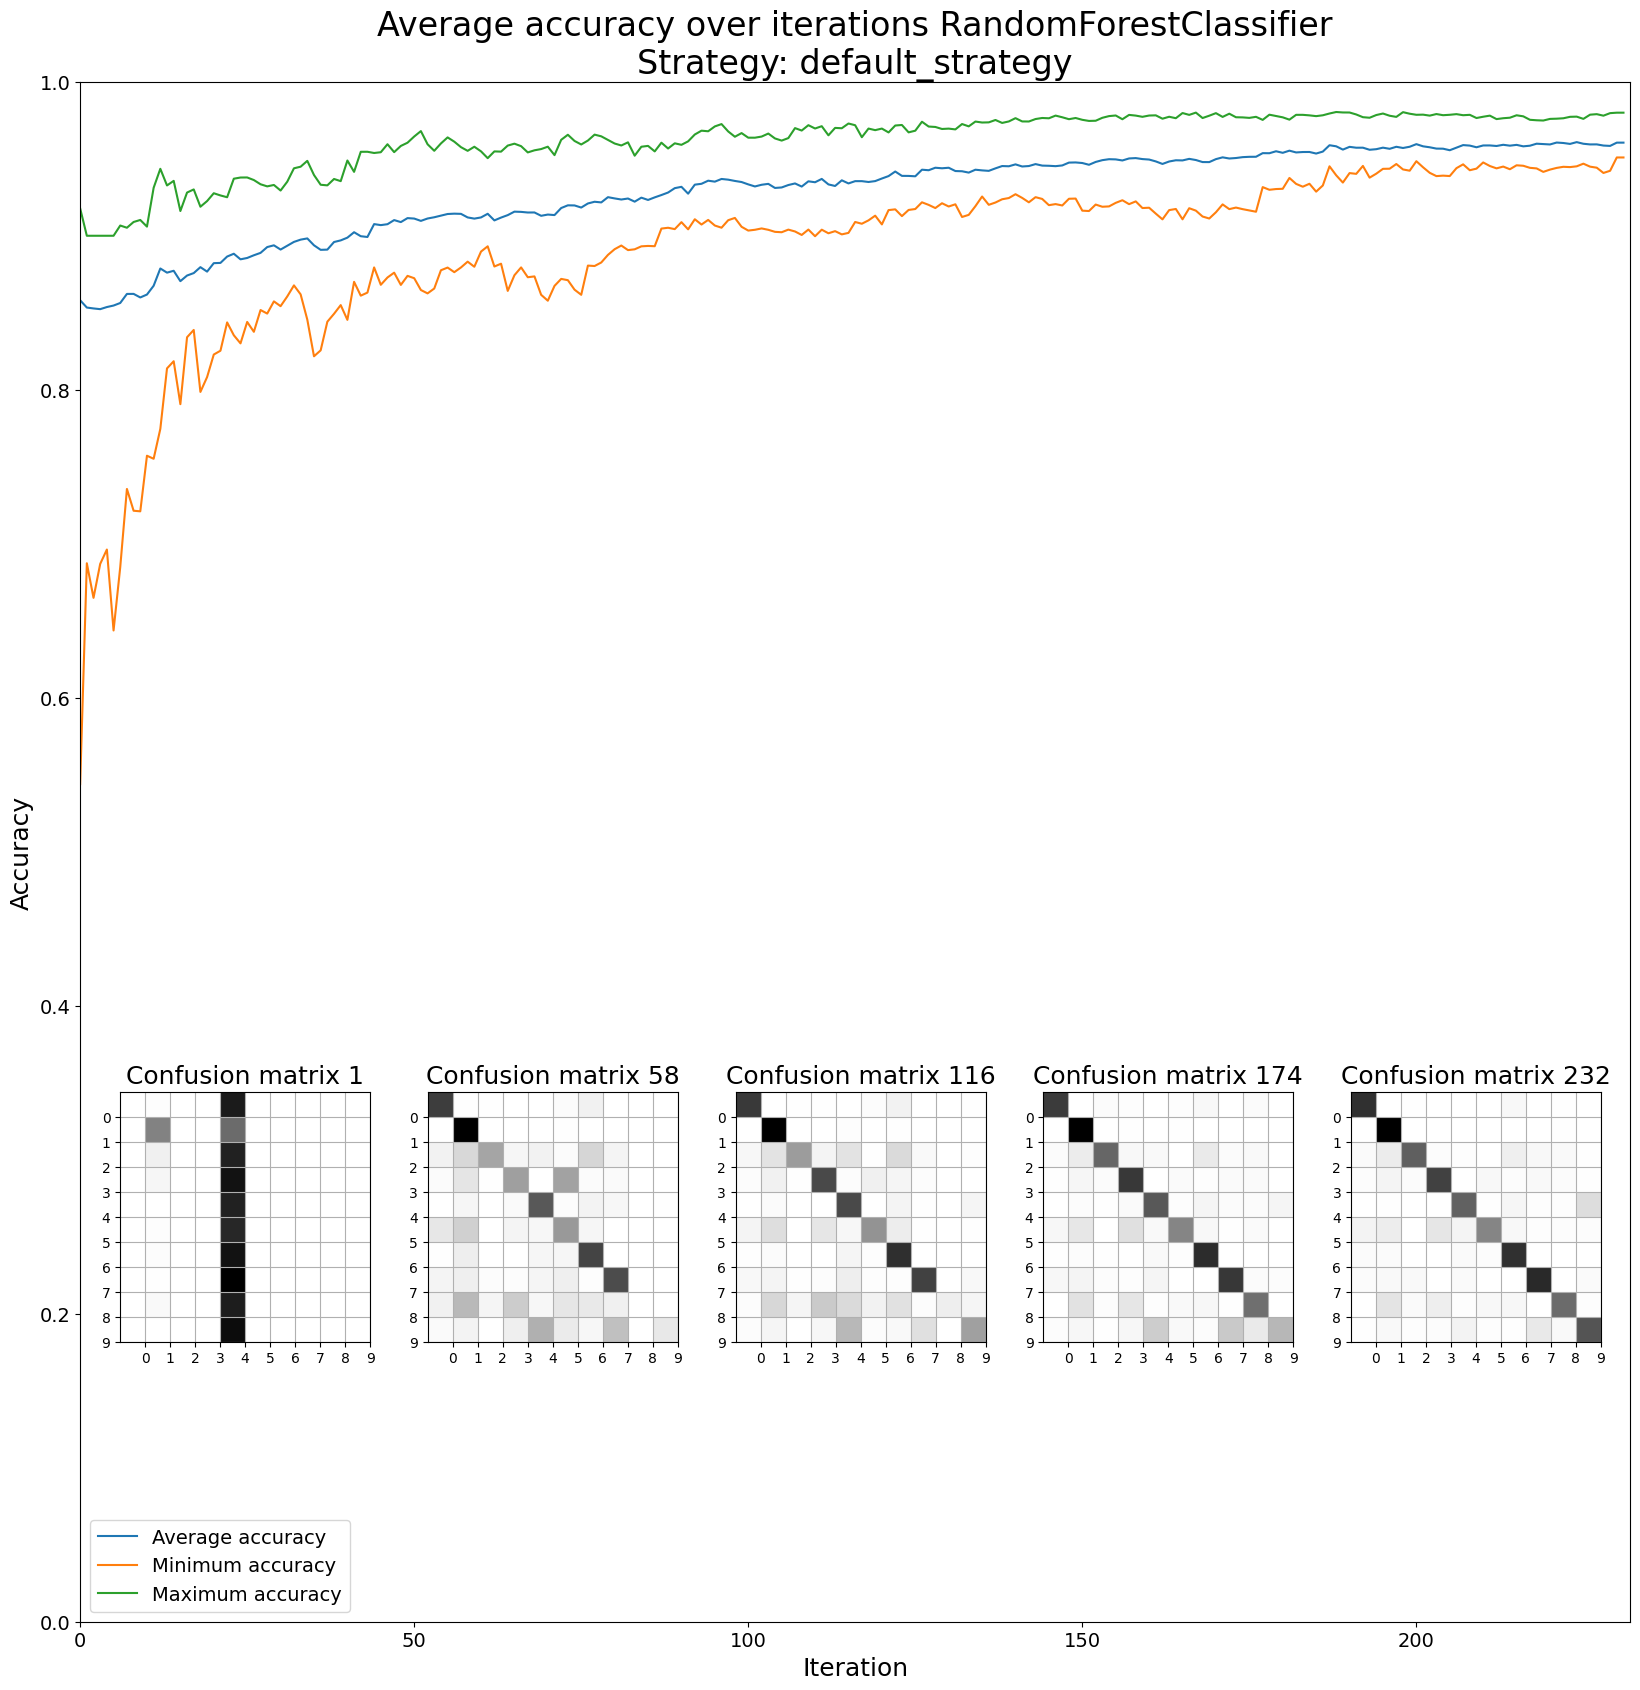

/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7

Final accuracy: [0.98737968 0.97082635 0.96544788 0.95018091 0.97210006 0.95509423
 0.97816281 0.96956677 0.96140964 0.95355863]
Final confusion matrix: [[1267    2    8    5    1    5   17    7   22    9]
 [   0 1555   15   10    0    5    4    6    2    3]
 [  24   70 1100   43   18    6   27   45   28   19]
 [   2   37   45 1261    0   23    7   21   14   23]
 [   2    8   11   12 1037    2   28    9   10  176]
 [  30   52    4  296   16  760   24    6   21   64]
 [  26   35   43   13   10   21 1227    5   15    1]
 [   8   54   25   10   15    3    0 1273    9  106]
 [   4   85   44  133   13   27   23   23  959   46]
 [   5   30    6   22   56    5    6   73   11 1206]]
Final iteration: 339
Final accuracy threshold reached: True


/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:152: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


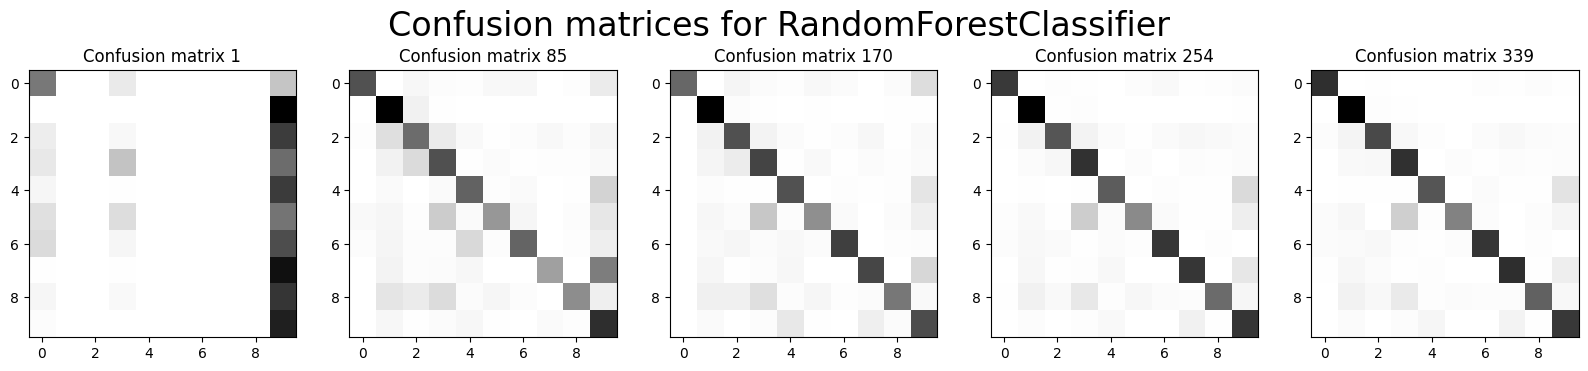

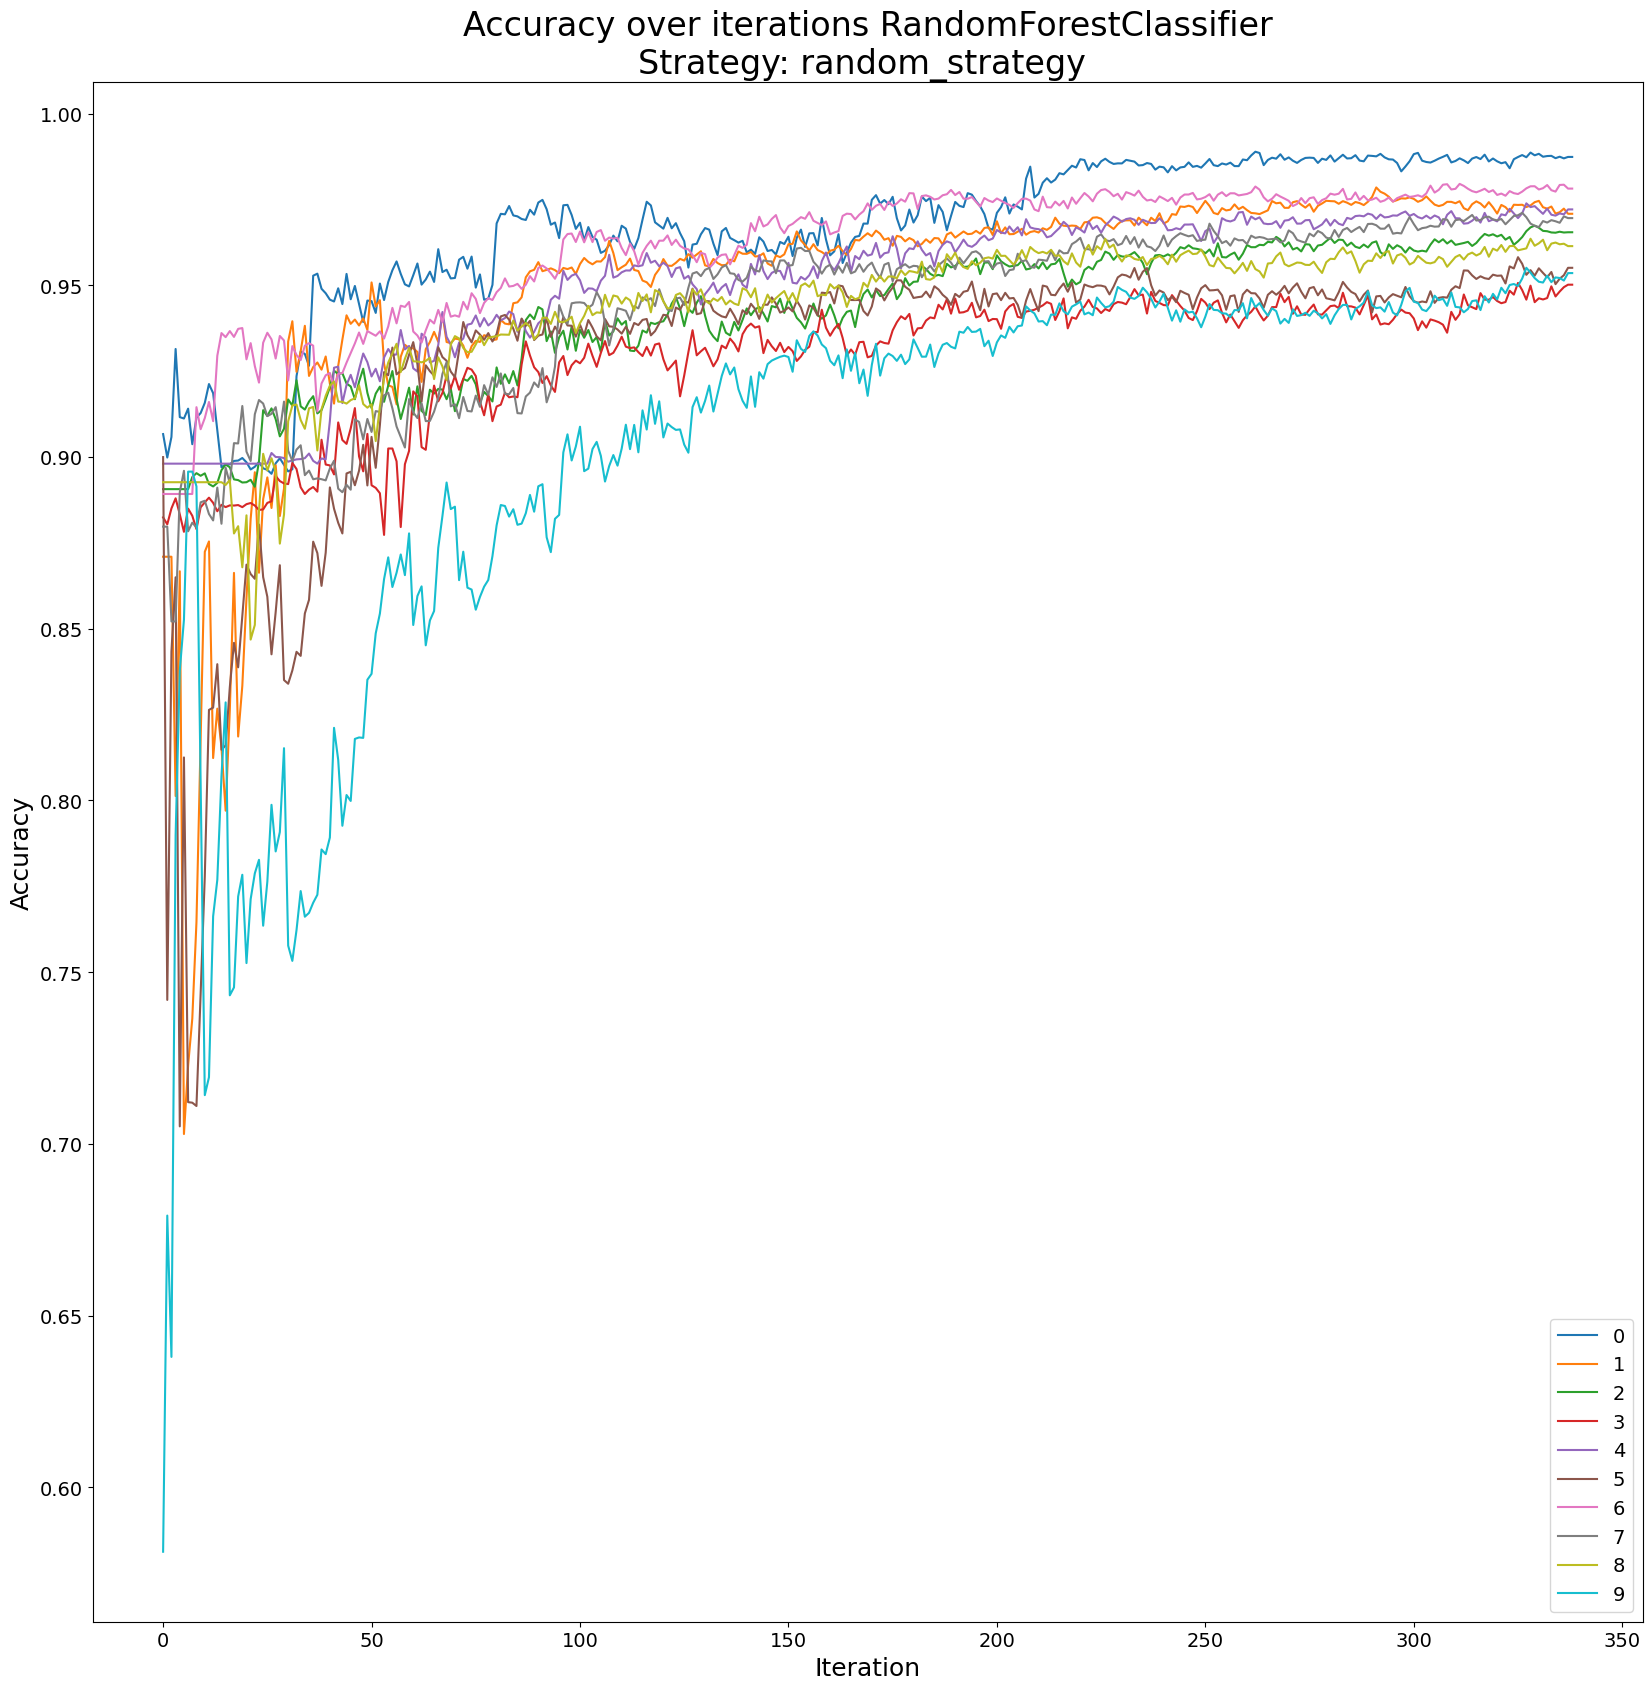

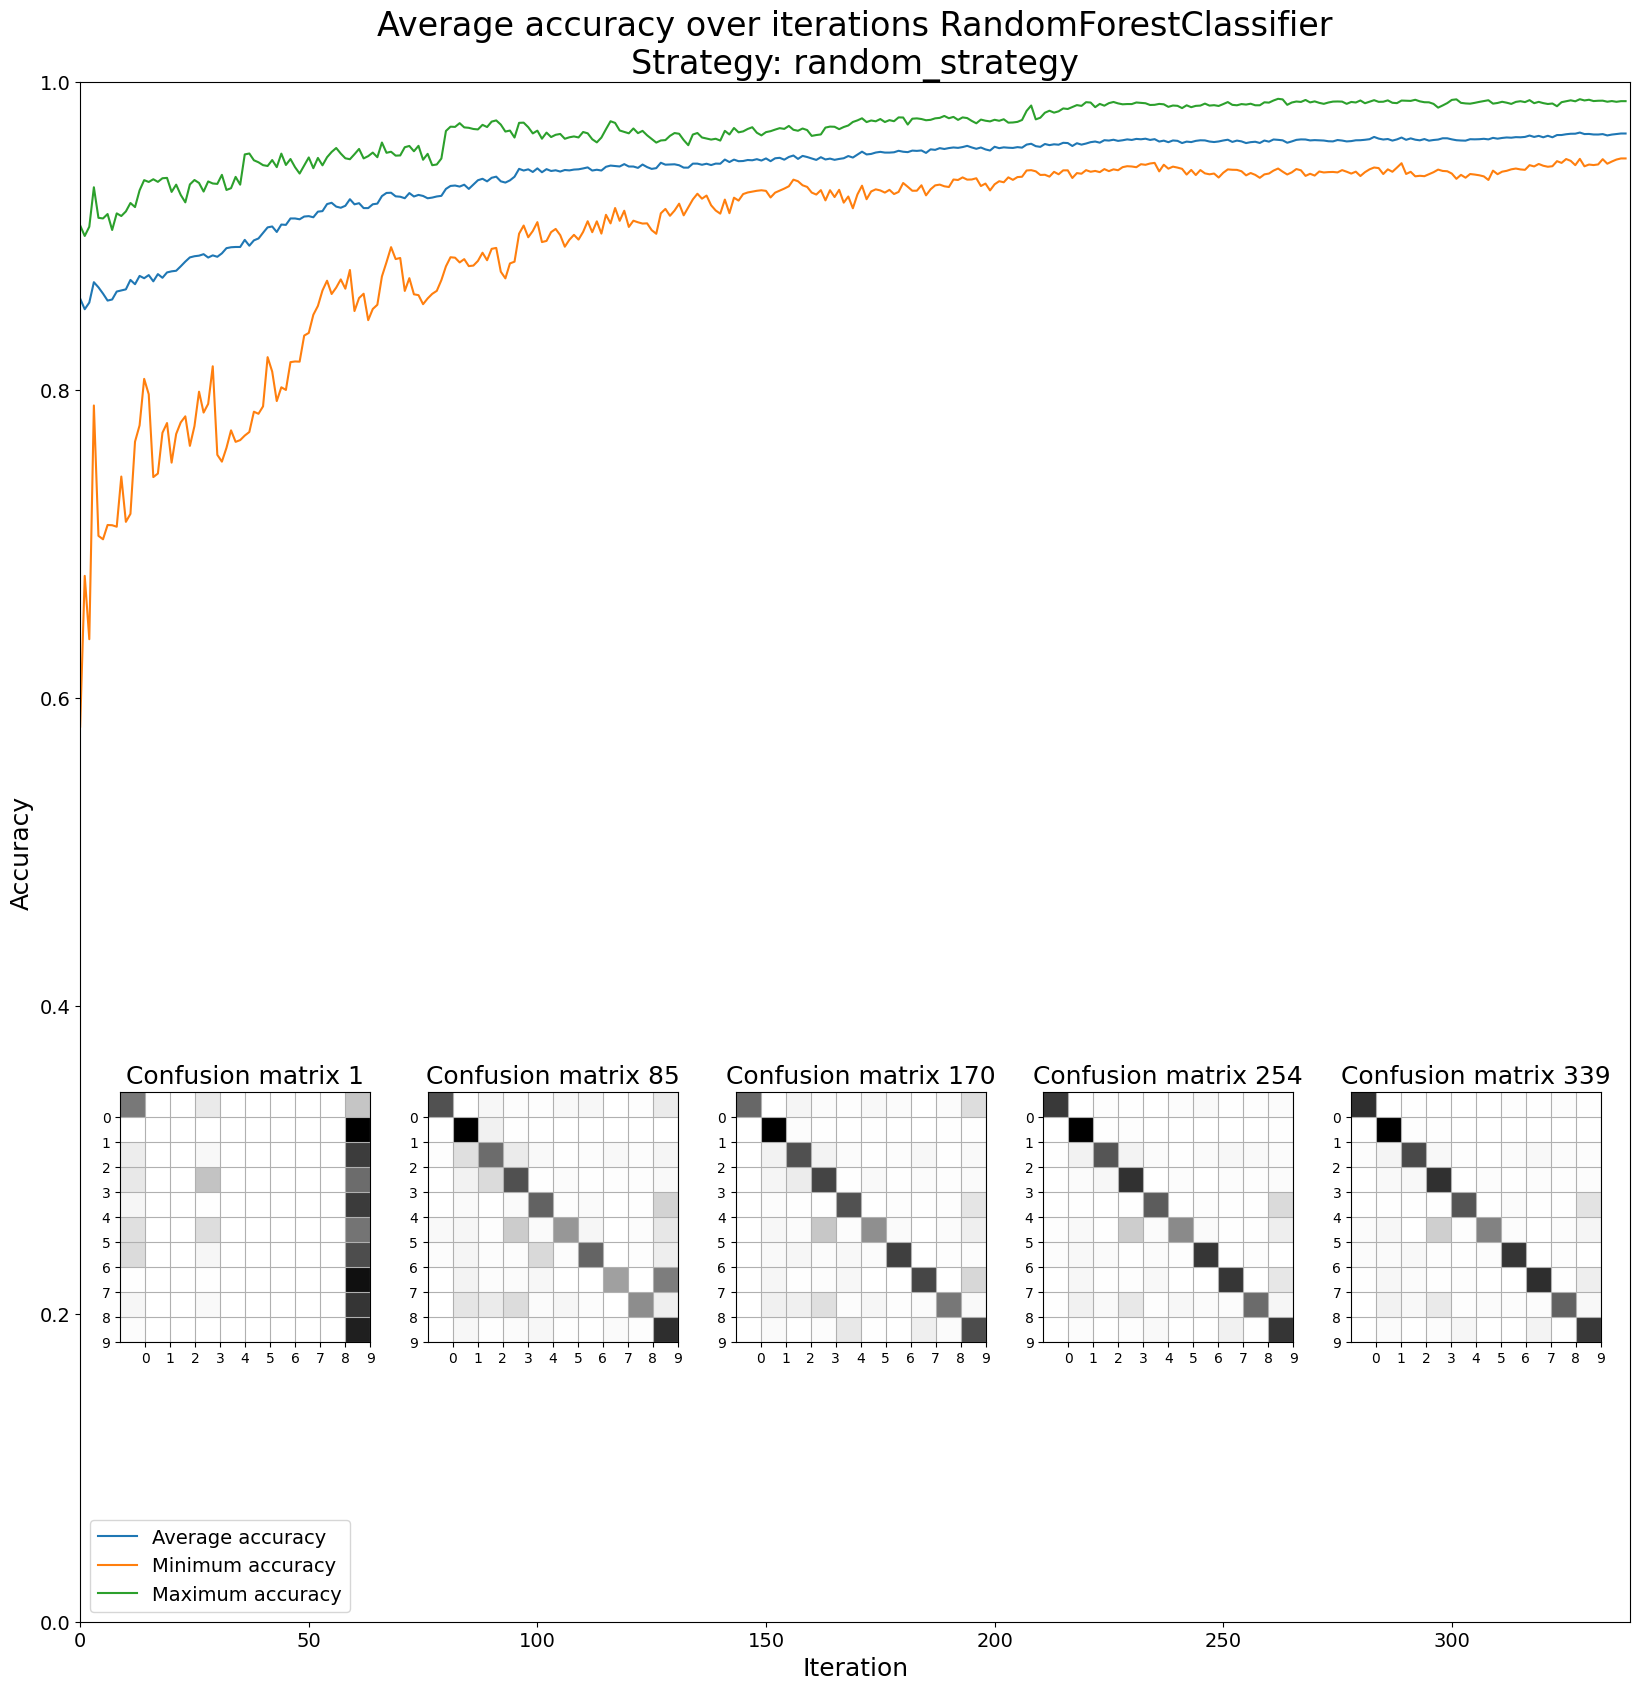

/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7

Final accuracy: [0.9896035  0.99096774 0.96941918 0.96072769 0.96329749 0.95786981
 0.98403107 0.97558509 0.95224933 0.95418664]
Final confusion matrix: [[1244    0   16    0    5   47   13    1   15    2]
 [   0 1512   10    8    3    3    3   10   50    1]
 [   4    6 1148   13   32    9   22   17  126    3]
 [  11    5   67 1087    0  119    2   12  119   11]
 [   1    1    6    8 1014    4    3    2   36  220]
 [  11    7   11  116   12  946   12    1  141   16]
 [   8    2   42    0   41   26 1236    2   36    3]
 [   2    5   21    2   34   16    0 1256   16  151]
 [   4    6   15   31    5   24    7    6 1247   12]
 [   5    6    7   20   99   12    0   40   42 1189]]
Final iteration: 557
Final accuracy threshold reached: True


/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:152: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


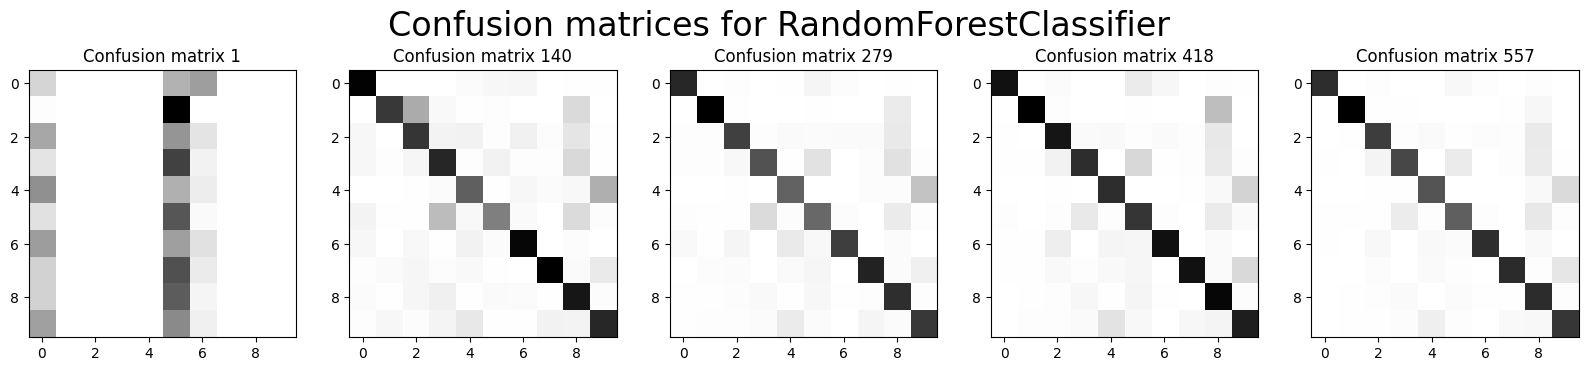

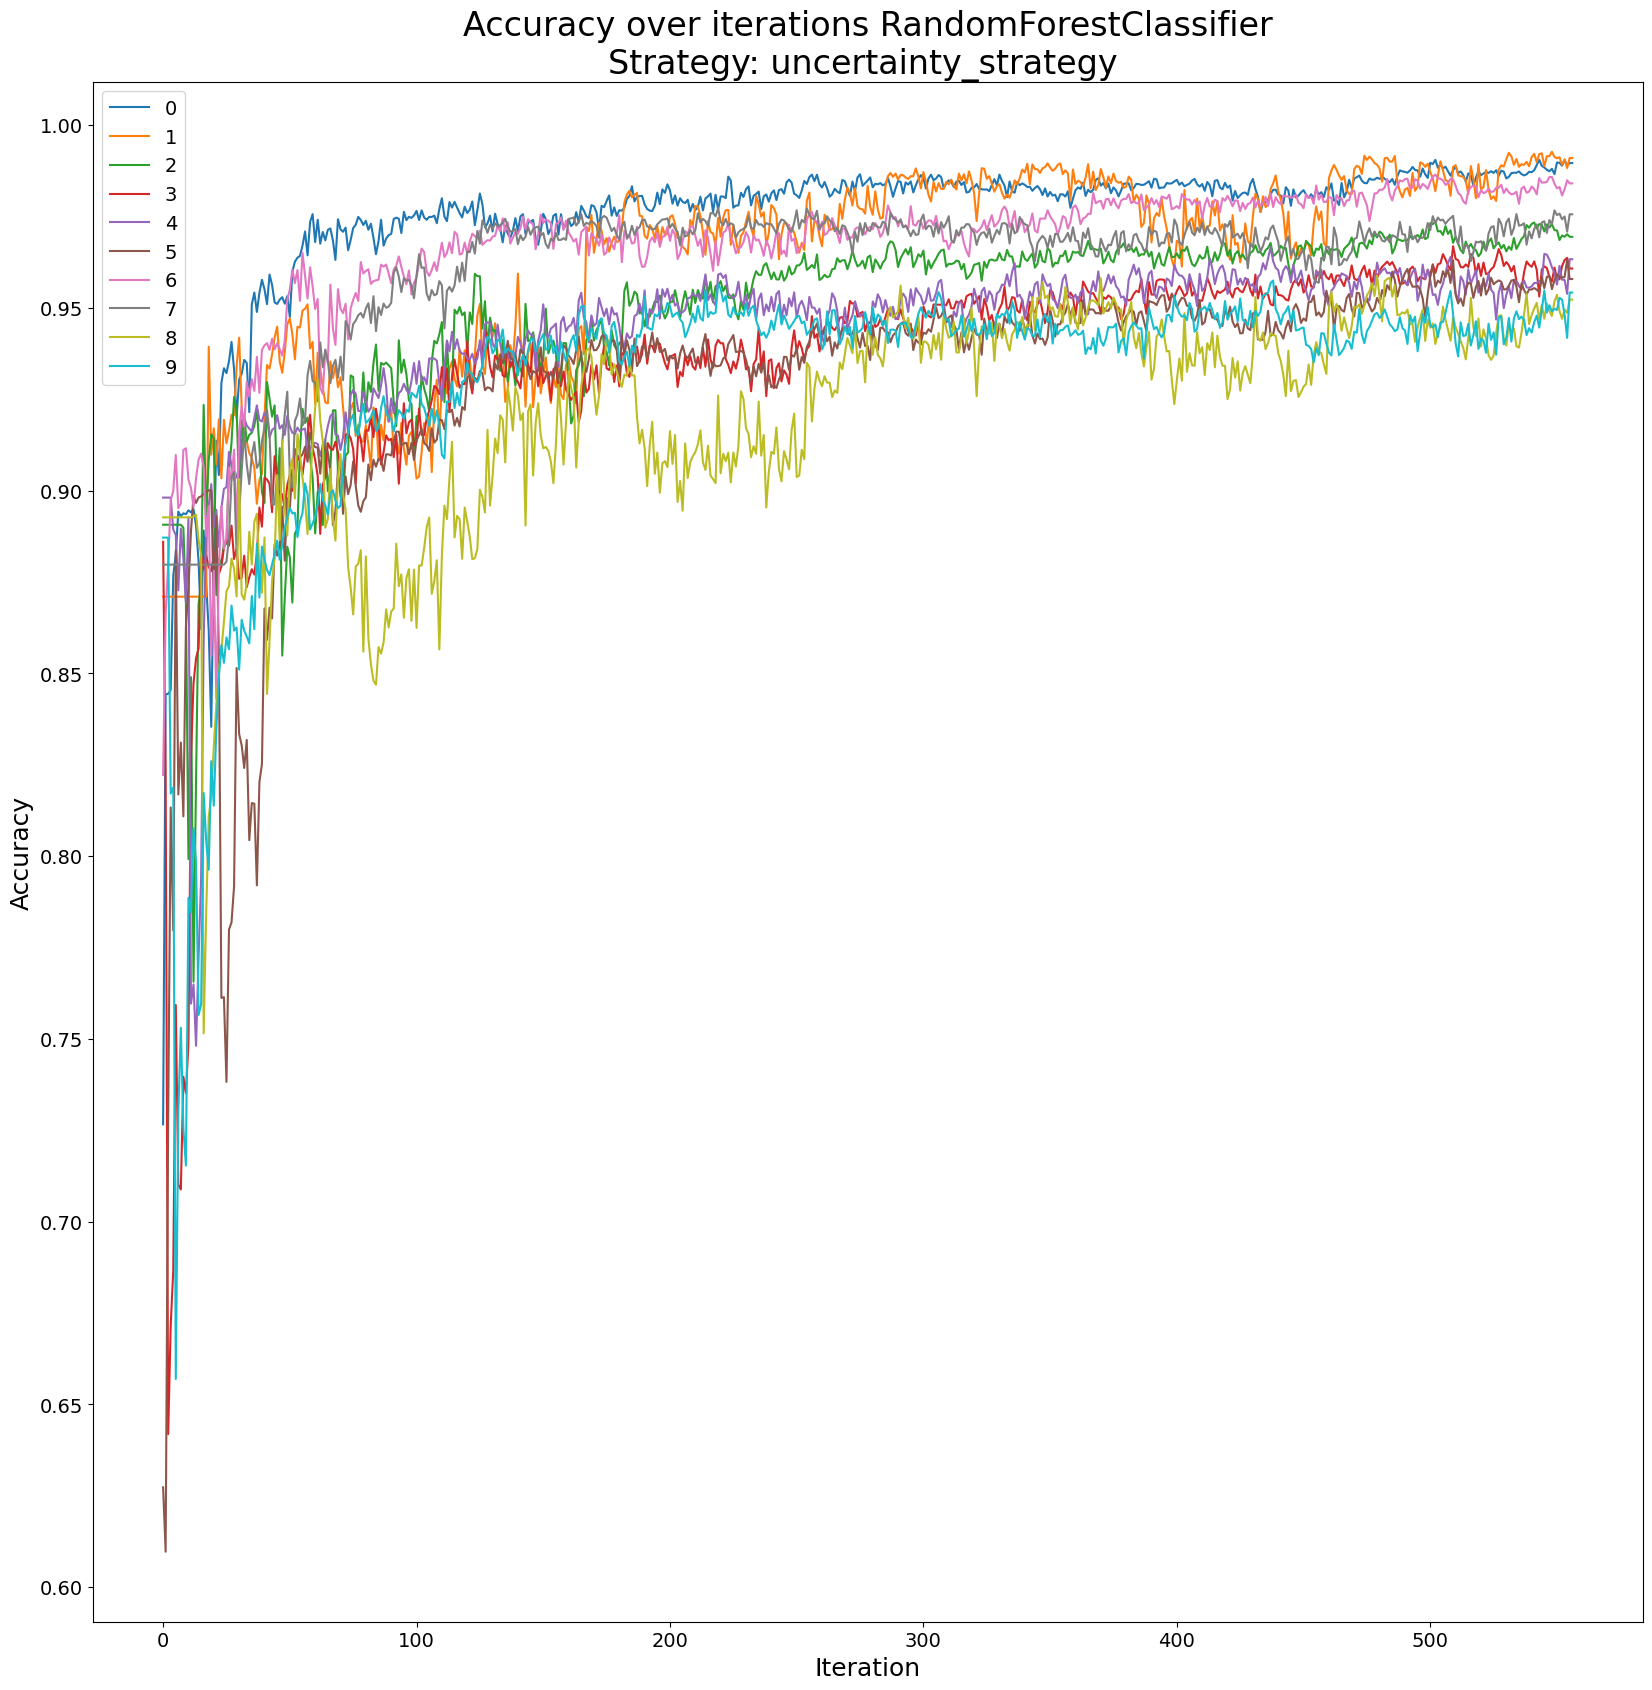

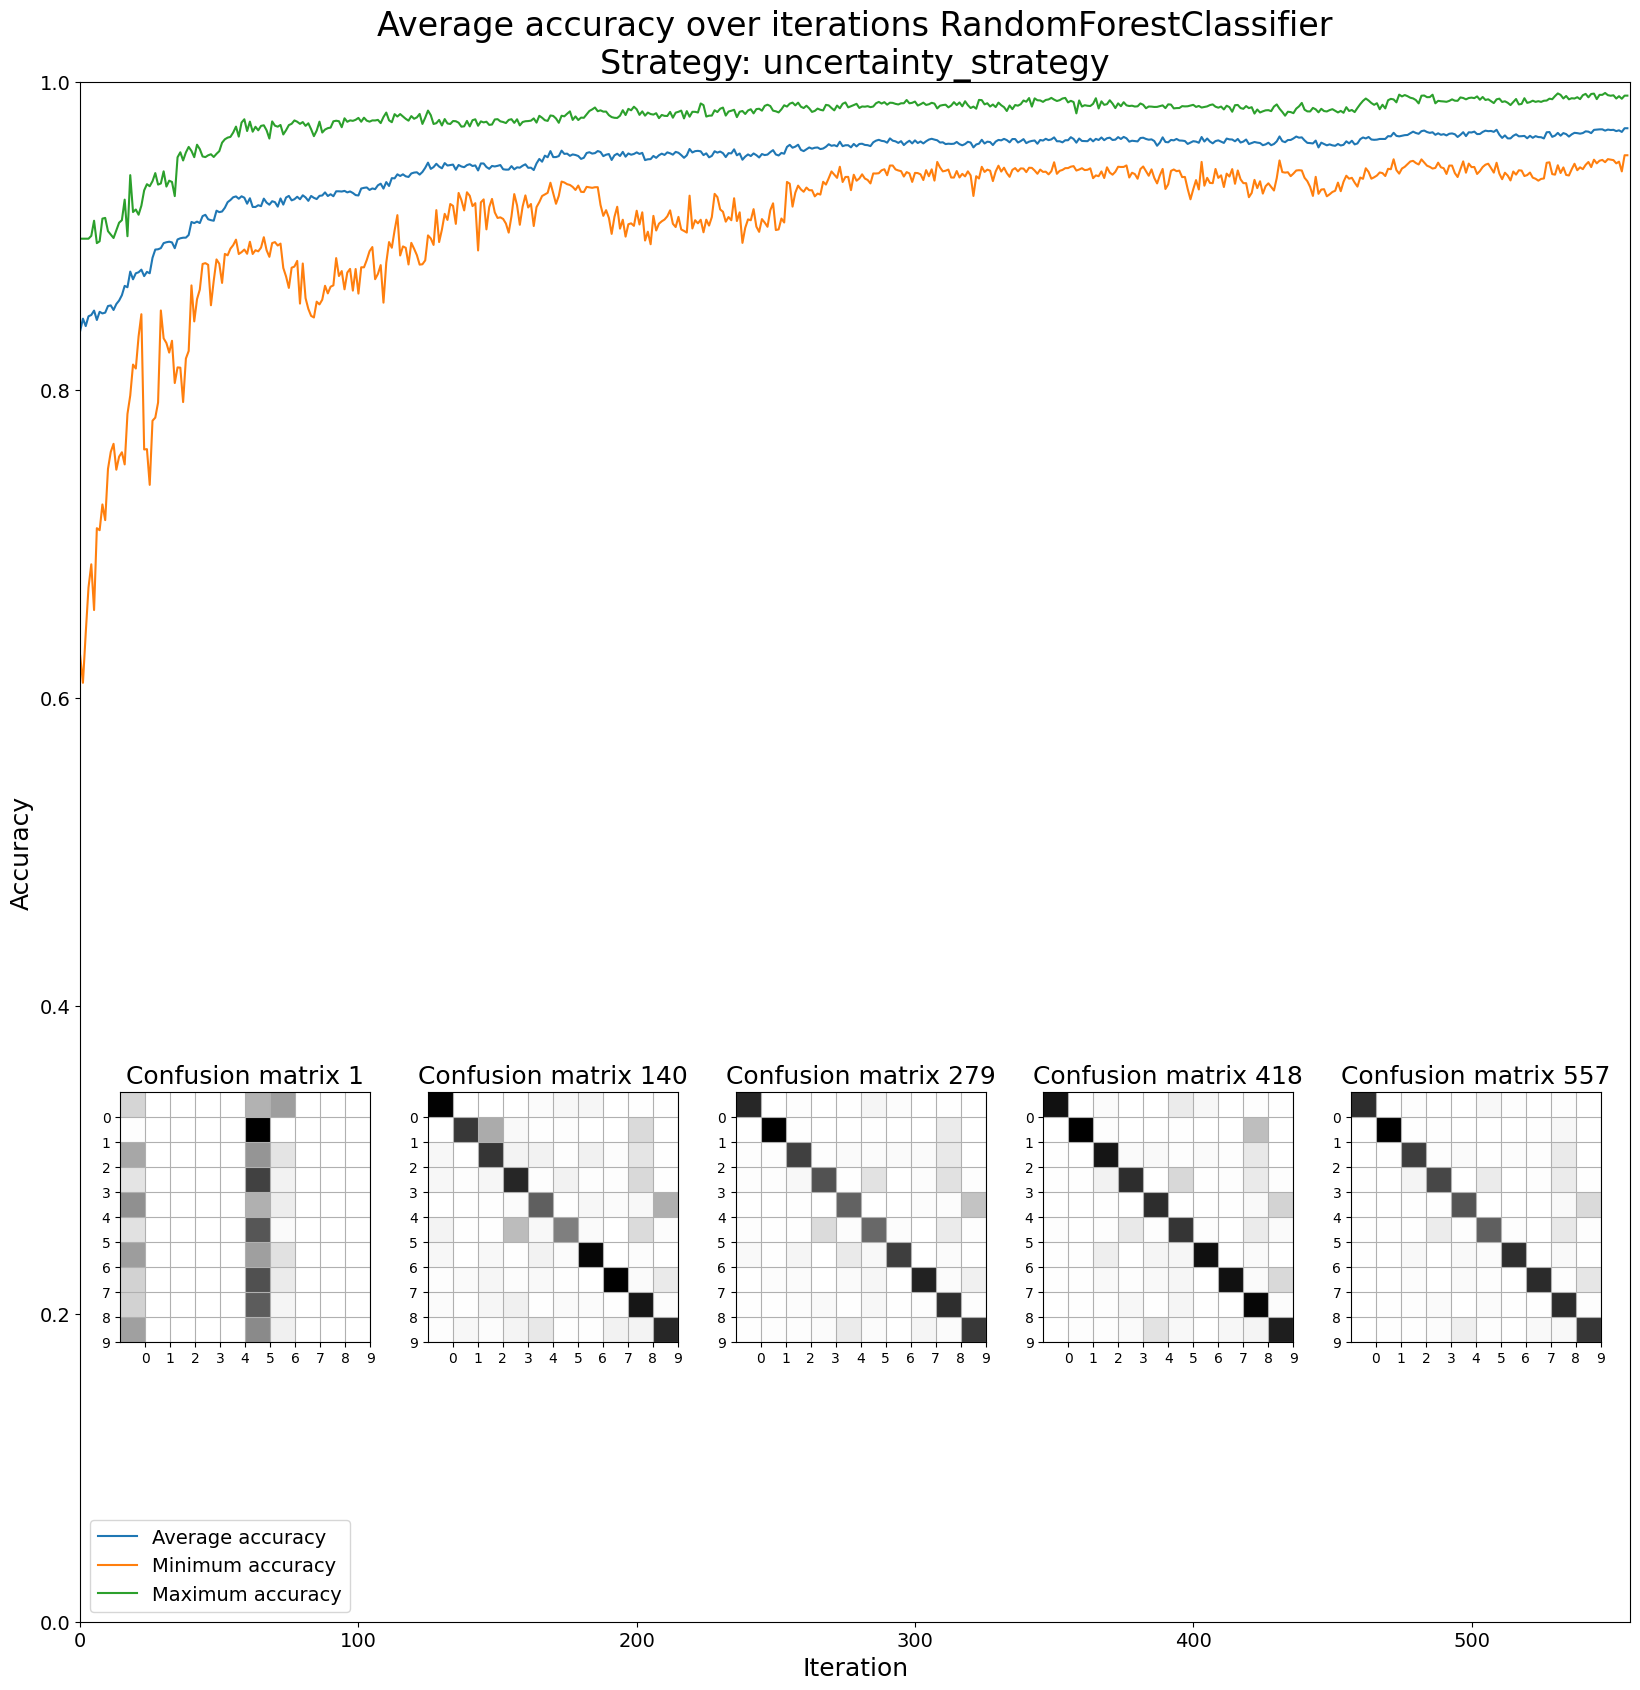

/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:261: RuntimeWarning: divide by zero encountered in log
  return -np.sum(obj.model.predict_proba(X) * np.log(obj.model.predict_proba(X)), axis=1

Final accuracy: [0.97628654 0.96448676 0.96029304 0.95166397 0.9621746  0.95148738
 0.96903307 0.96583434 0.95727744 0.95127744]
Final confusion matrix: [[1239    1    8    8    1    2   62    4   18    0]
 [   0 1539    2   24    0   11    1    8   14    1]
 [  52  106  934   56   19    1  117   53   31   11]
 [  12   35   38 1196    1   71   10   28   25   17]
 [  14   18    7   43  985    8   43   16    7  154]
 [  25  104    4  113   42  814   51   63   22   35]
 [  54   14    3   10    1   14 1296    3    0    1]
 [  35   49    9    8   17    5    3 1330    2   45]
 [  17   93   22  150   11   70   38   23  911   22]
 [  22   30    3   38  124   26   16  112   20 1029]]
Final iteration: 256
Final accuracy threshold reached: True


/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:152: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


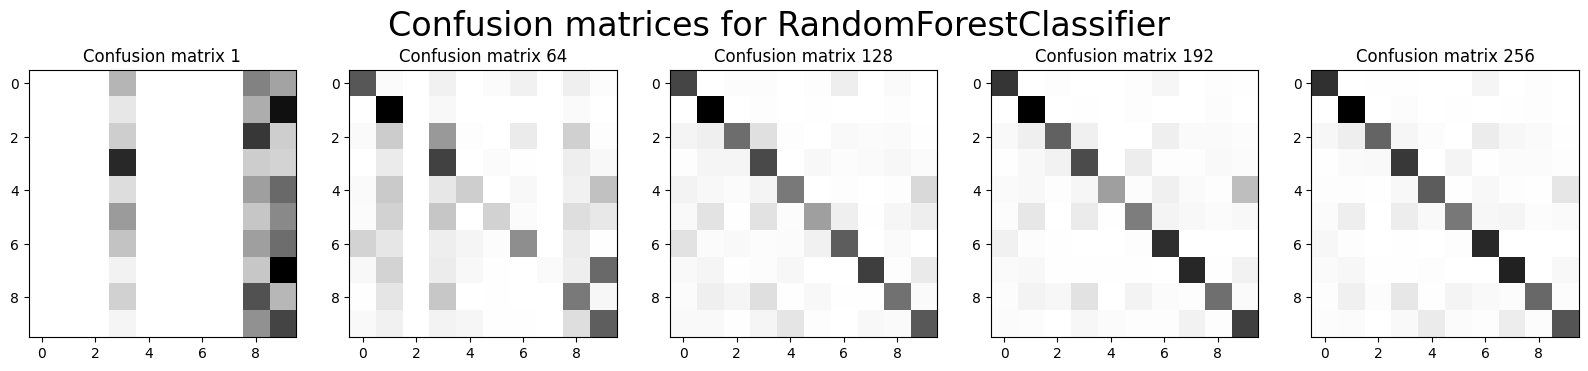

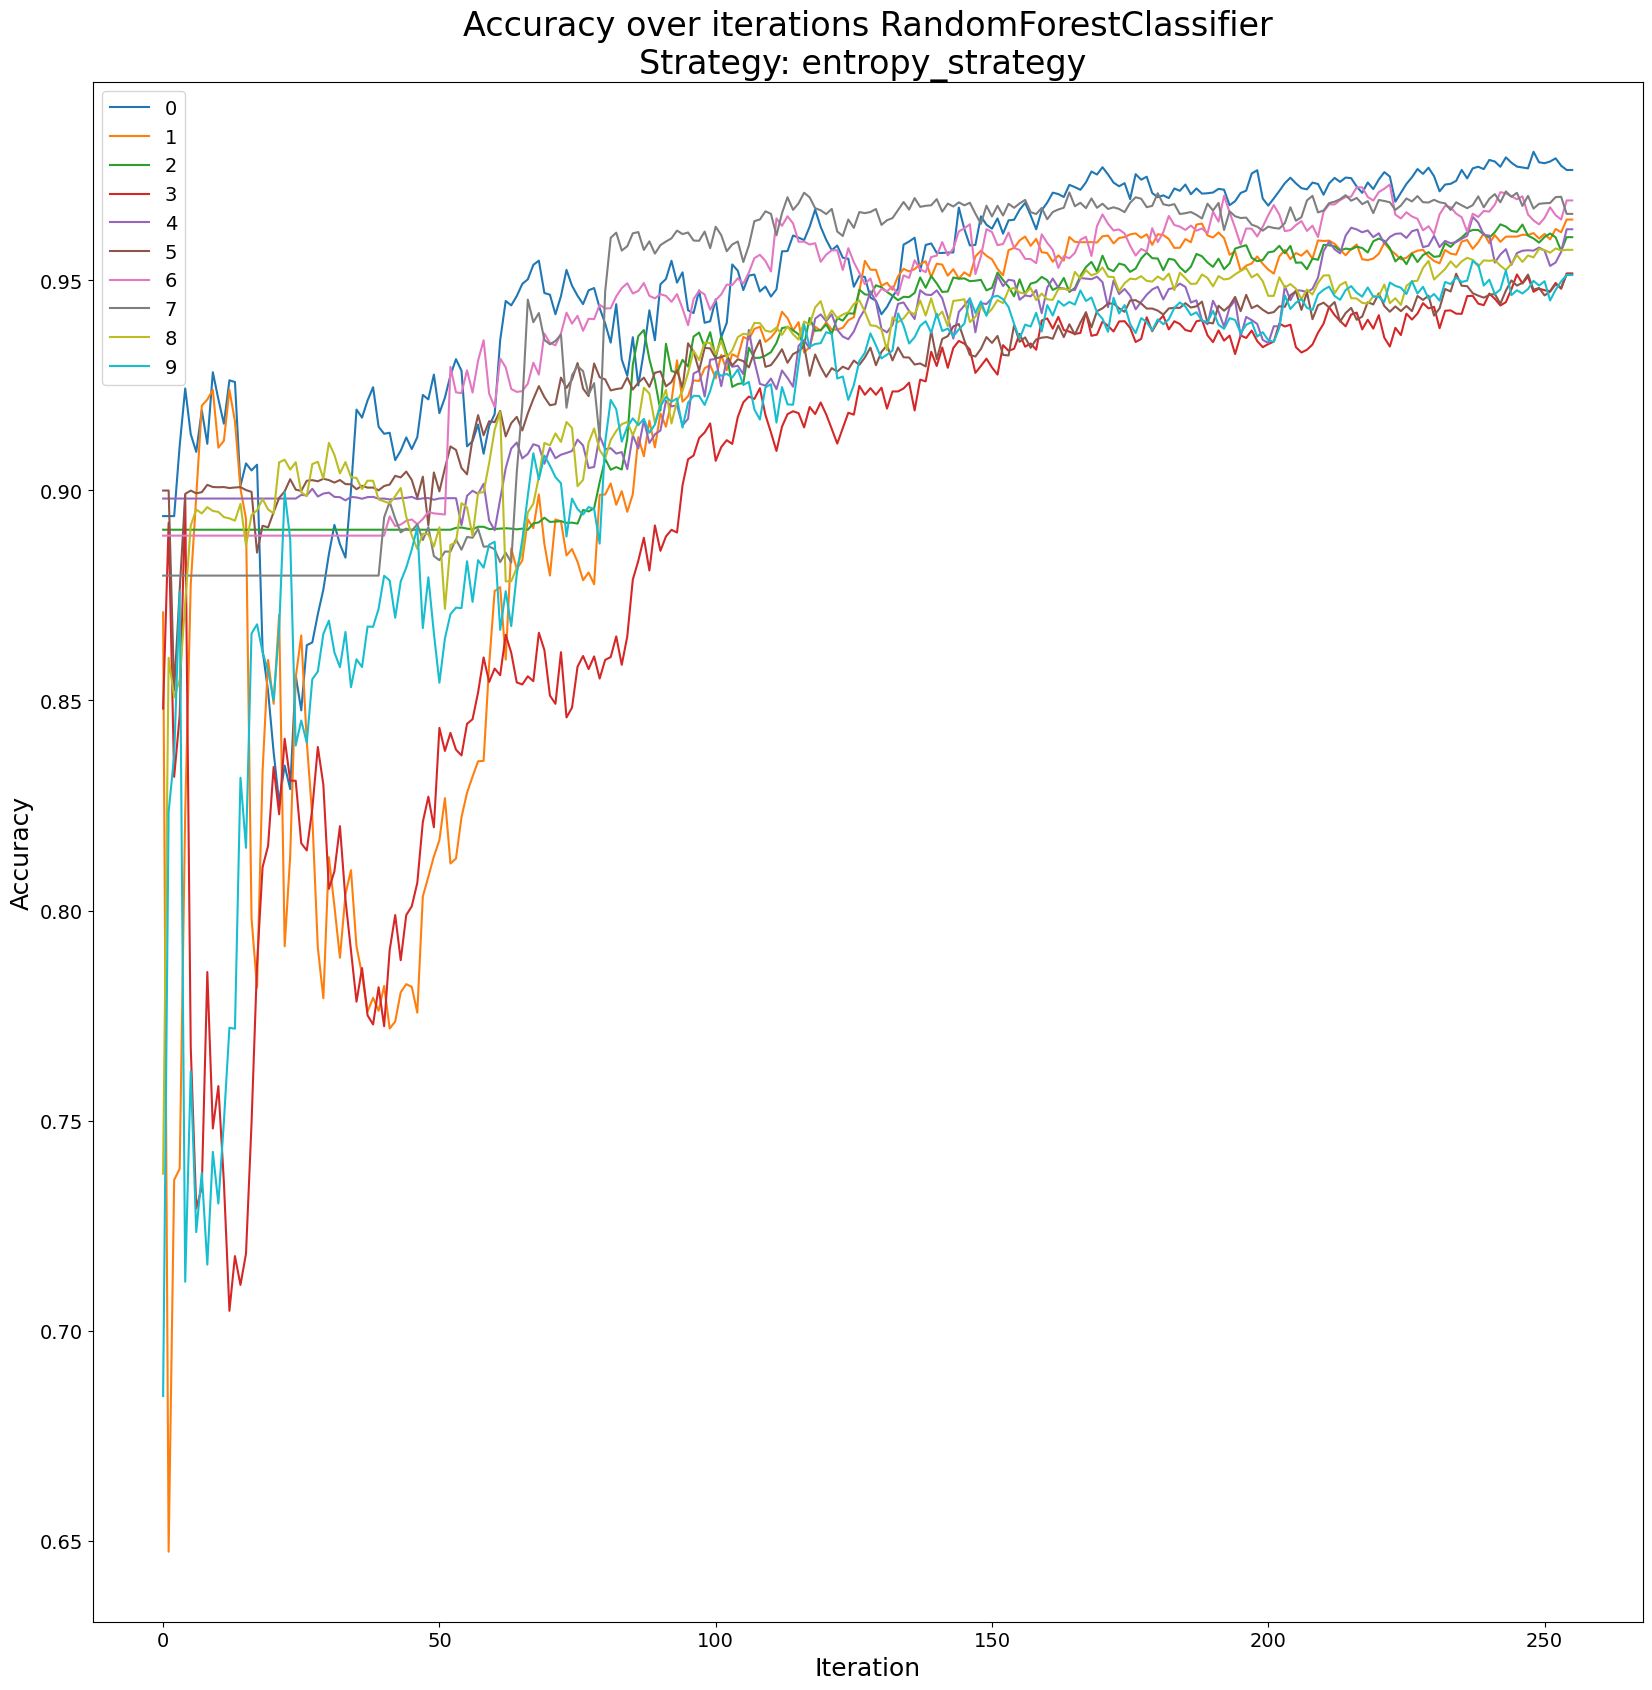

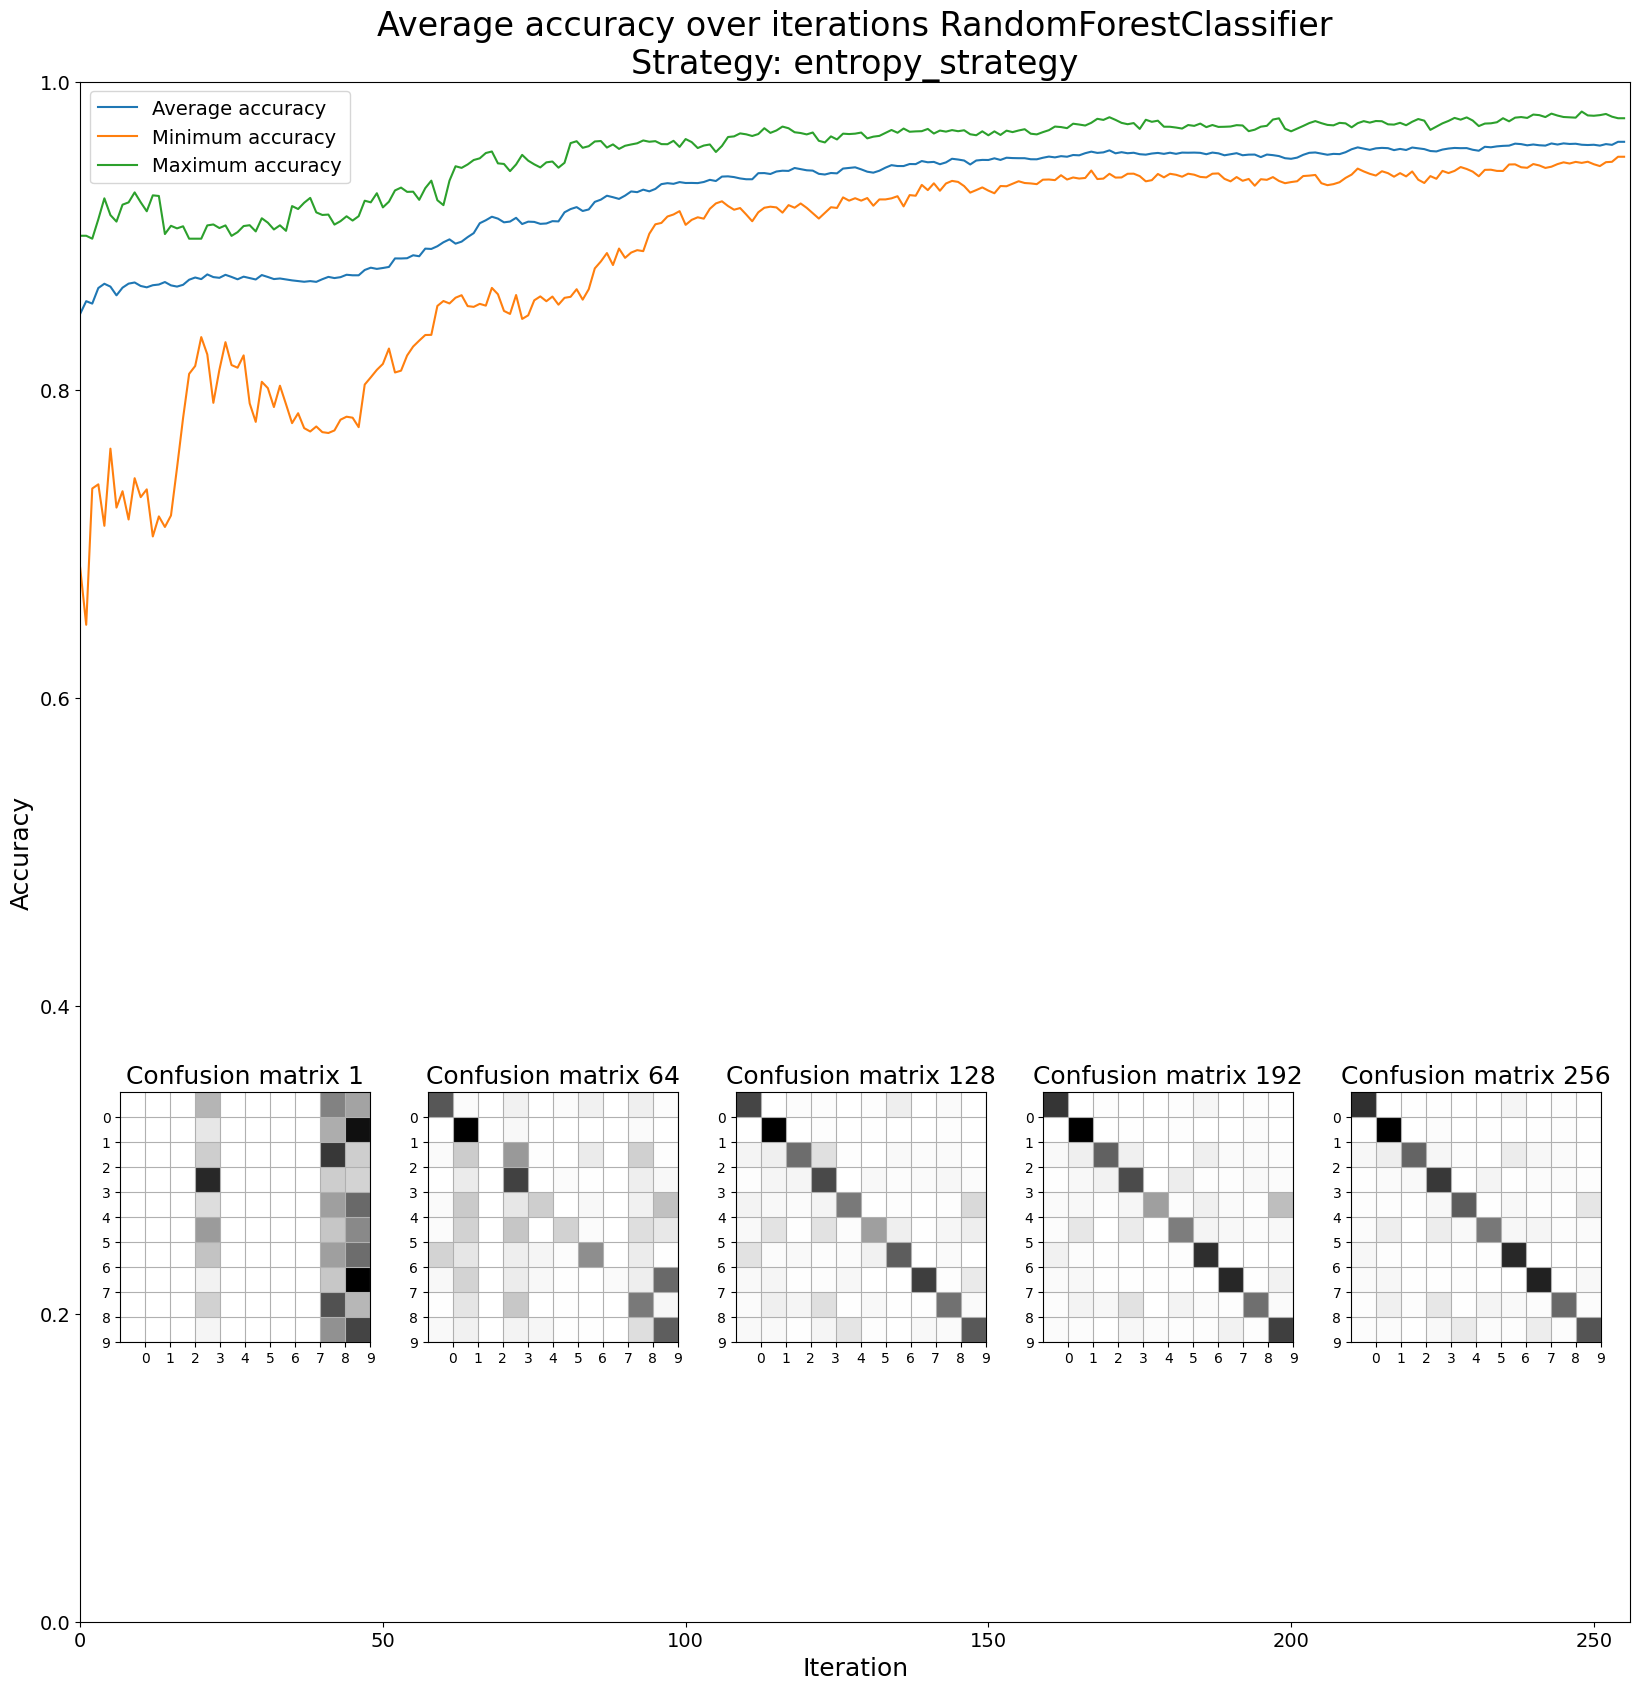

/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7

Final accuracy: [0.97743401 0.9610714  0.95981329 0.95562655 0.96312396 0.95409646
 0.96621999 0.96851403 0.9596786  0.95012079]
Final confusion matrix: [[1230    1    8    4    2   11   71    2   13    1]
 [   0 1525    1   16    0   26    3    6   22    1]
 [  49  103  960   43   11    1  135   45   17   16]
 [  12   36   62 1163    1   70   11   18   33   27]
 [   9   32    7   23  942   14   44   15    9  200]
 [  28  118    3  115   20  841   61   32   15   40]
 [  36   23    3    1    3    9 1318    0    3    0]
 [  29   51    5   12   22    3    5 1301    4   71]
 [  25   94   40  100   12   46   60   22  926   32]
 [  17   28    2   41   85   20   16  100    5 1106]]
Final iteration: 200
Final accuracy threshold reached: True


/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:152: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


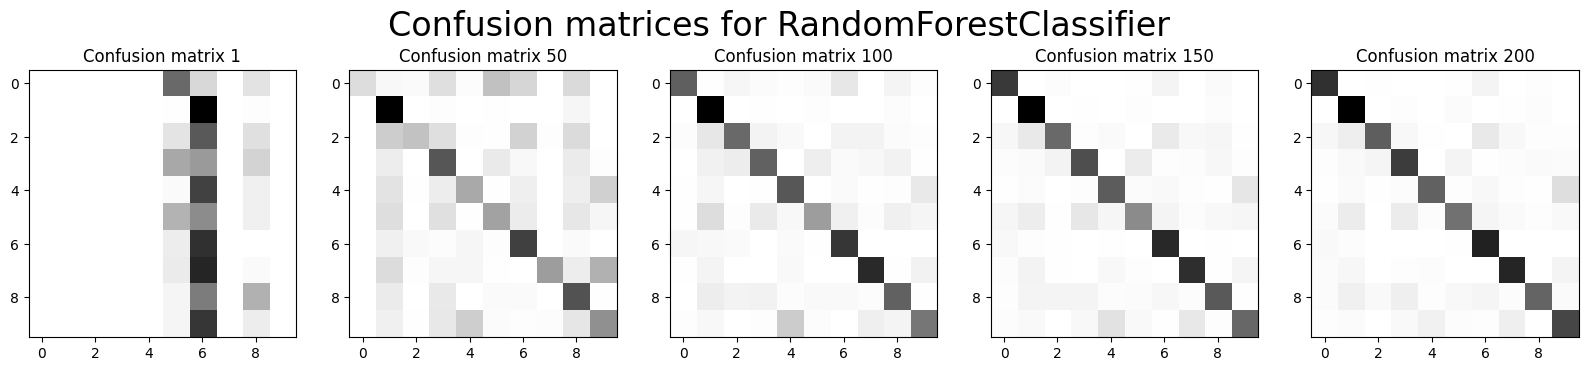

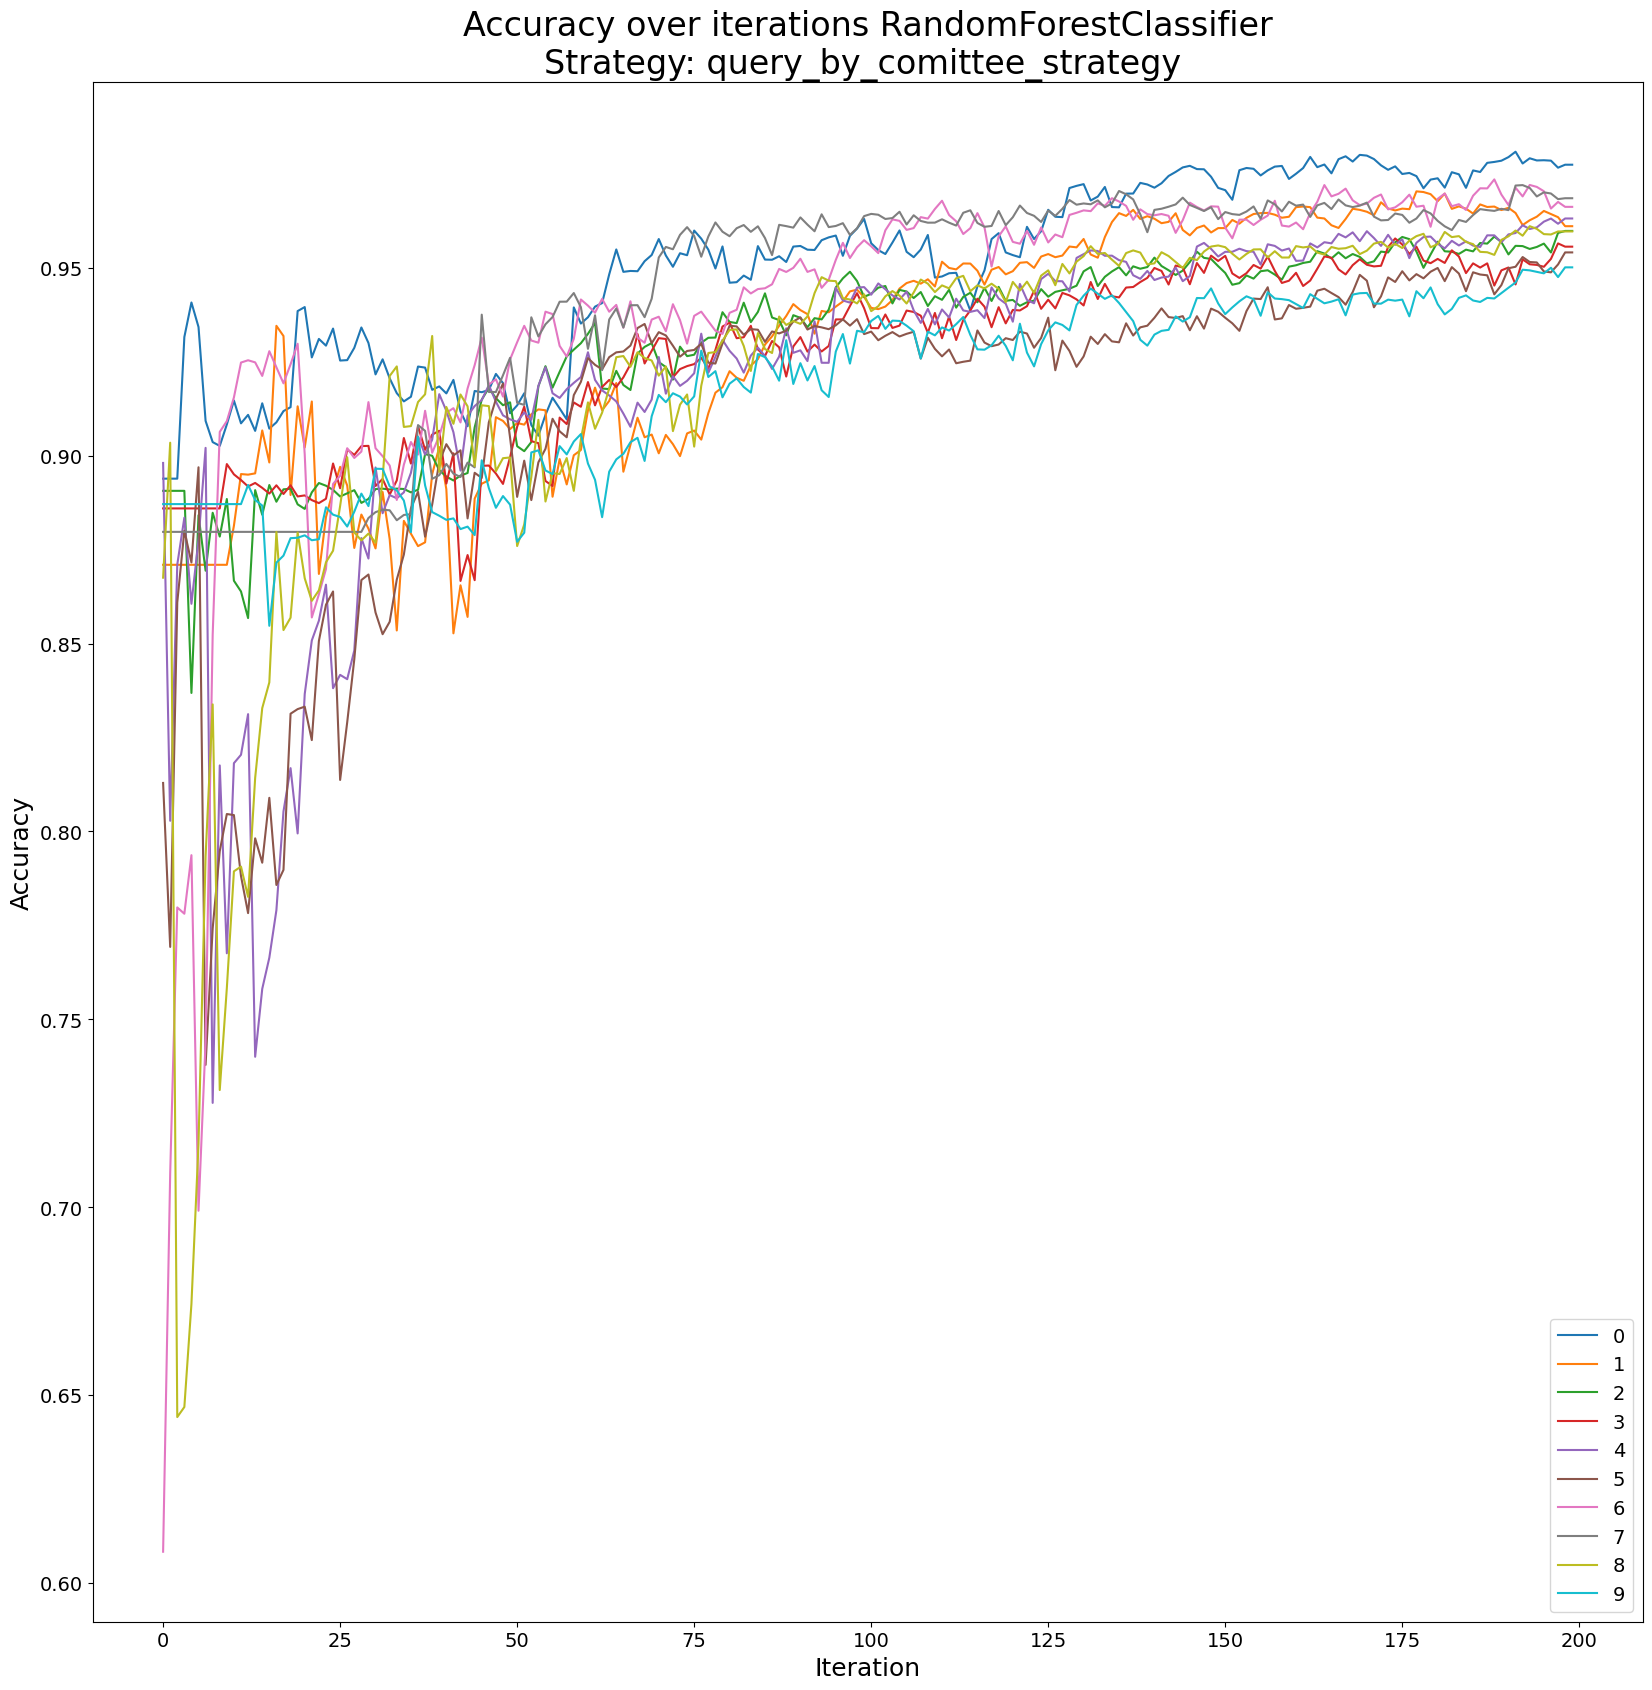

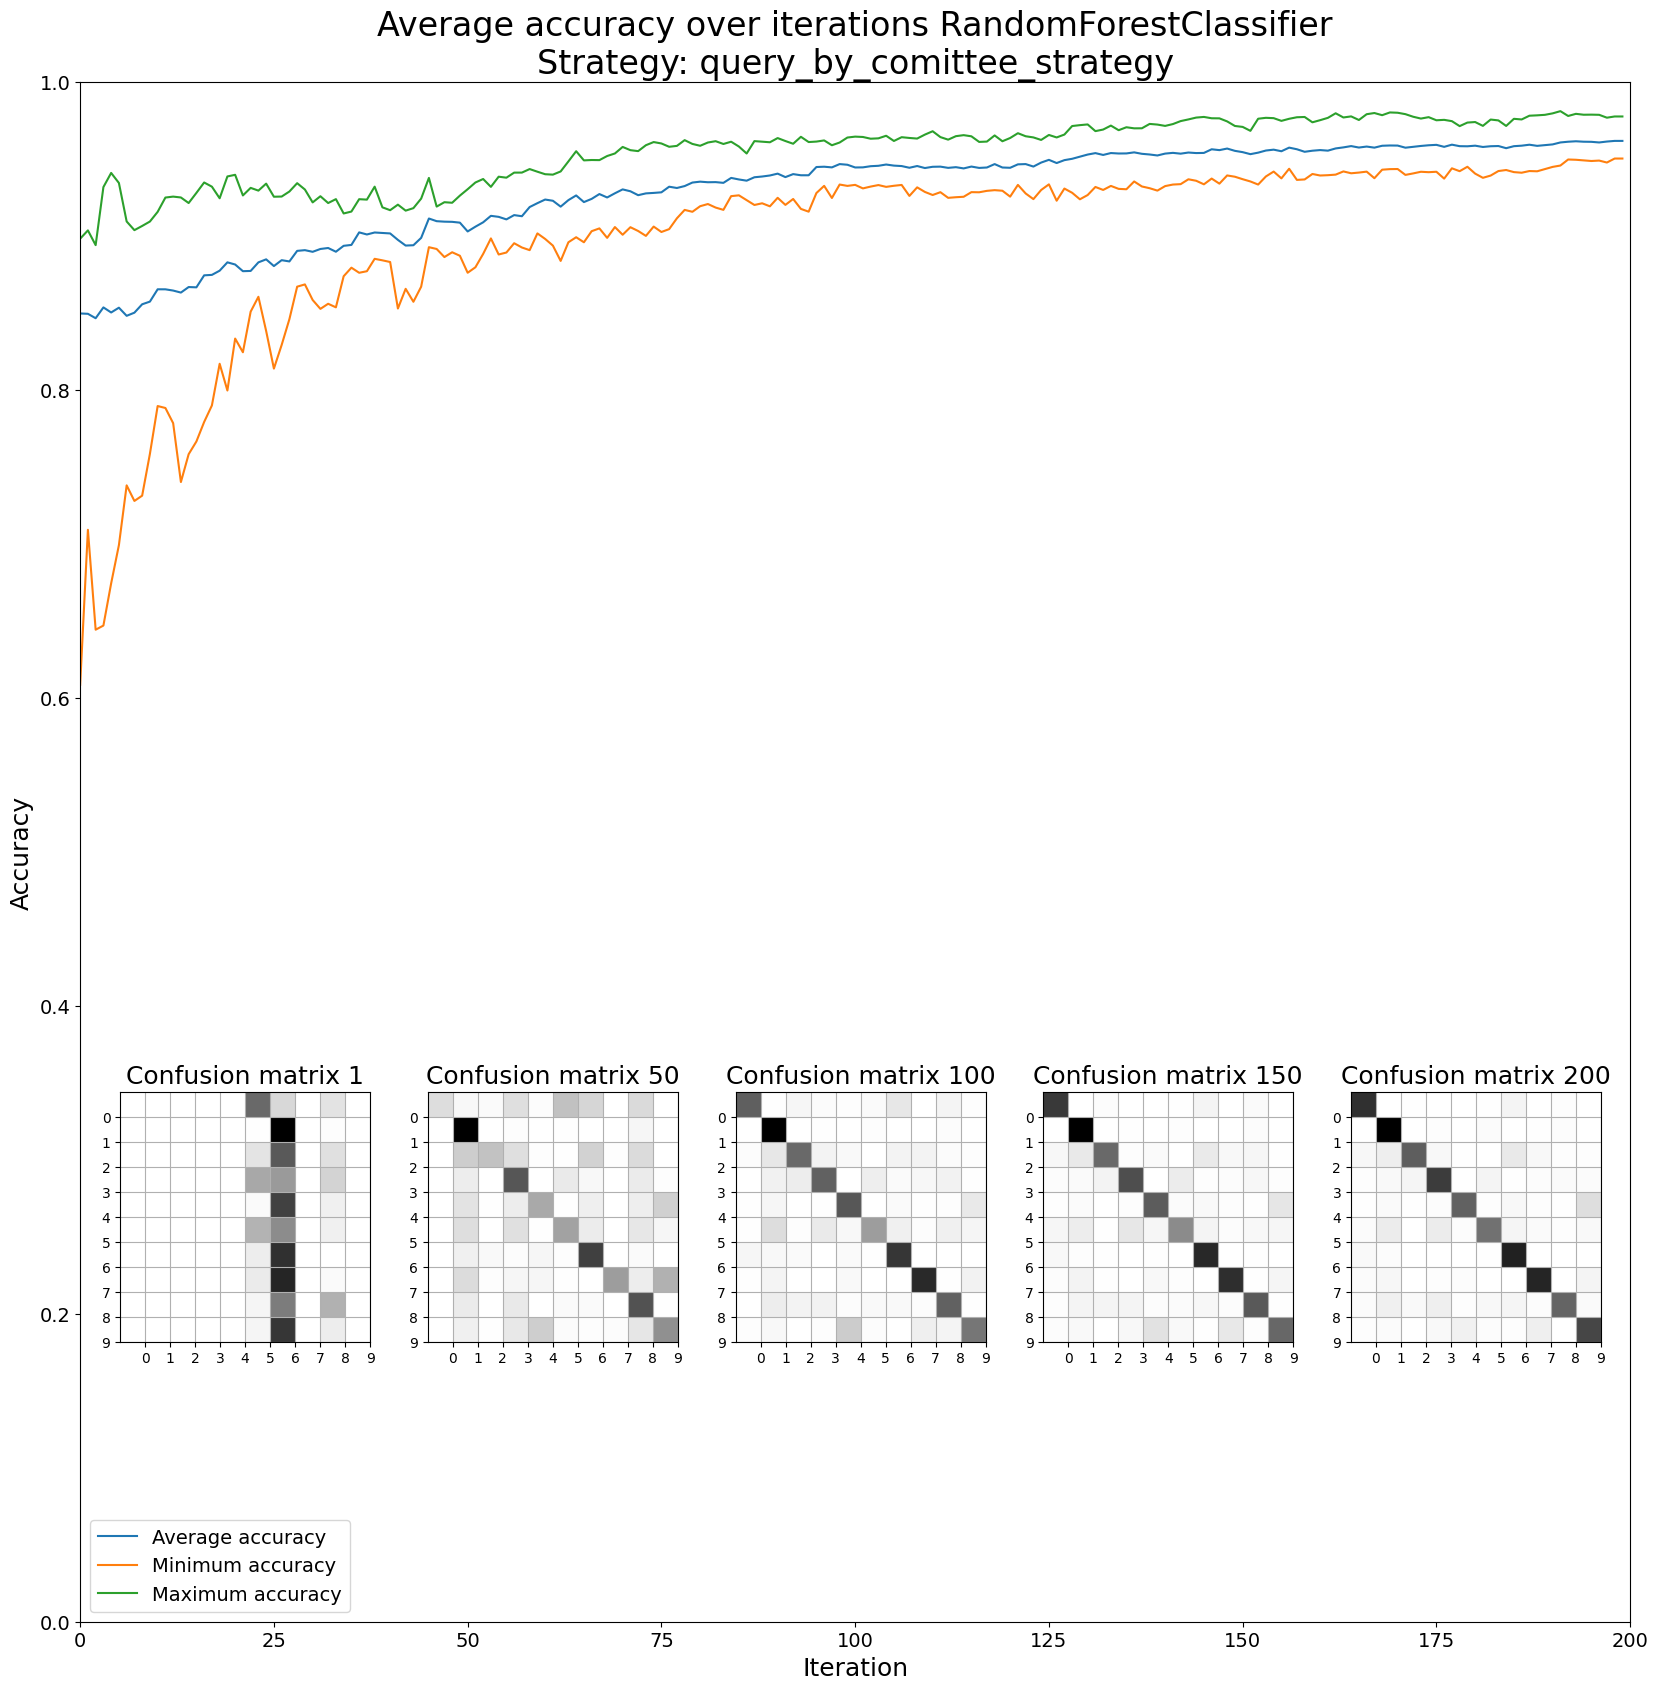

/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7

Final accuracy: [0.9804947  0.98576436 0.96757997 0.95081967 0.95051546 0.95649042
 0.97219783 0.97103129 0.96233766 0.95544626]
Final confusion matrix: [[1280    0    6   15    5   19    6    2    9    1]
 [   0 1490   13   27   11    9    0    4   46    0]
 [  37    9 1125   60   74    7    3   21   37    7]
 [   9   10   24 1248   16   26    4   21   50   25]
 [   6    4    7    2 1210   14    1    5    9   37]
 [  50    7   11  218   55  912    7    0   13    0]
 [  66   16  102   30   77   54 1040    0   11    0]
 [  18   10   13    5   97   17    0 1207    4  132]
 [   9   22   17  146   29   78    3    8 1026   19]
 [  18   11    4   17  271   19    0   43   12 1025]]
Final iteration: 175
Final accuracy threshold reached: True


/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:152: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


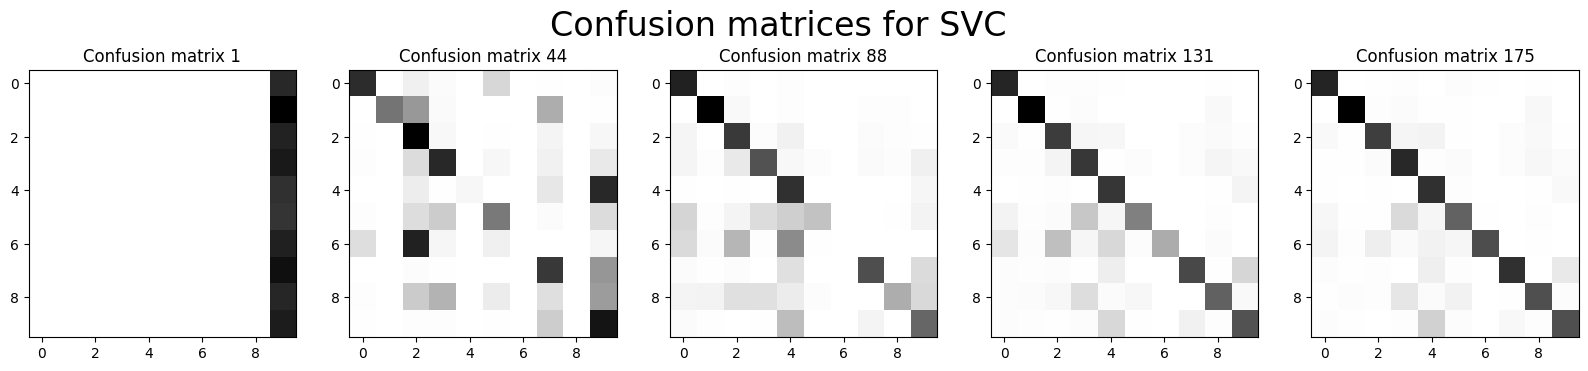

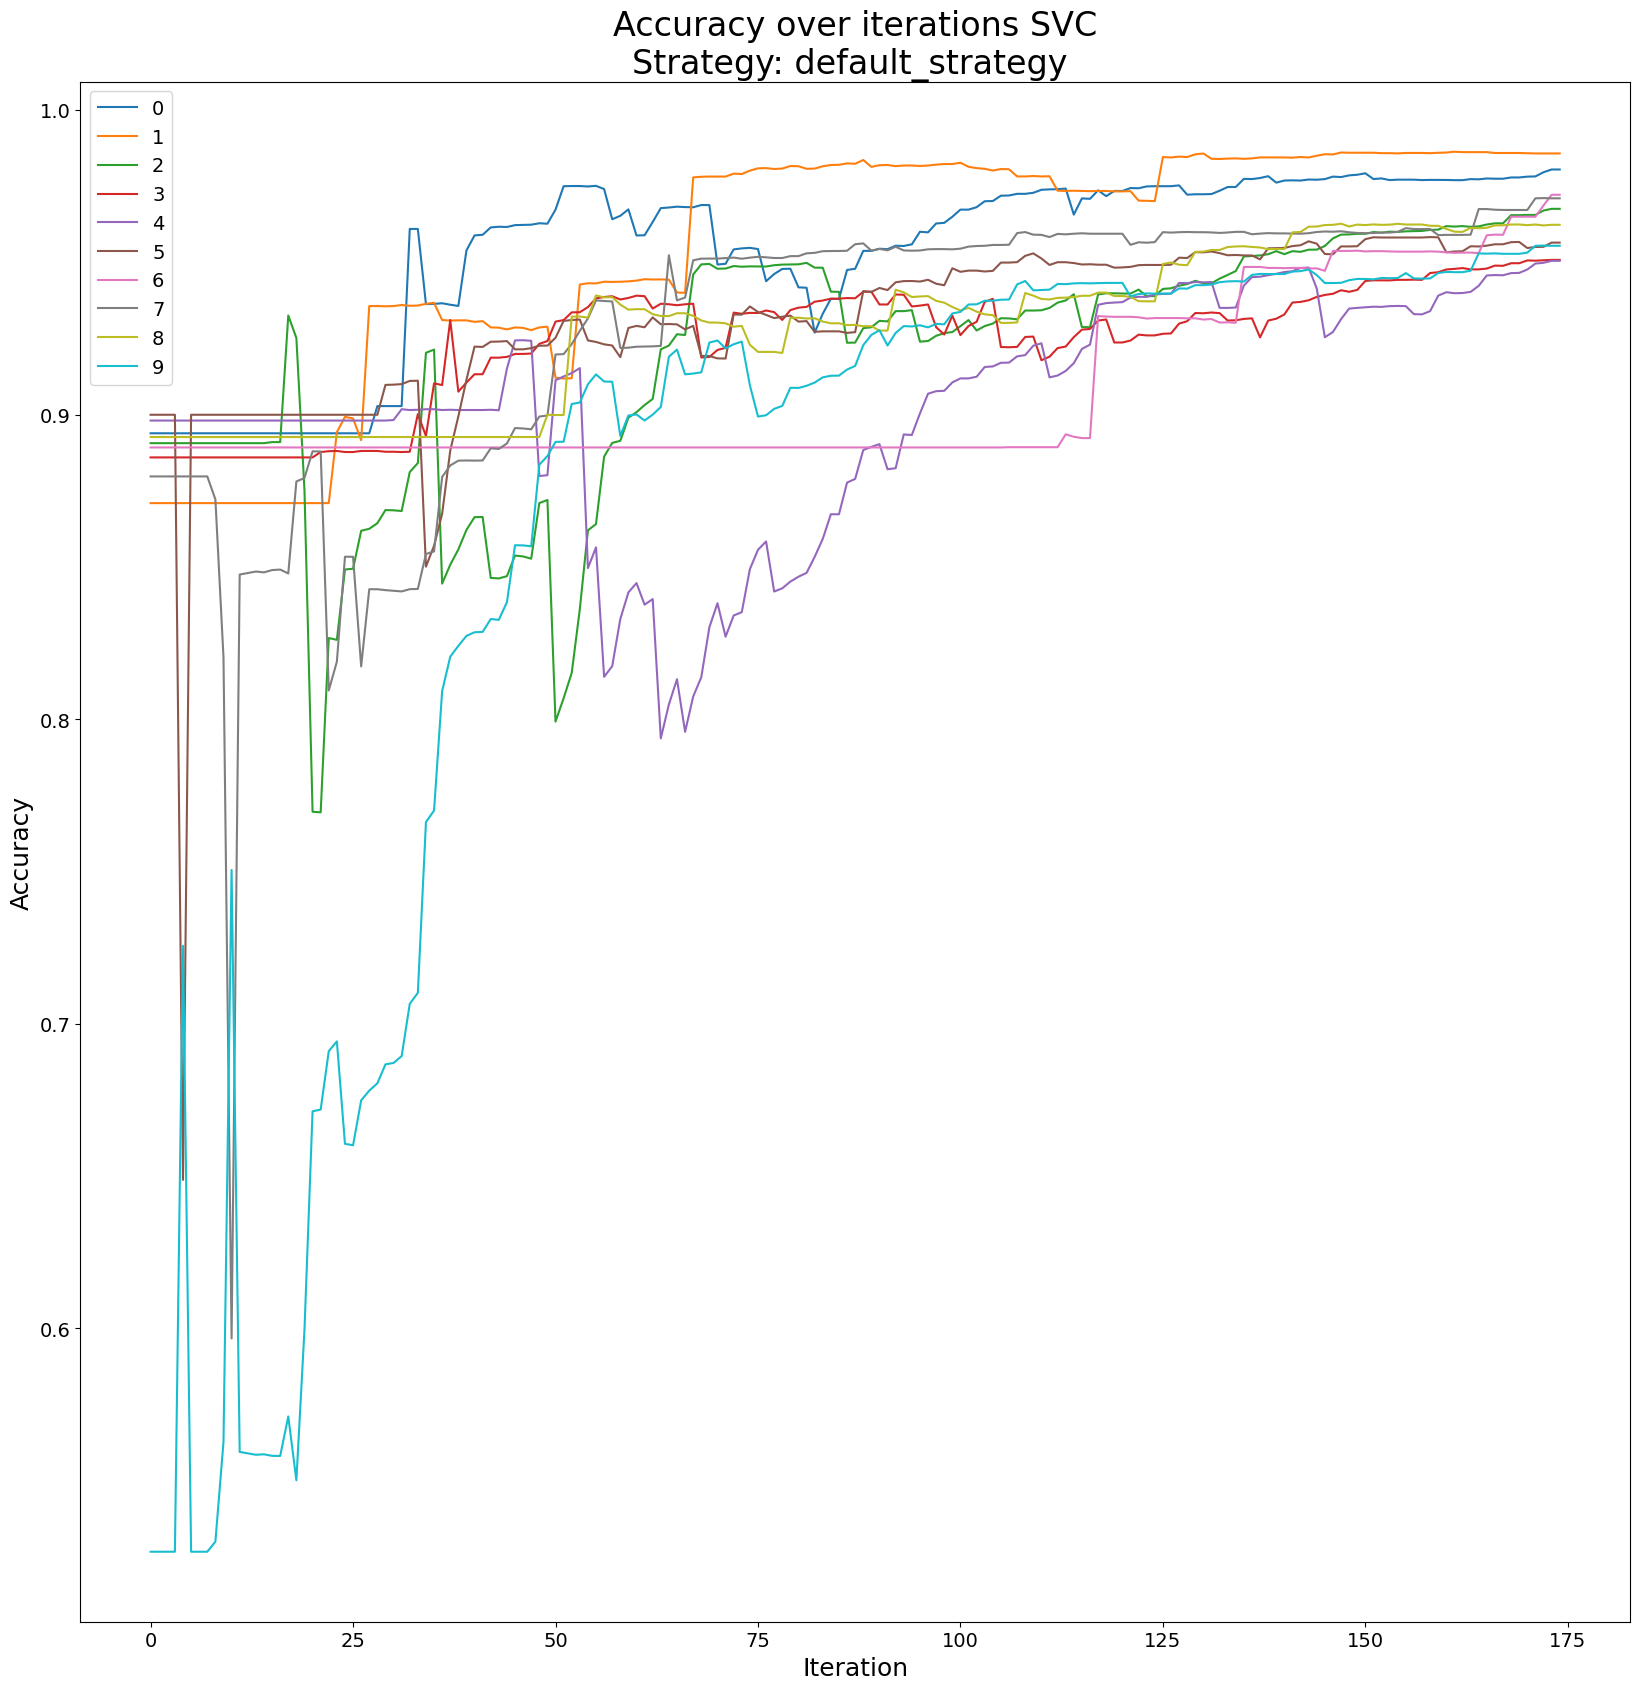

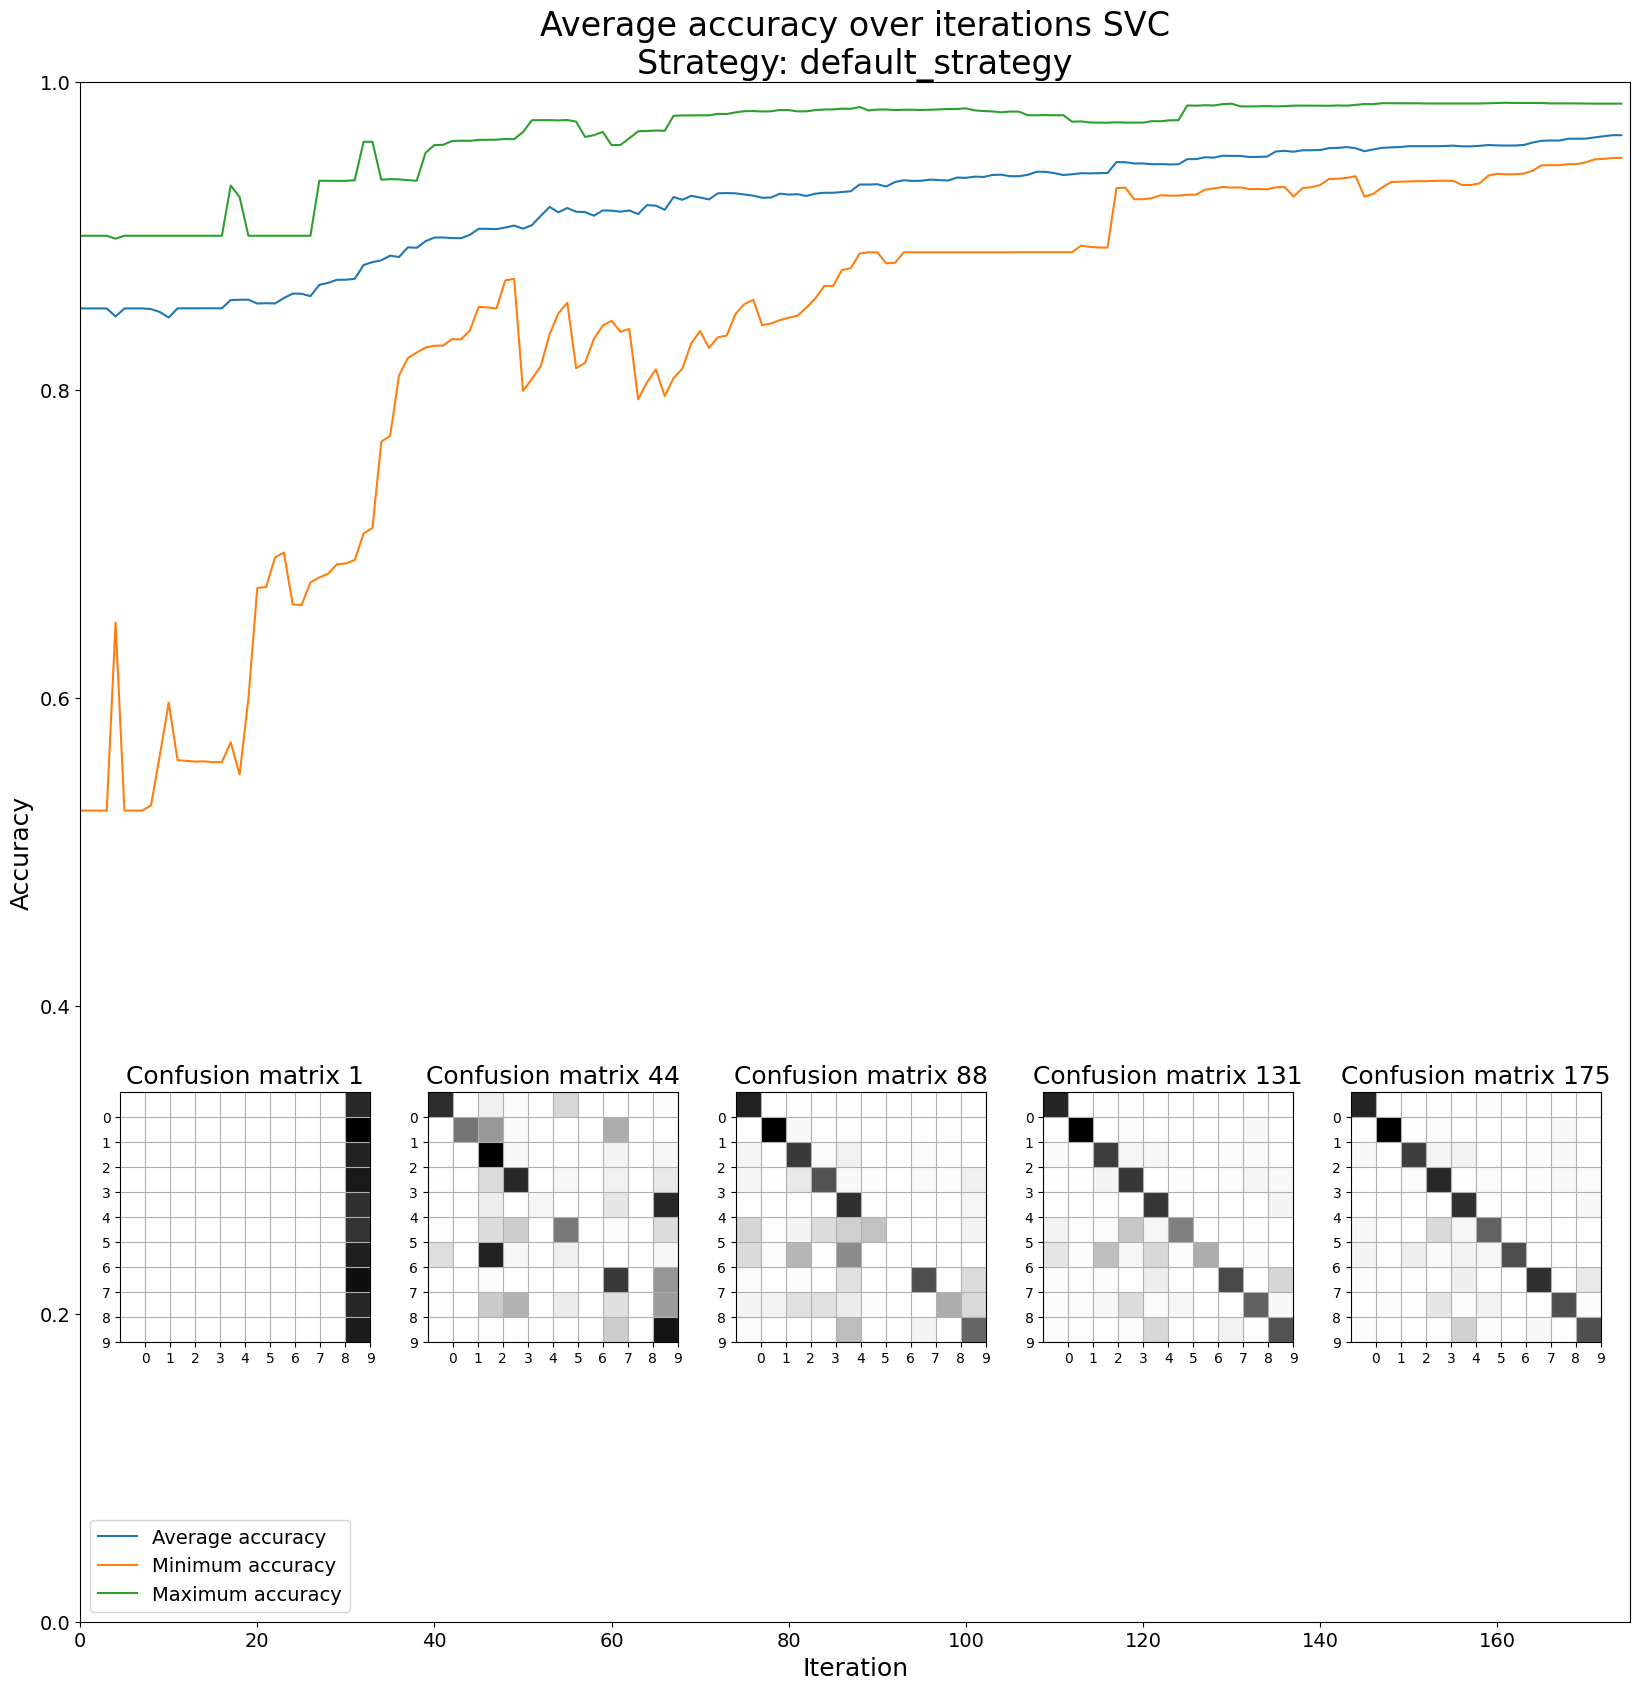

/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7

Final accuracy: [0.98538178 0.98125176 0.97233202 0.95565598 0.95554007 0.95975768
 0.98354818 0.96923189 0.95572252 0.95012148]
Final confusion matrix: [[1286    0    5    1    4   30   12    0    3    2]
 [   0 1561    5   15    3    6    1    0    6    3]
 [  17   26 1145   22   50    7   72   16   17    8]
 [  14   18   55 1200    8   66   12   14   28   18]
 [   5    6    3    0 1151    2    9    0    3  116]
 [  30   21    4  169   38  927   13    0   53   18]
 [  28    5   24    1   22   13 1301    0    2    0]
 [   9   43   15    2  127    9    1 1134   15  148]
 [  24   78   36  170   26   64   15    3  908   33]
 [  22   30    3   15  216   15    1   19   31 1068]]
Final iteration: 270
Final accuracy threshold reached: True


/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:152: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


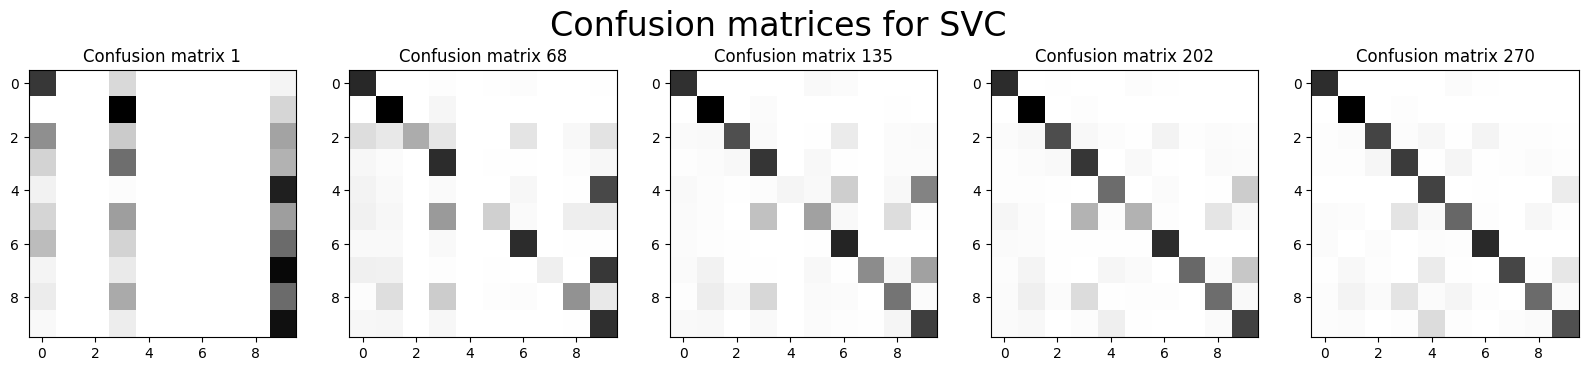

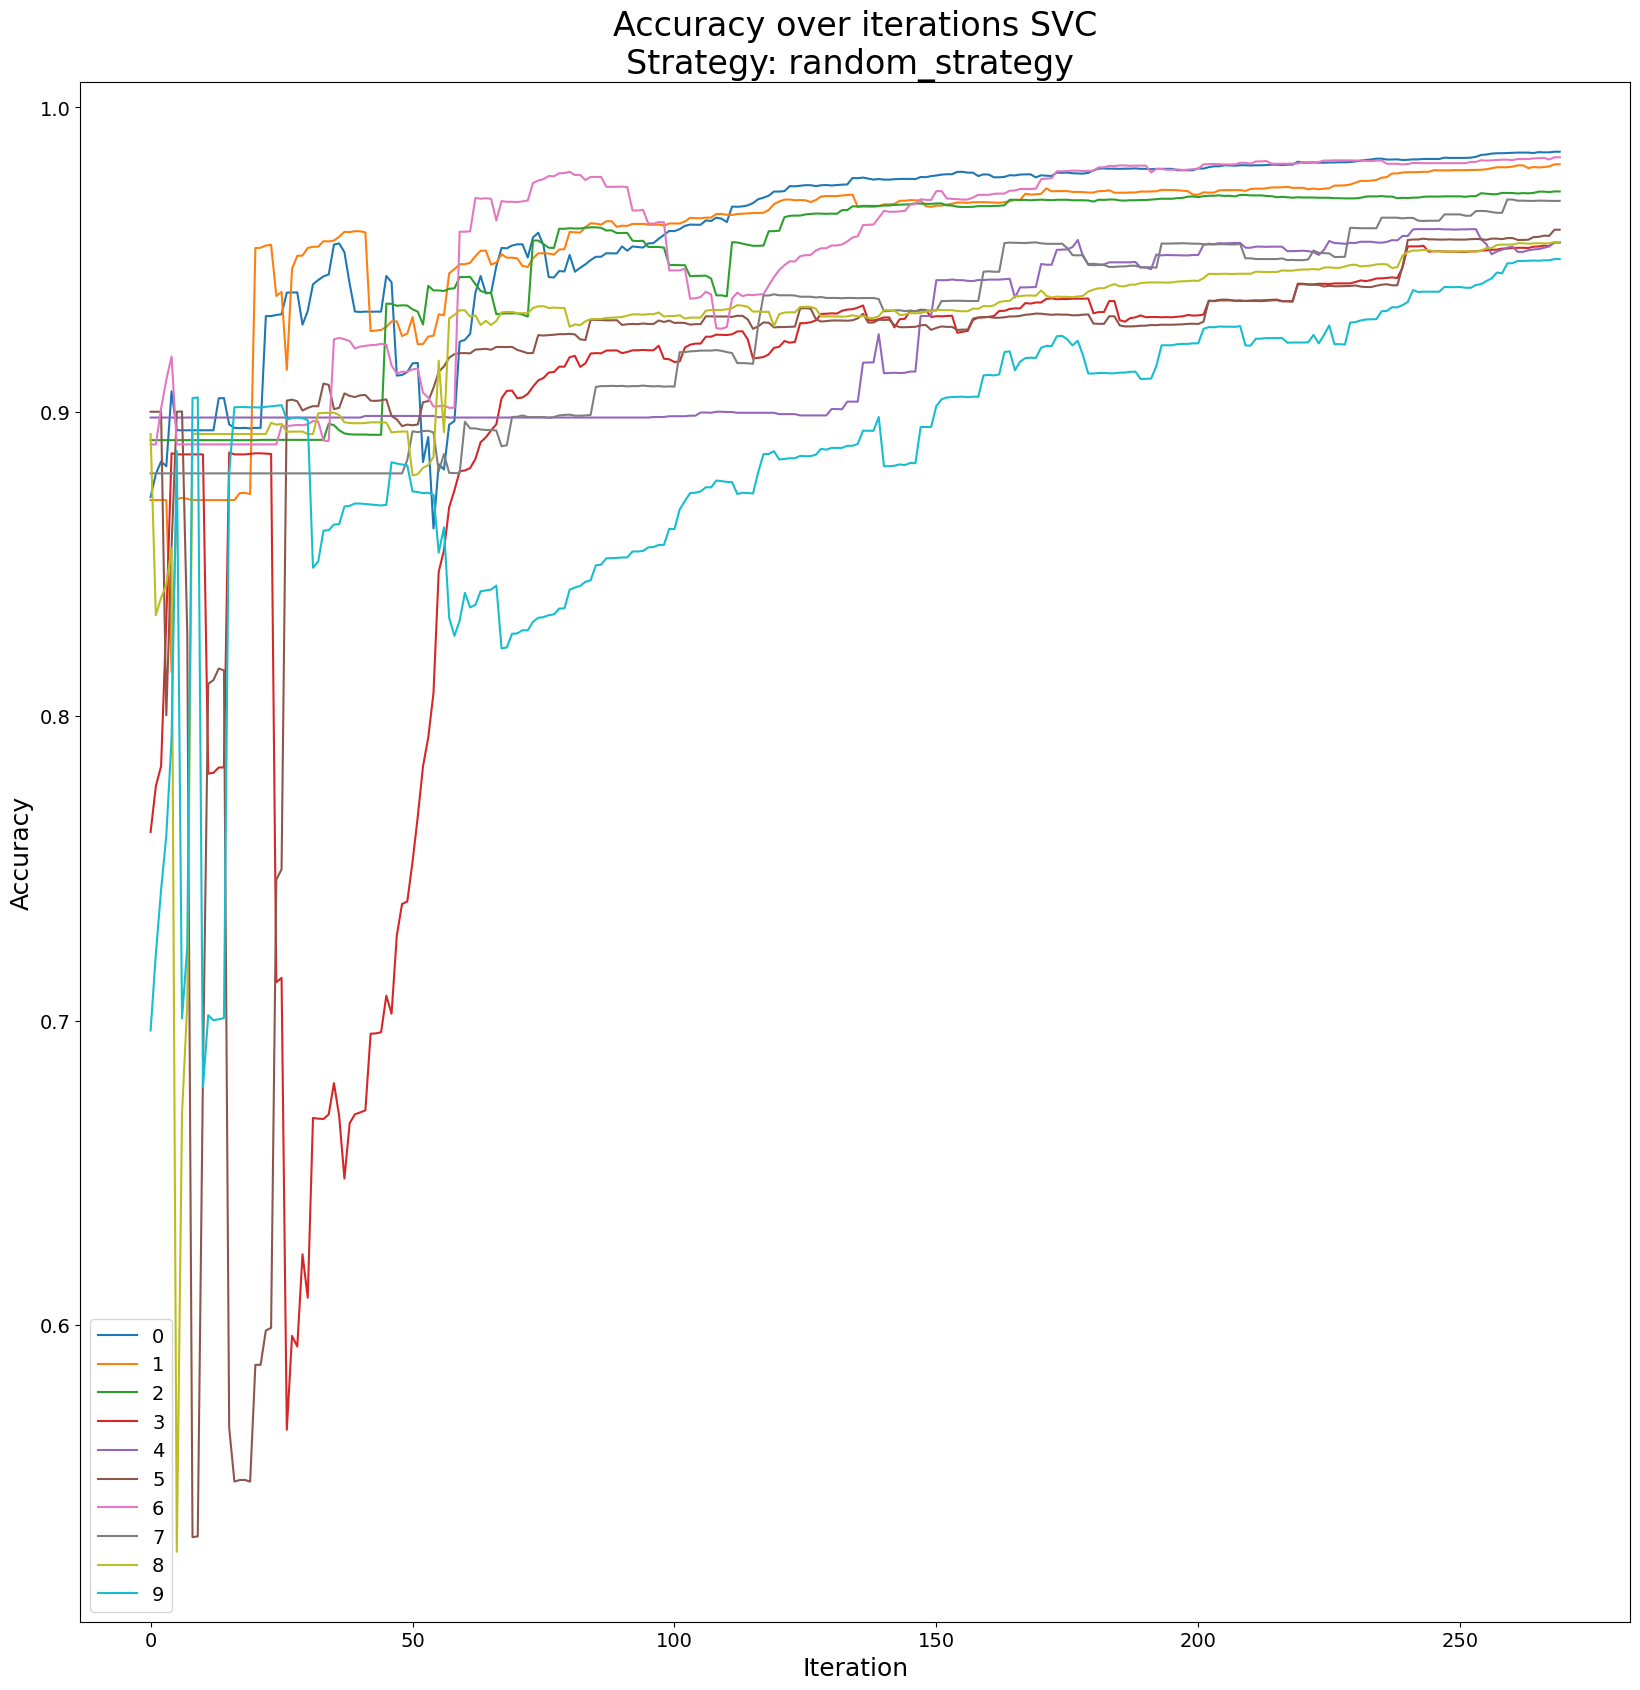

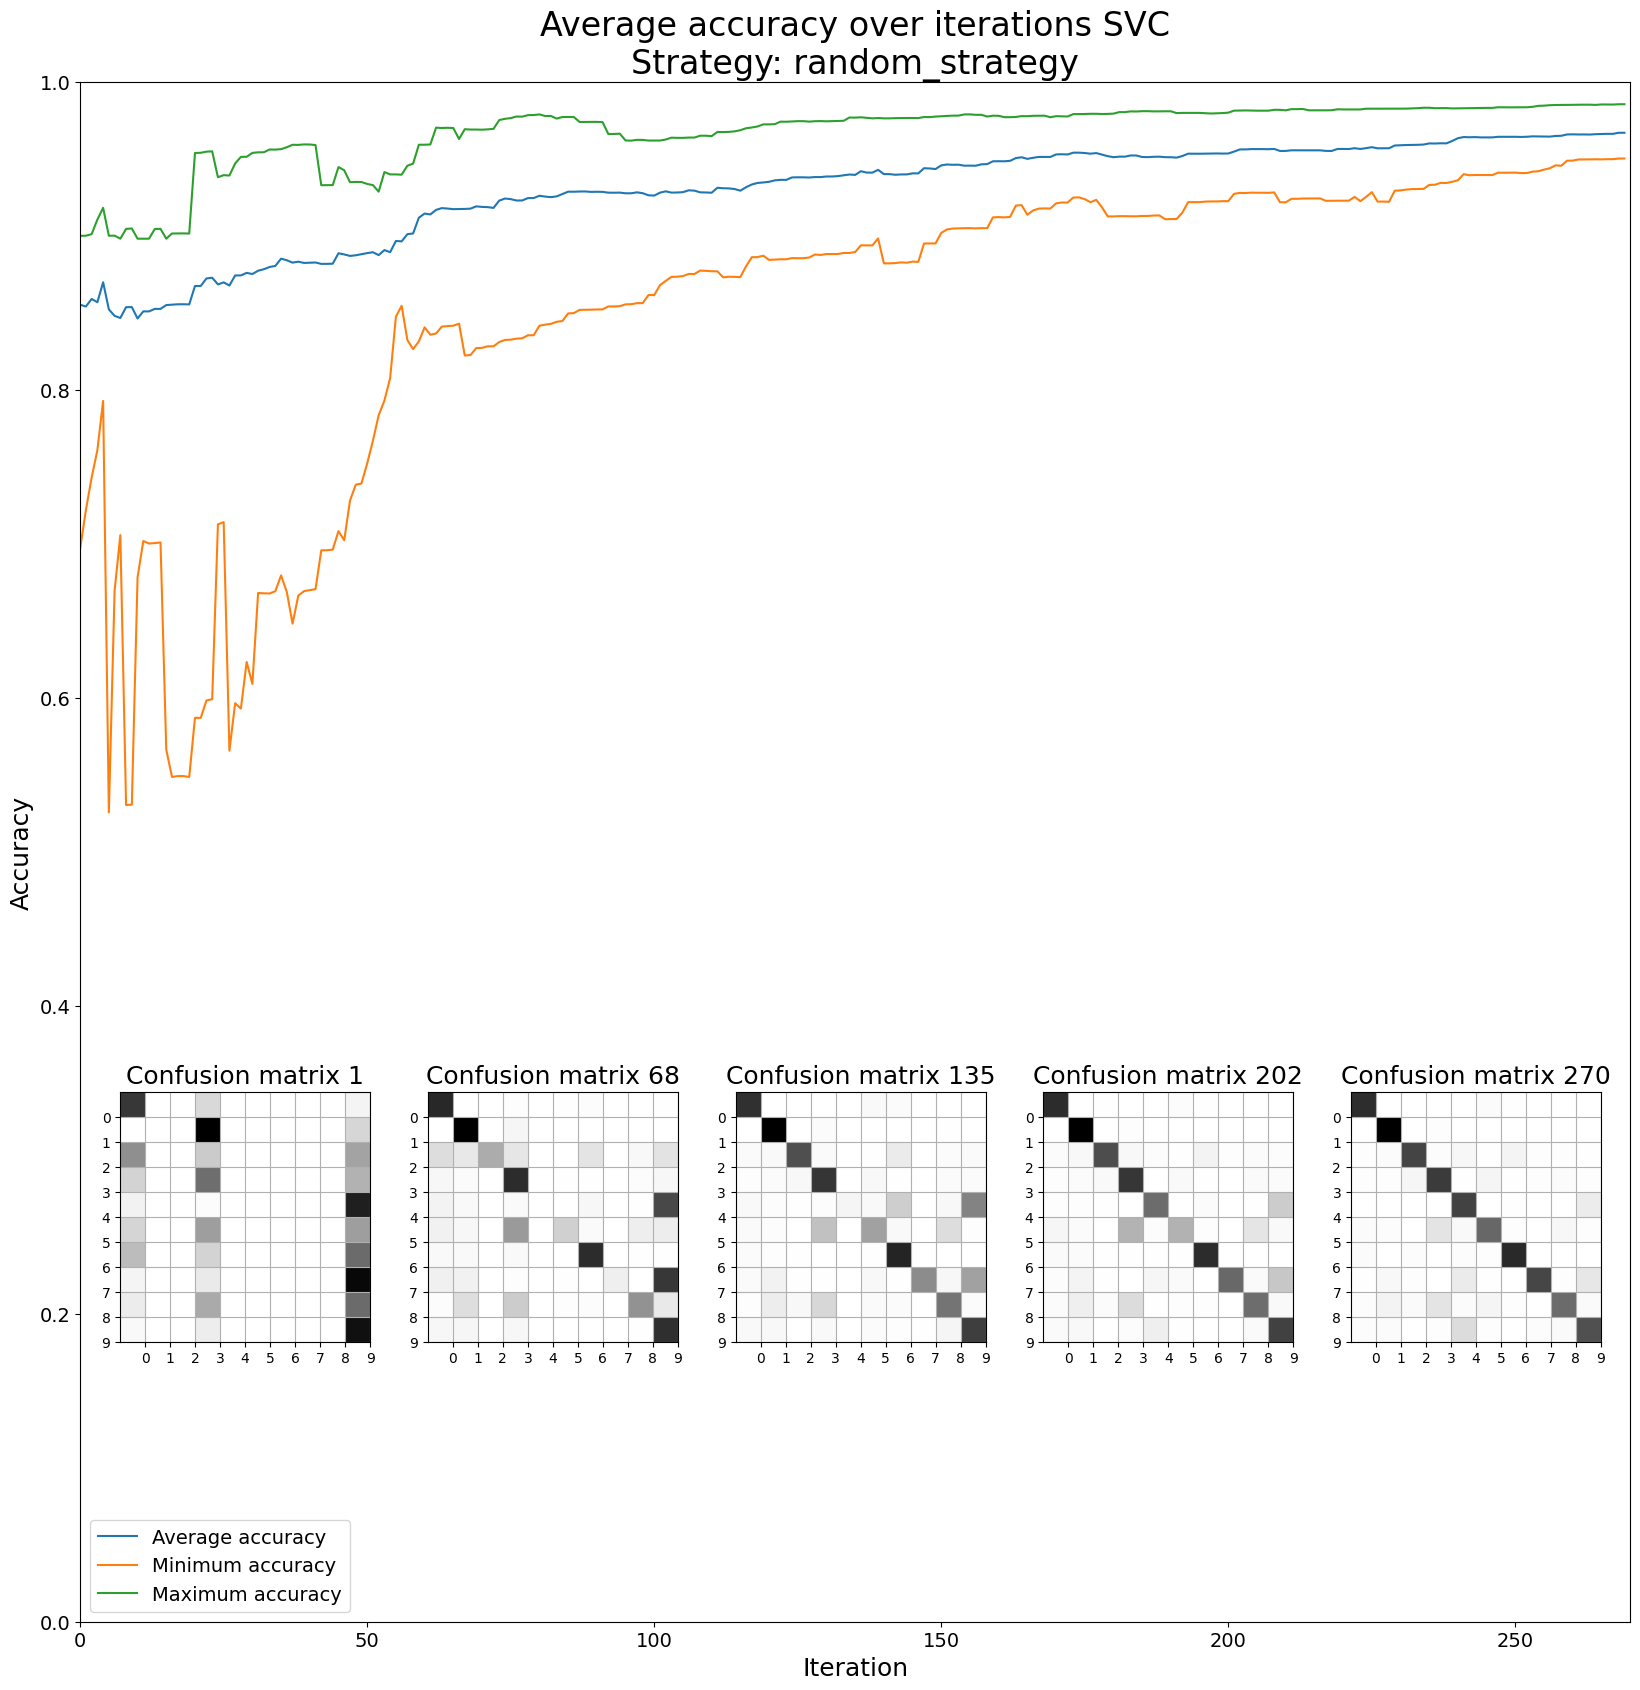

/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7

Final accuracy: [0.98891767 0.98434456 0.97312669 0.97496782 0.97723192 0.97196262
 0.98553241 0.96694093 0.95159956 0.95312717]
Final confusion matrix: [[1214    0   61    1    1   43    7    0   14    2]
 [   0 1422    6    4    1    4    0    4  156    3]
 [   1    5 1224    2   15    5    1    7  117    3]
 [   2    2   33 1249    0   20    0    7  101   19]
 [   1    1   12    0 1098    2    0    1   24  156]
 [   4    6   11   86    3 1033    4    0  122    4]
 [   5    3   53    4   41   52 1208    0   30    0]
 [   5    7   30    1   10    6    0 1084   11  349]
 [   2    8    9   52    2   11    0    2 1258   13]
 [   5    7    7   16   47    7    0   10   28 1293]]
Final iteration: 632
Final accuracy threshold reached: True


/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:152: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


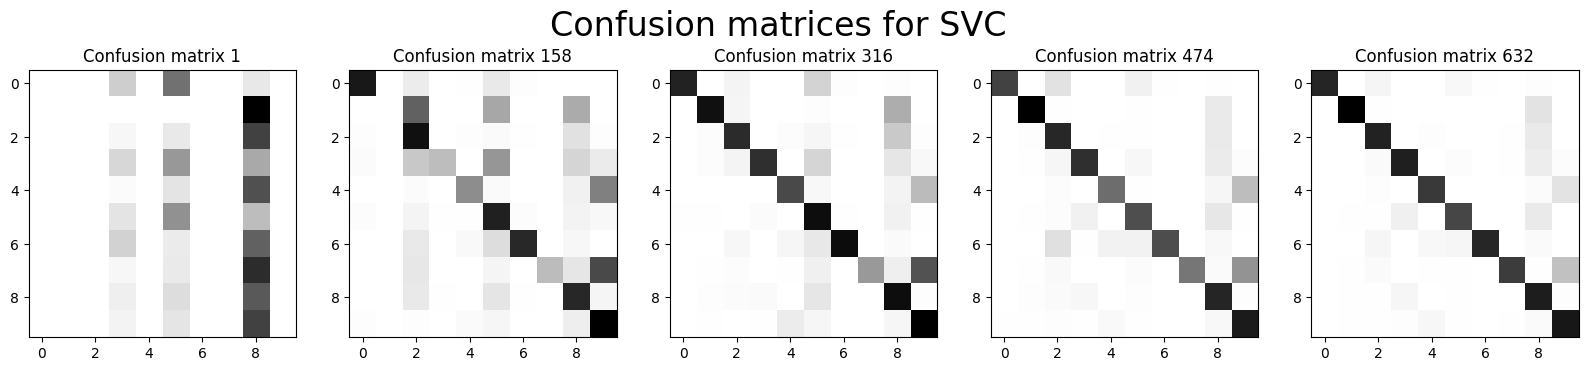

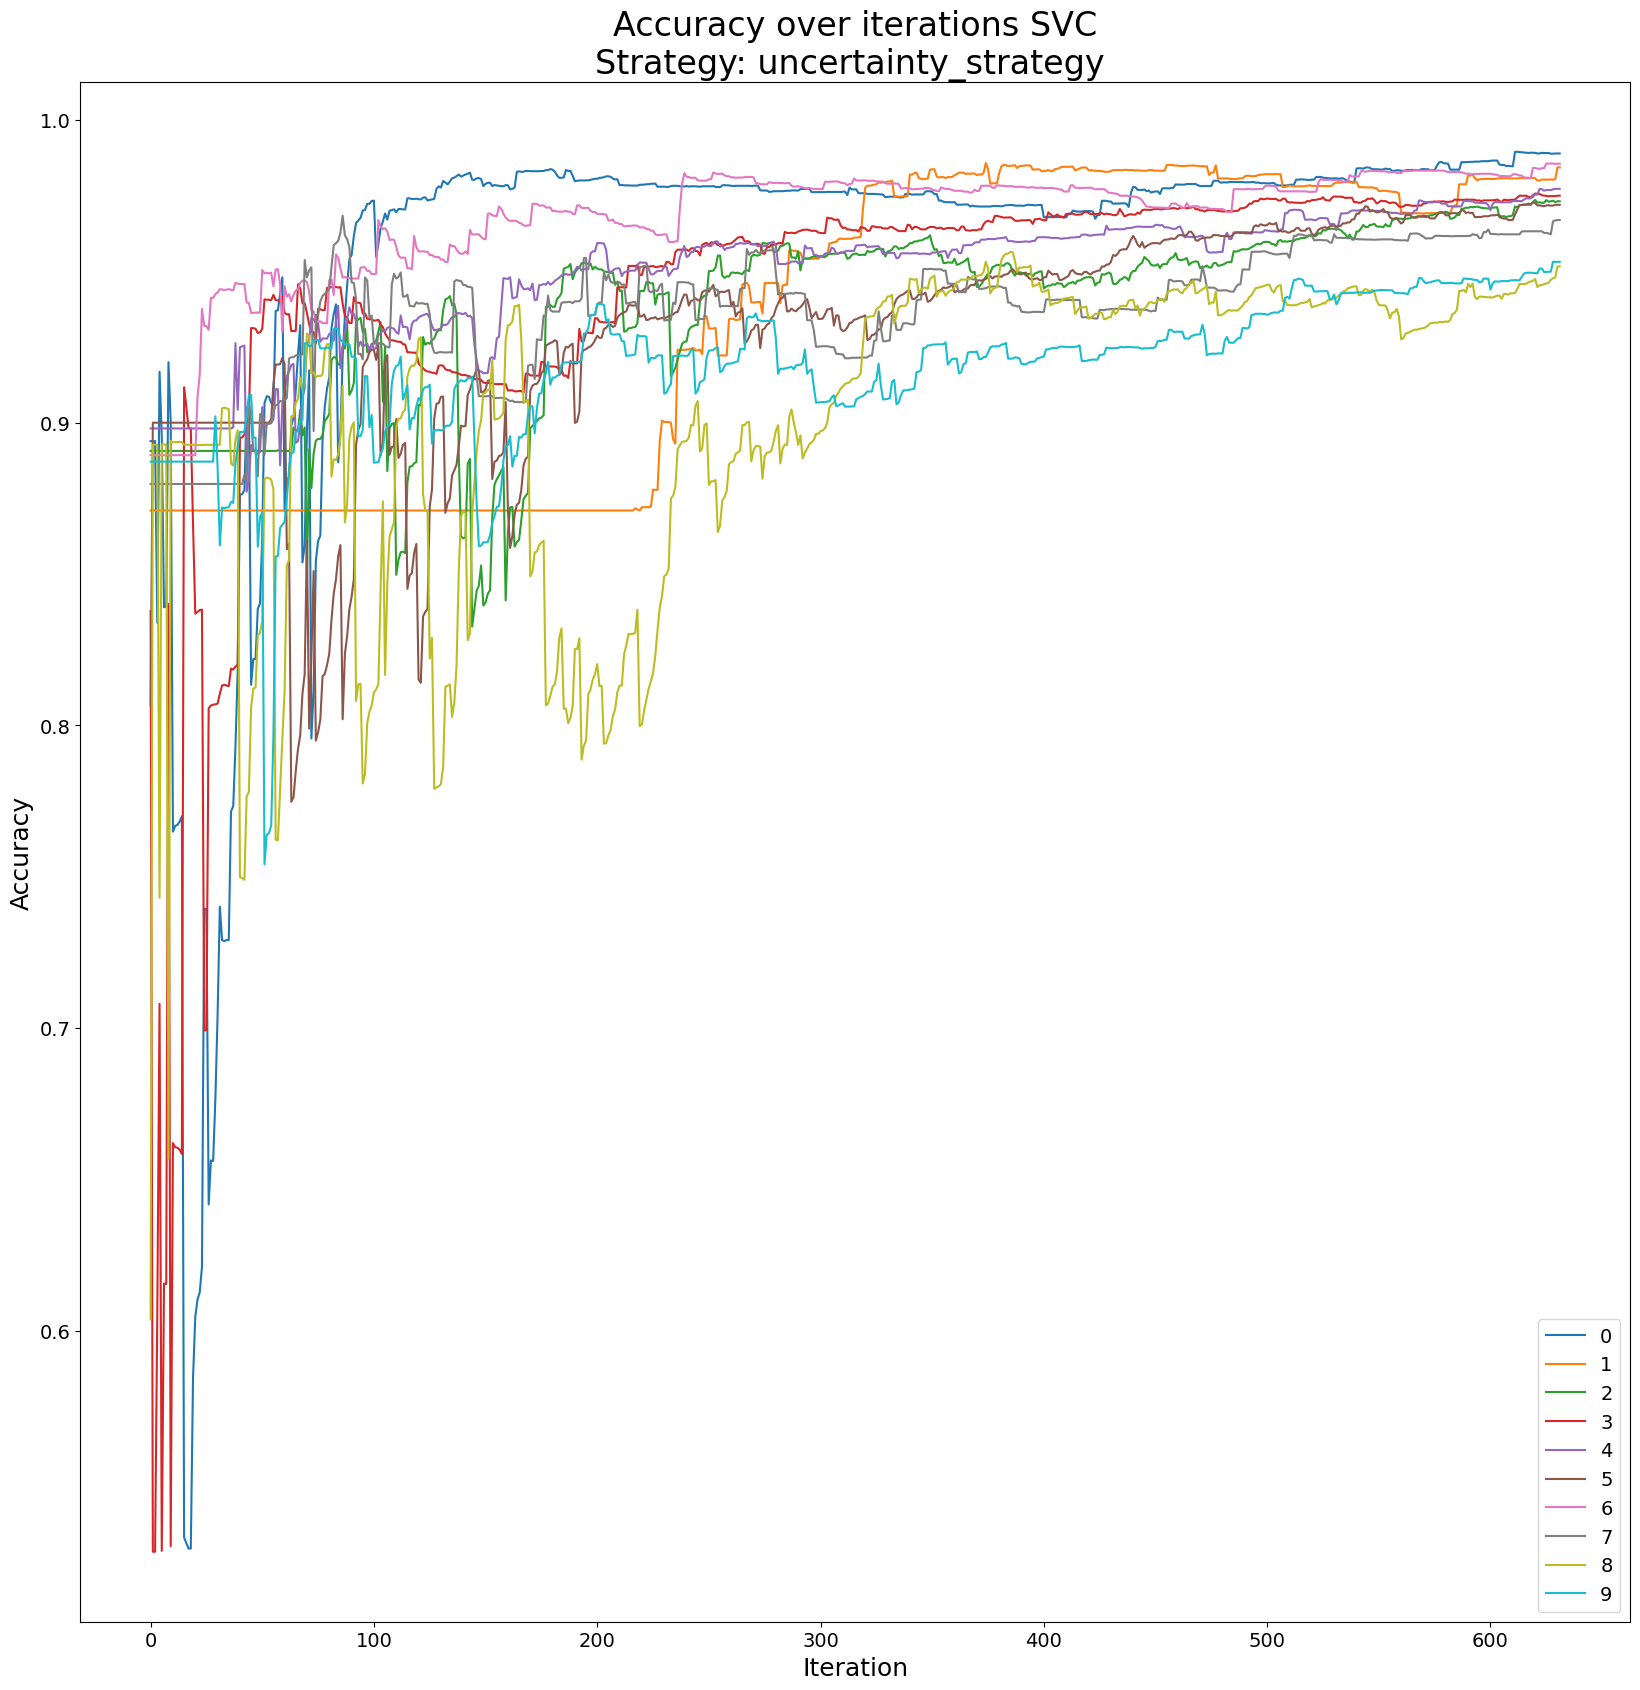

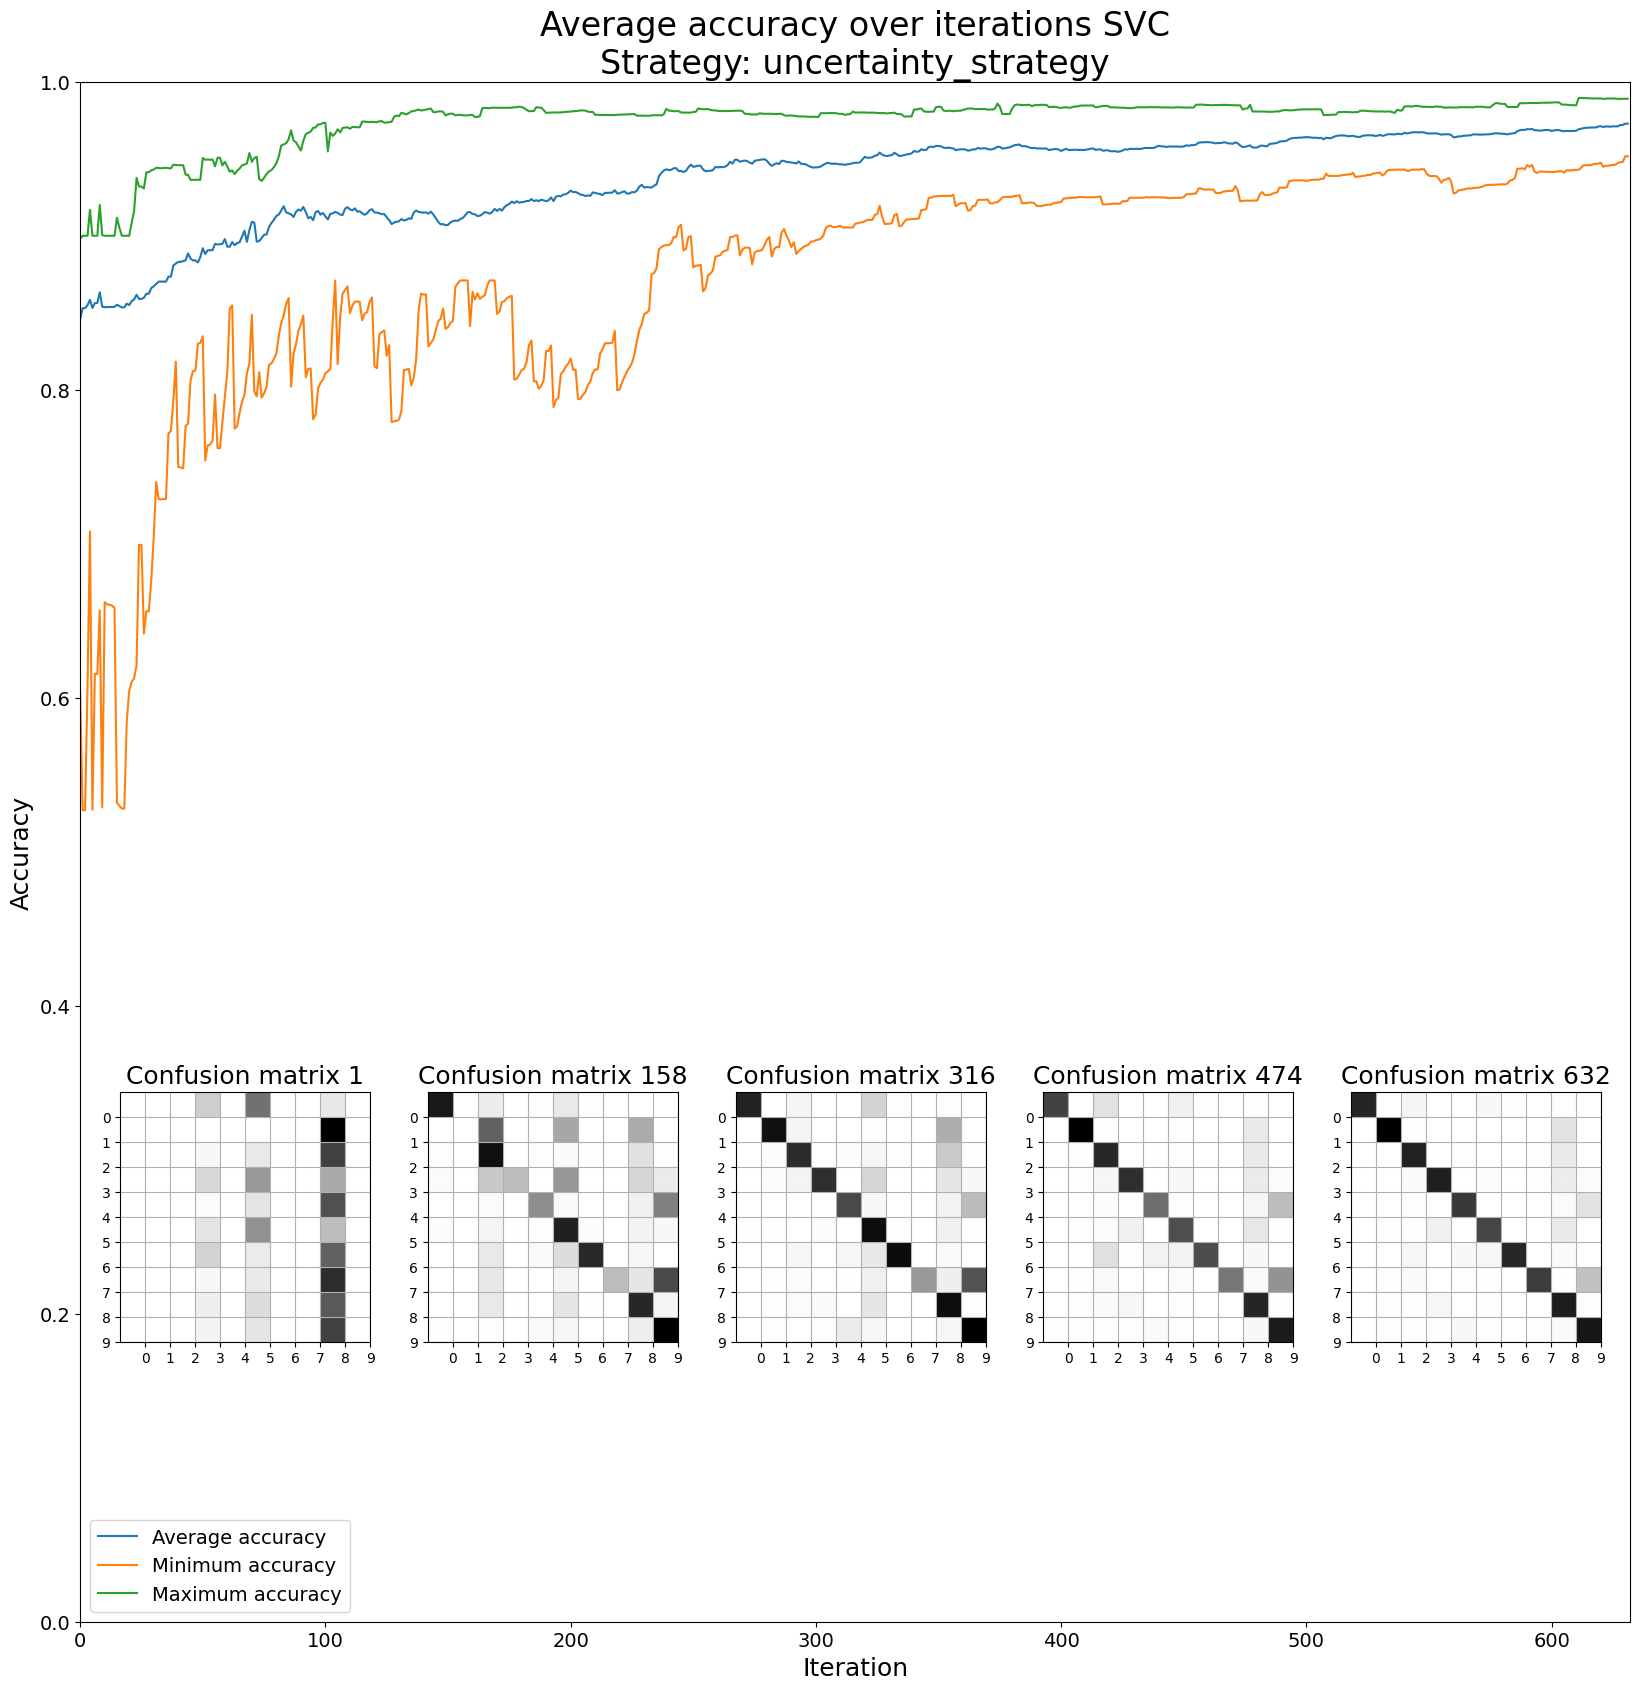

/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7

Final accuracy: [0.98949338 0.98130977 0.97343494 0.97897855 0.9816808  0.97210986
 0.98377987 0.97091201 0.95114588 0.96216978]
Final confusion matrix: [[1218    1   31    0    1   72    8    0    9    3]
 [   0 1373   10    4    2    1    0    2  202    6]
 [   2    6 1214    2   19    5    2    5  123    2]
 [   0    2   33 1209    1   61    2   11   97   17]
 [   2    0   15    0 1181    1    0    4   38   54]
 [   3    5   10   32    2 1122    2    0   84   13]
 [   4    5   56    1   53   68 1189    0   20    0]
 [   4    3   36    2    6    8    0 1162   18  264]
 [   2    4    9   18    2   20    3    4 1288    7]
 [   4    5    7    8   57    6    0   32   52 1249]]
Final iteration: 855
Final accuracy threshold reached: True


/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:152: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


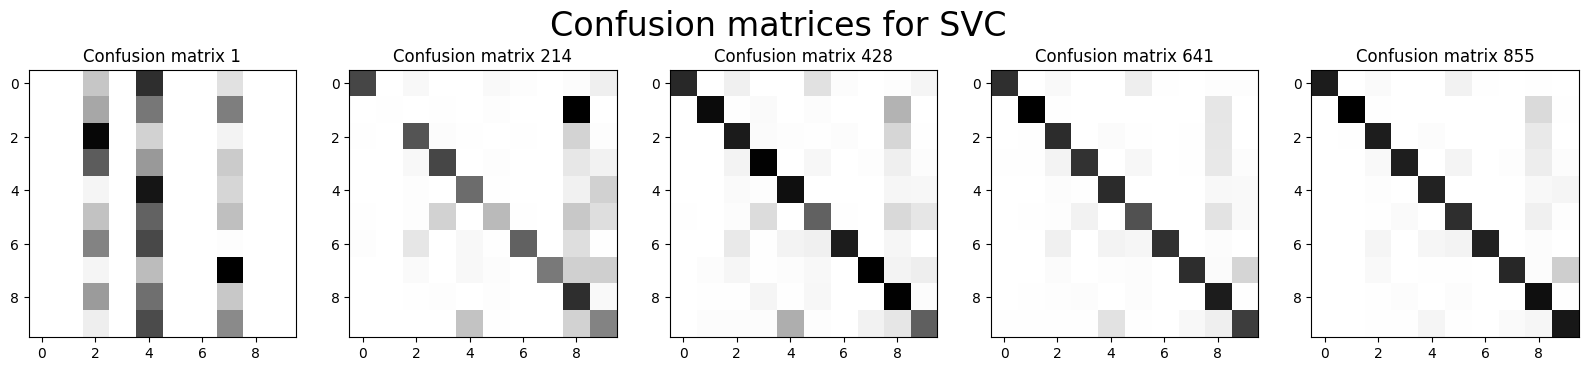

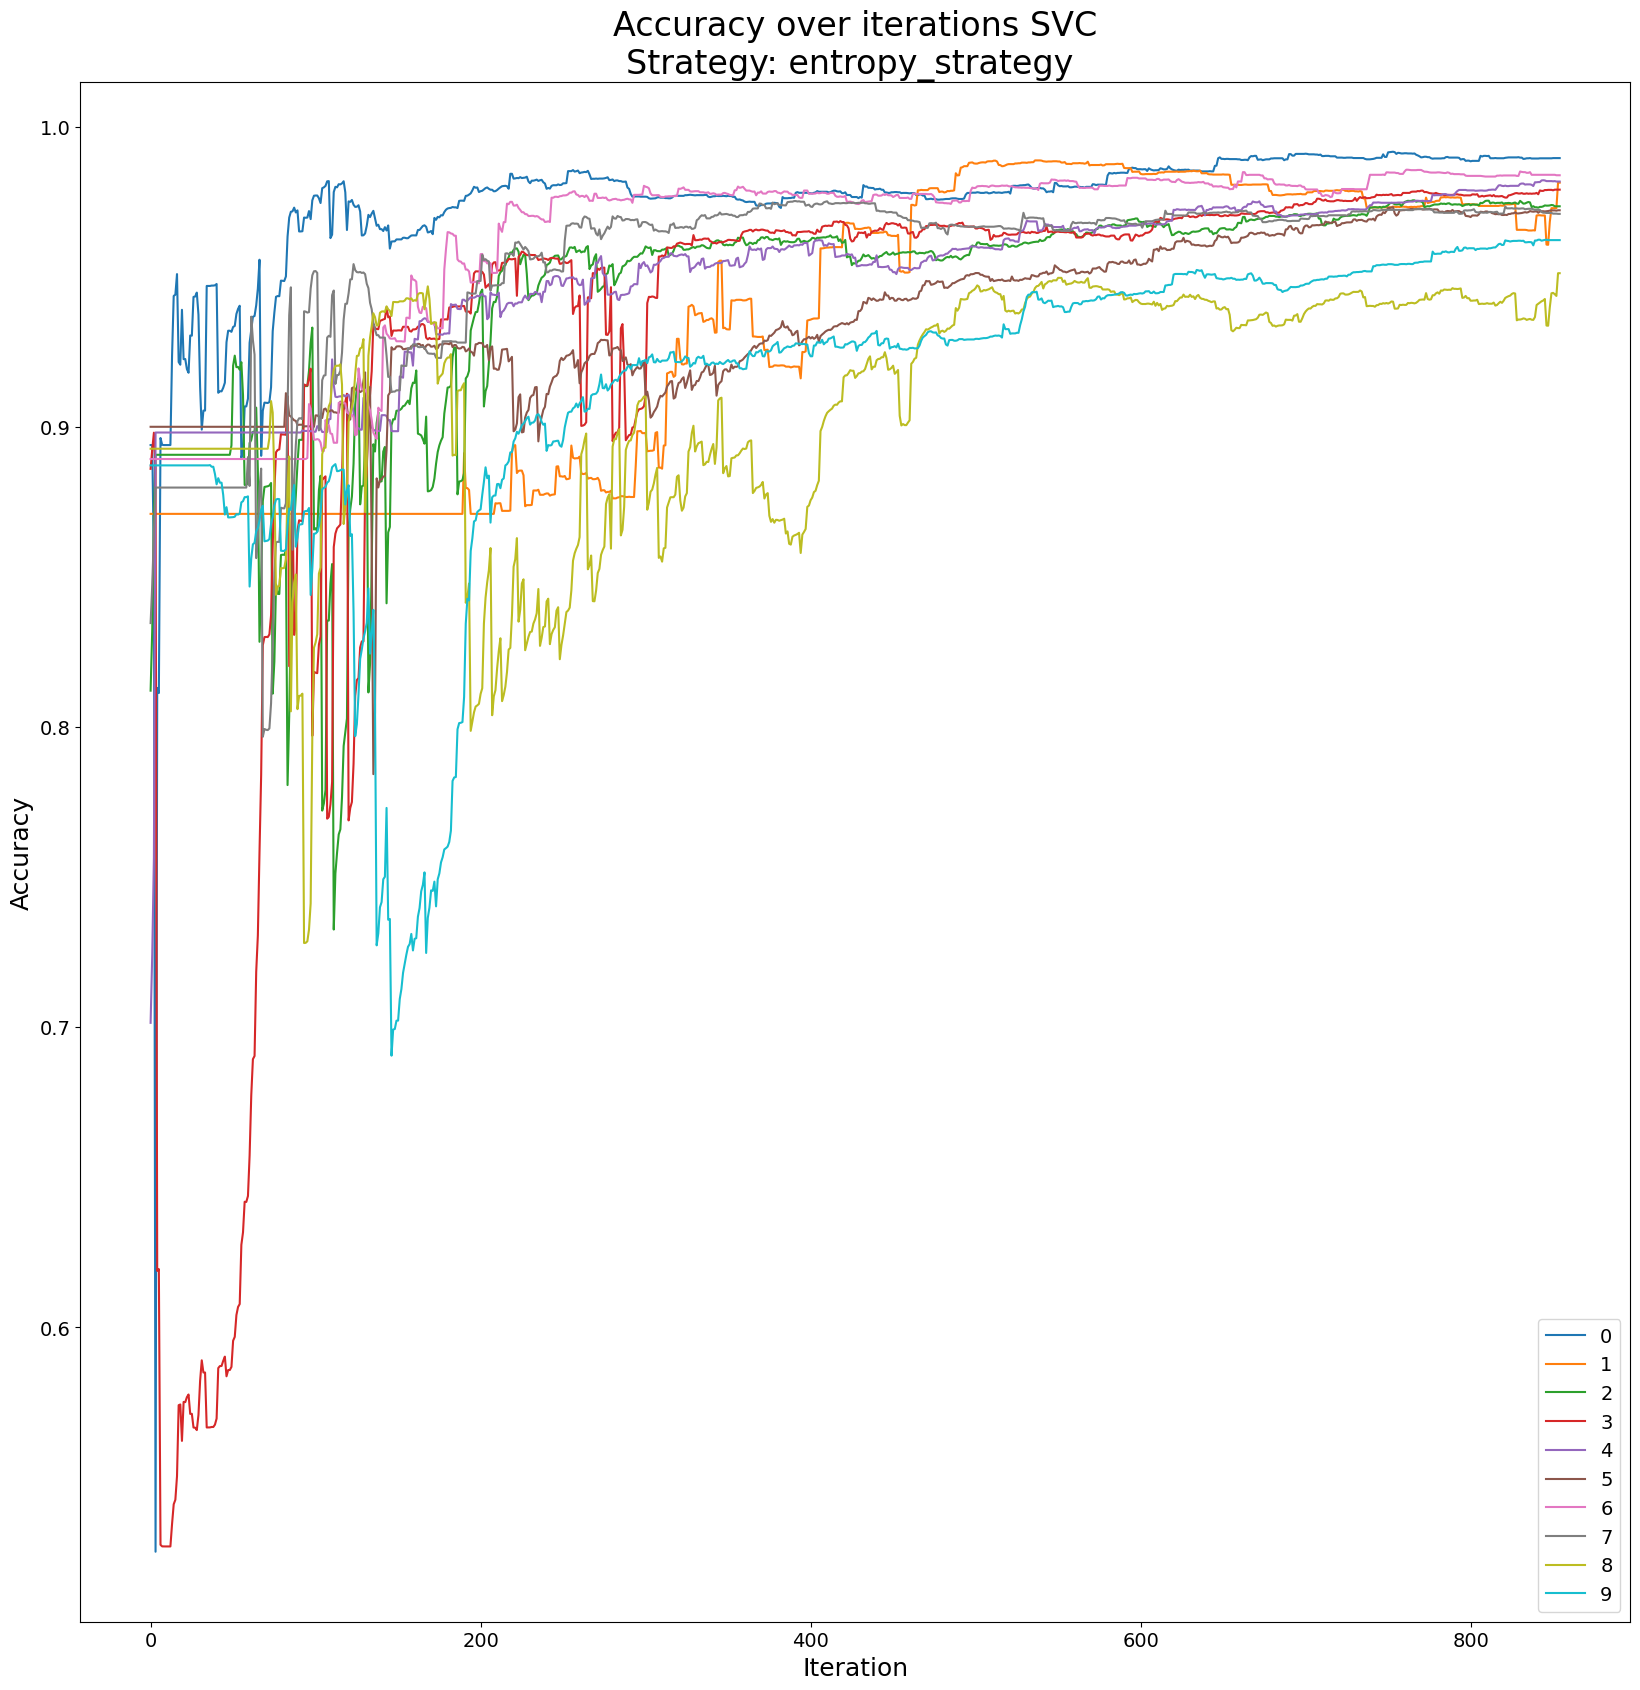

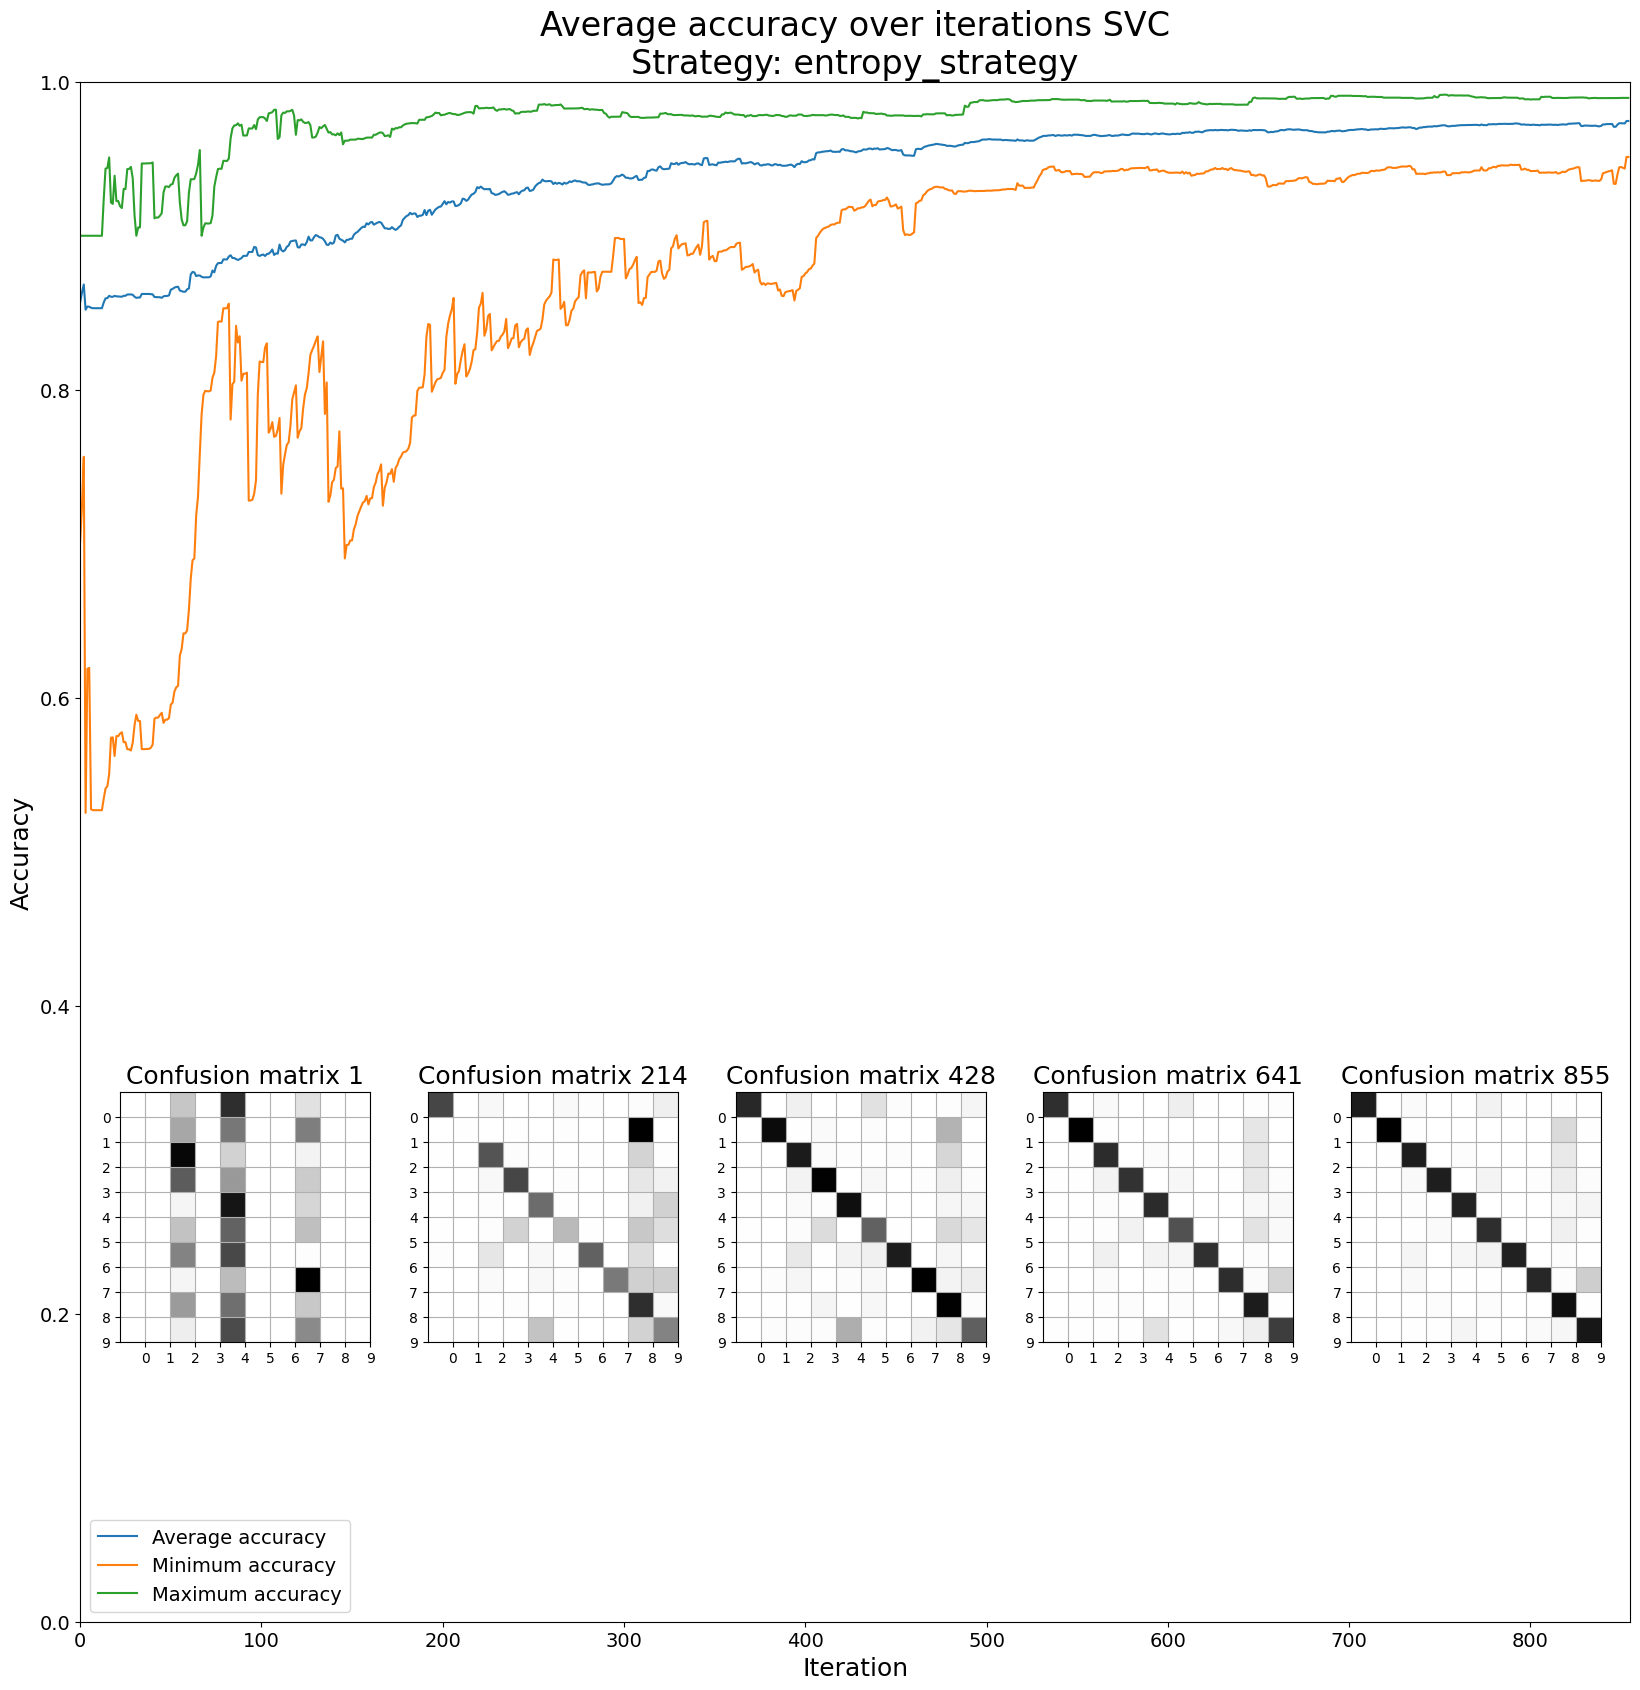

/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:75: RuntimeWarning: invalid value encountered in divide
  self.calculable_metrics["precision"].append(tp / (tp + fp))
/var/folders/3x/5pyxnlsx7

Final accuracy: [0.98576232 0.9764324  0.96322039 0.95176345 0.96573254 0.95631858
 0.97670818 0.9747169  0.9607986  0.95321679]
Final confusion matrix: [[1232    1   12    8    0   27   56    2    4    1]
 [   0 1519    2   10    0   41    1    6   19    2]
 [  14   50 1032   71   19   11  102   40   21   20]
 [  11   17   75 1112    0  105    8   30   59   16]
 [   2   15    7    9  946   19   31    8    7  251]
 [  12   65    5   91    7 1027   35   10    7   14]
 [  14    4    7    4    5   21 1336    1    3    1]
 [  11   35    8    9   10    8    1 1346    4   71]
 [  12   52   40  121    6  109   29   19  950   19]
 [  12   14    4   33   76   30    8   82    7 1154]]
Final iteration: 196
Final accuracy threshold reached: True


/var/folders/3x/5pyxnlsx7s52d1vkmbhc4fj40000gp/T/ipykernel_5178/317600213.py:152: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


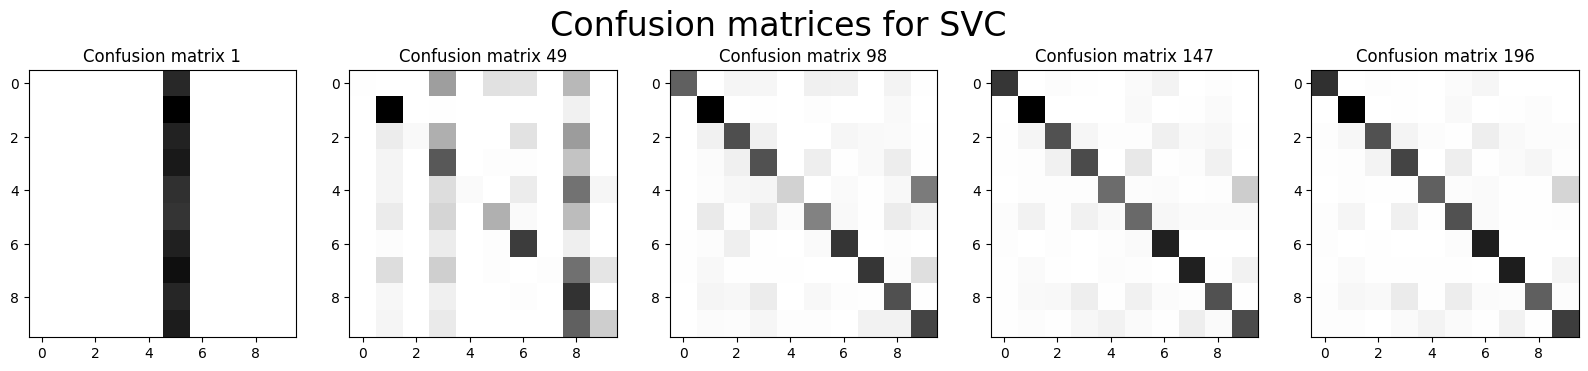

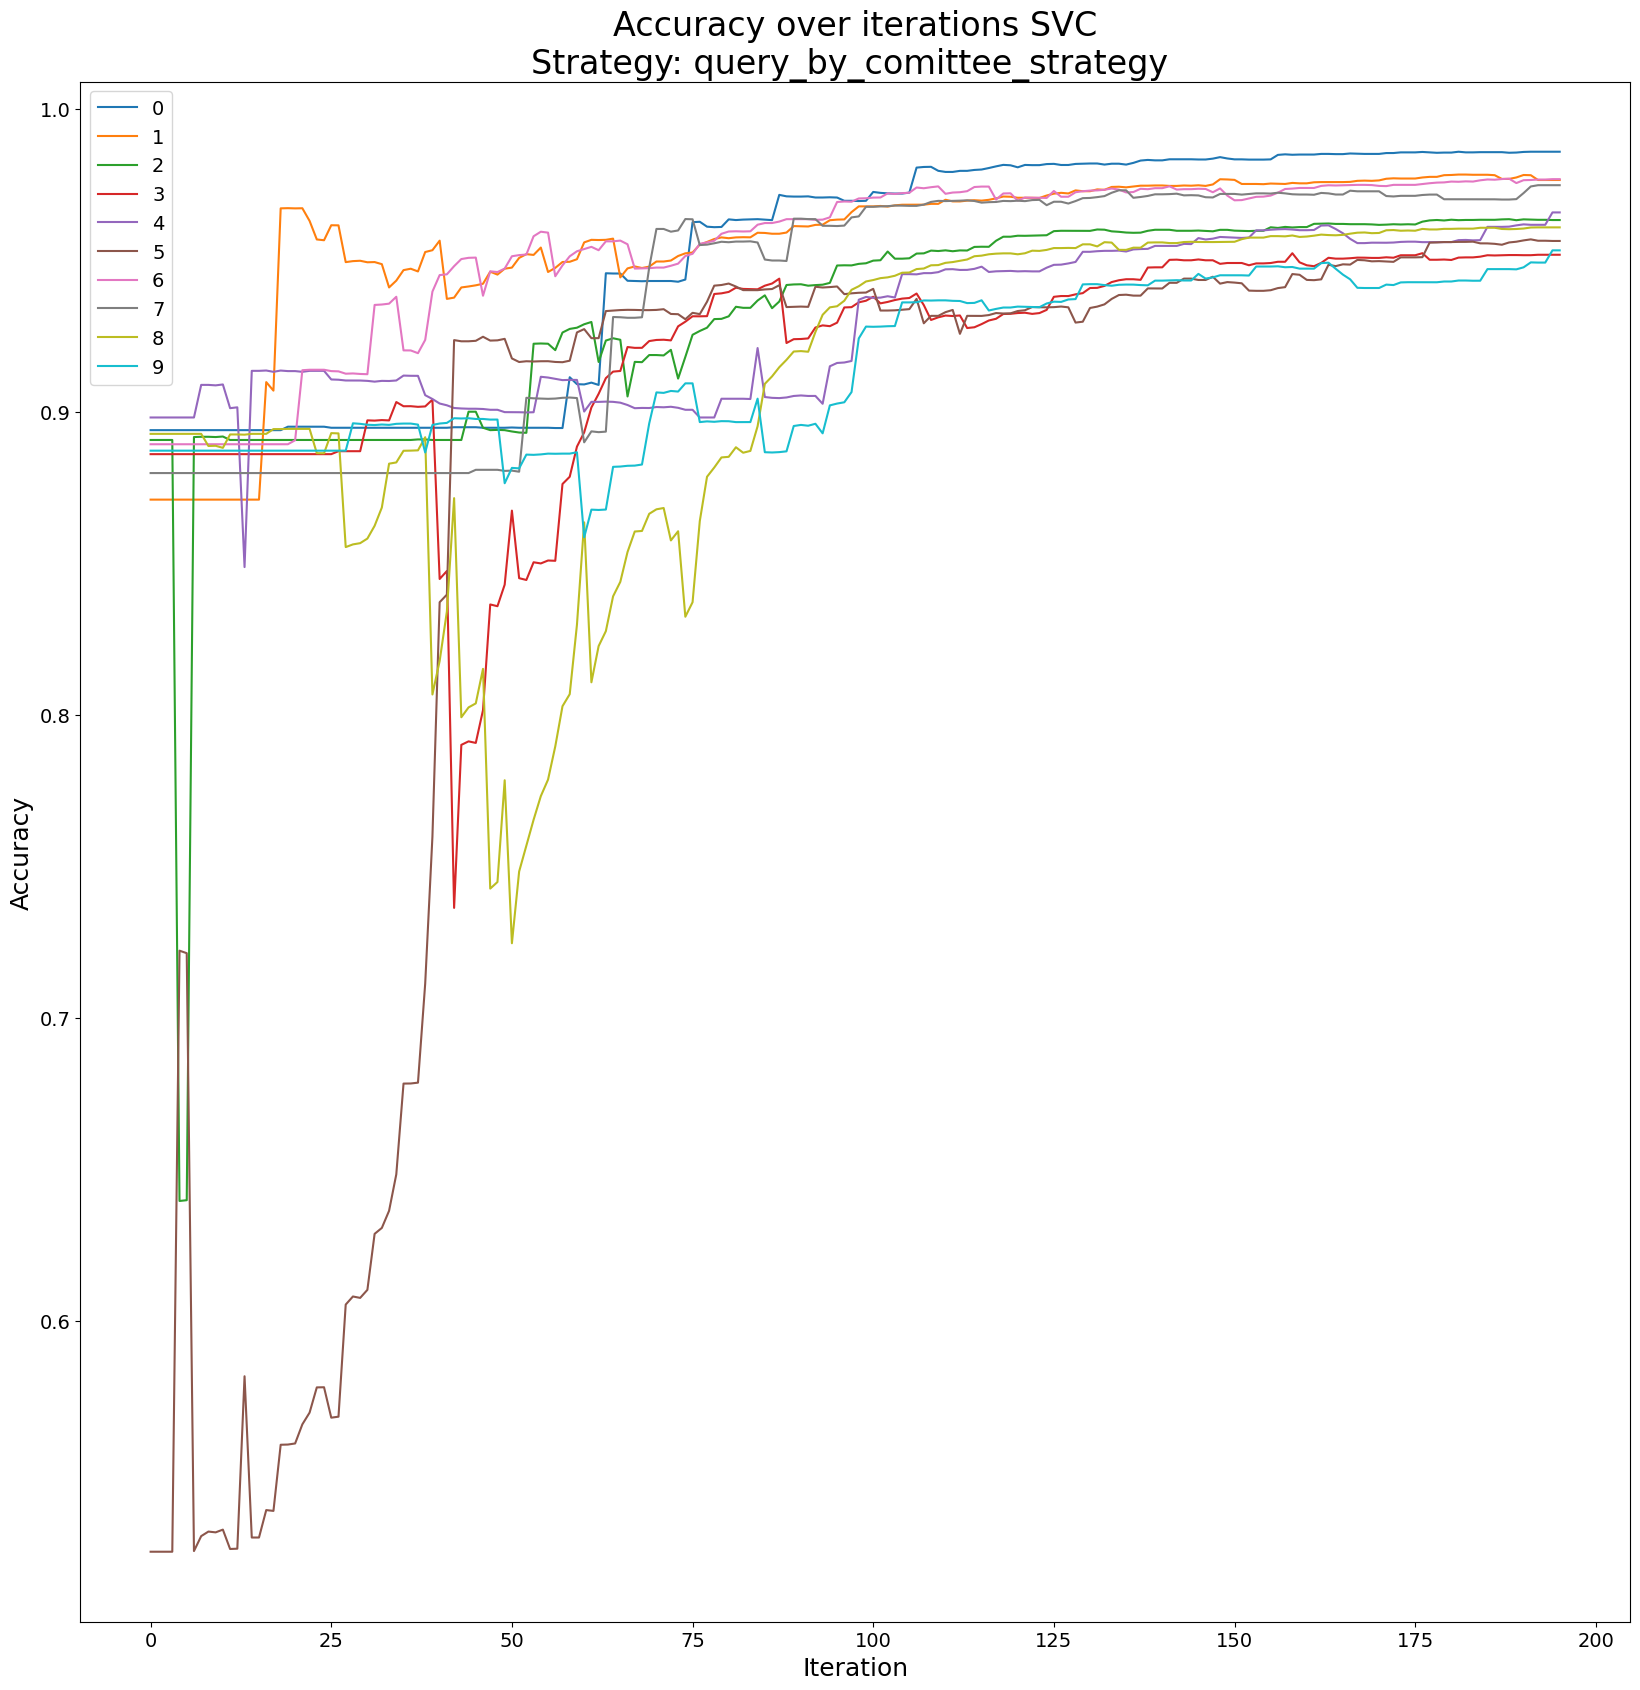

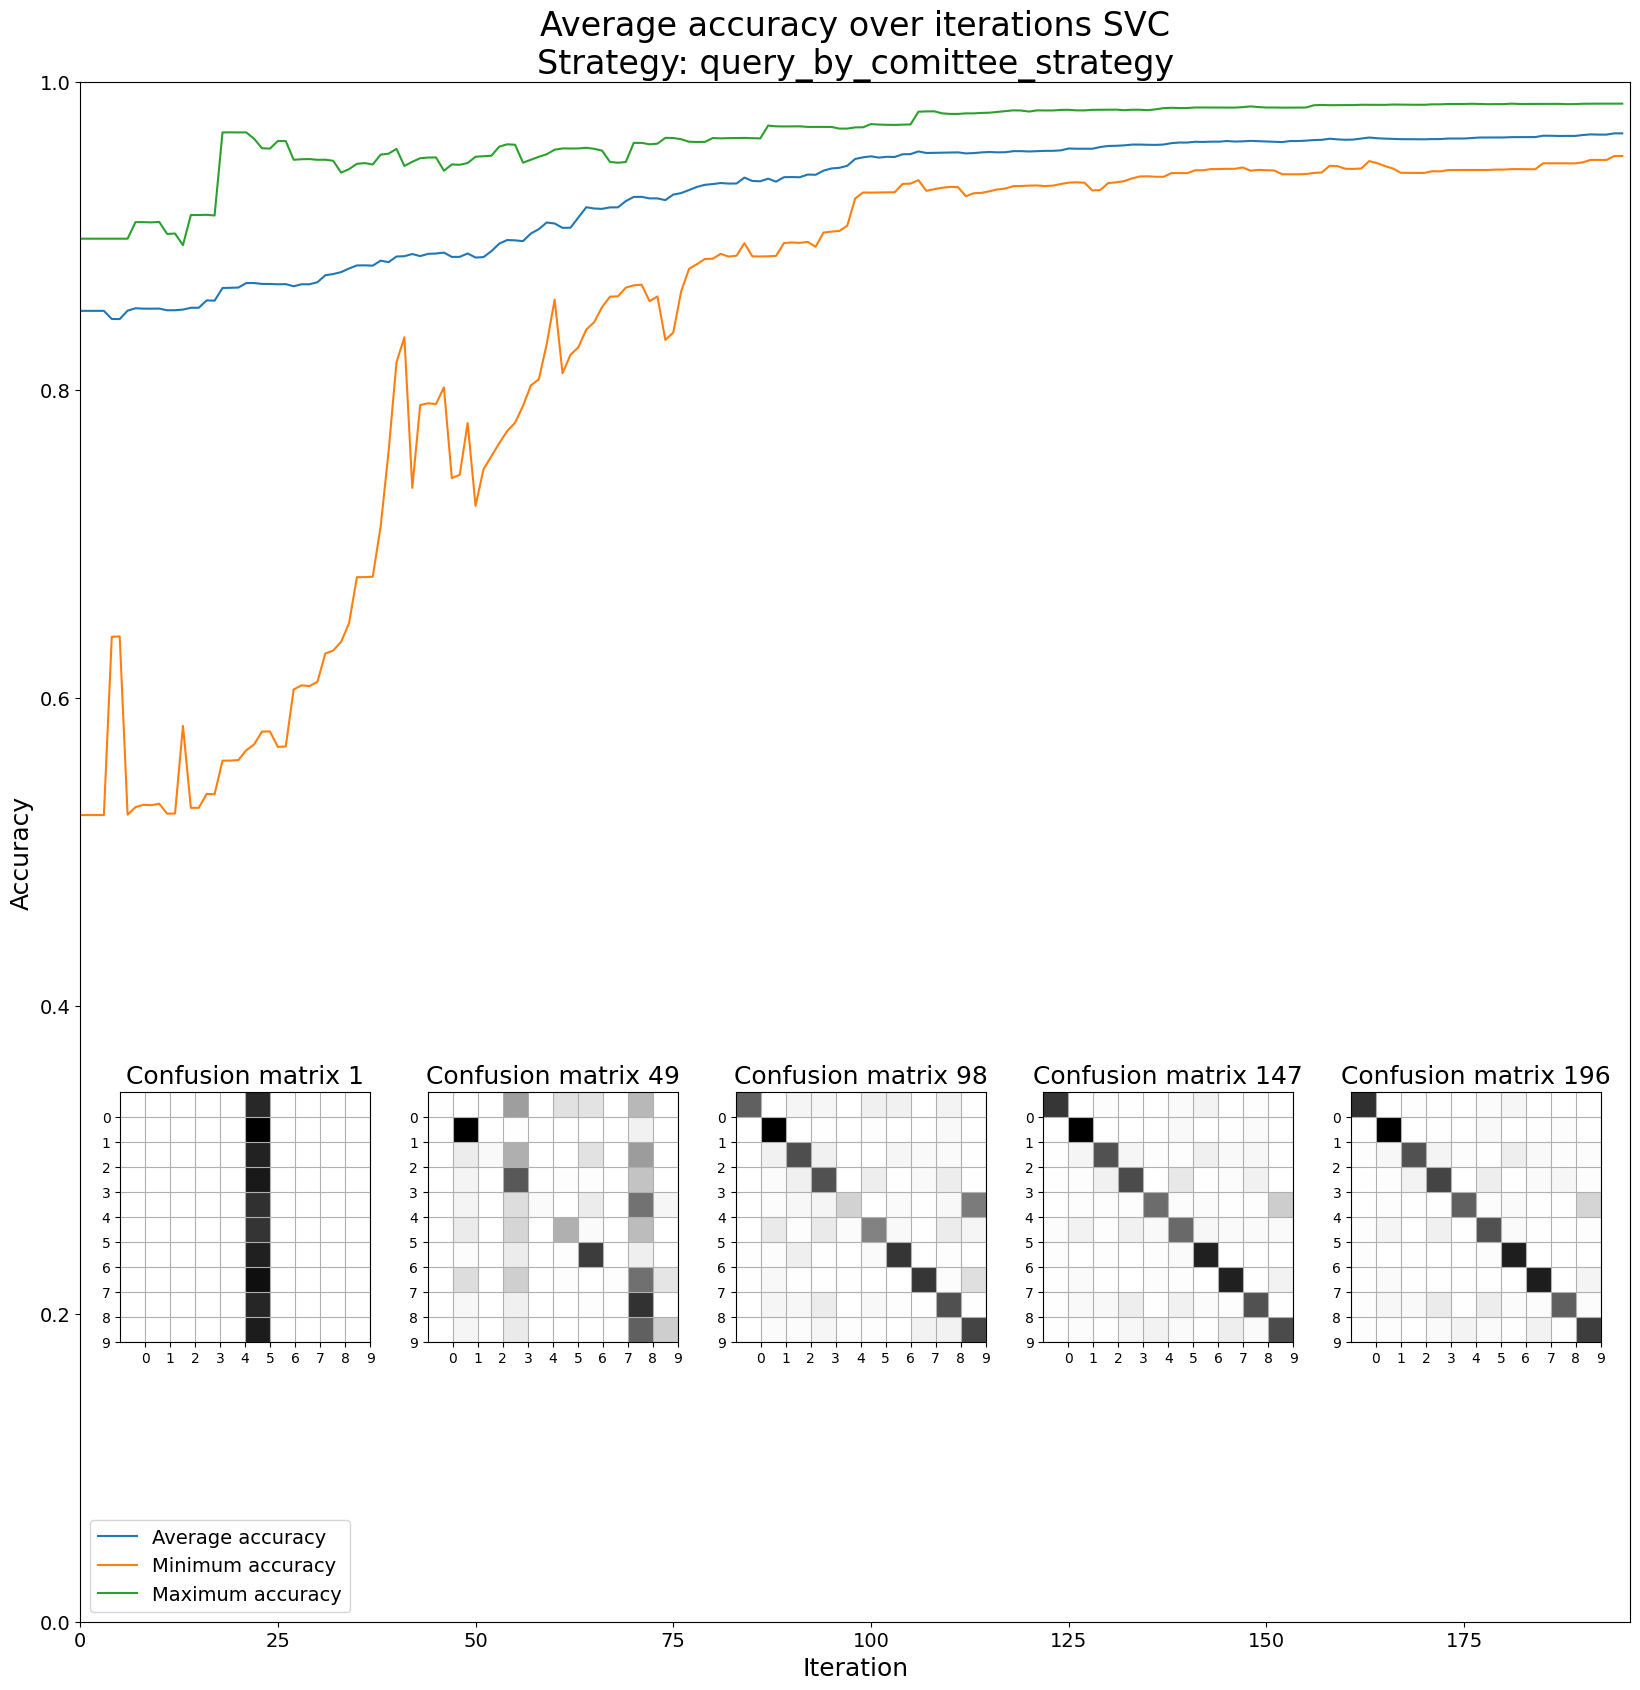

'active_learner = active_model_learning(rf_model, X, y, accuracy_threshold=accuracy_threshold, max_iterations=max_iterations, verbose=verbose)\nactive_learner.run()\nactive_learner.report()\nfigs, axes = active_learner.generate_graphs()\naxes[0].set_title(f"Confusion matrices for random forest")\nfigs[0].savefig("confusion_matrices_rf.png")\n\naxes[1].set_title(f"Accuracy over iterations\nactive learning with random forest and default strategy")\nfigs[1].savefig("active_learning_rf_default.png")\nnp.savez("active_learning_rf_default.npz", confusion_matrices=active_learner.confusion_matrices, calculable_metrics=active_learner.calculable_metrics, allow_pickle=True)\n\n\n'

In [12]:

accuracy_threshold = 0.95
max_iterations = 1000
verbose = False
strategies = [default_strategy, random_strategy, uncertainty_strategy, entropy_strategy, query_by_comittee_strategy]
#strategies = [default_strategy]
models = [ RandomForestClassifier(n_estimators=100, random_state=42), SVC(probability=True, random_state=42)]
#models = [ SVC(probability=True, random_state=42)]
active_learner = []

for model in models:
    for strategy in strategies:
        active_learner.append(active_model_learning(model, accuracy_threshold=accuracy_threshold, max_iterations=max_iterations, verbose=verbose, strategy_function=strategy, test_split=0.2, random_state=42))
        active_learner[-1].fit(X, y)
        active_learner[-1].report()
        figs, axes = active_learner[-1].generate_graphs()
        figs[0].suptitle(f"Confusion matrices for {model.__class__.__name__}\\n{'default strategy' if strategy==None else strategy.__name__} strategy")
        figs[0].savefig(report_image_path +f"confusion_matrices_{model.__class__.__name__}_{'default strategy' if strategy==None else strategy.__name__}.png")
        axes[1].set_title(f"Accuracy over iterations\nactive learning with {model.__class__.__name__} and {'default strategy' if strategy==None else strategy.__name__} strategy")
        figs[1].savefig(report_image_path +f"active_learning_{model.__class__.__name__}_{'default strategy' if strategy==None else strategy.__name__}.png")
        figs[2].savefig(report_image_path +f"active_learning_{model.__class__.__name__}_{'default strategy' if strategy==None else strategy.__name__}_average.png")
        np.savez(f"active_learning_{model.__class__.__name__}_{'default strategy' if strategy==None else strategy.__name__}.npz", confusion_matrices=active_learner[-1].confusion_matrices, calculable_metrics=active_learner[-1].calculable_metrics, allow_pickle=True)

"""active_learner = active_model_learning(rf_model, X, y, accuracy_threshold=accuracy_threshold, max_iterations=max_iterations, verbose=verbose)
active_learner.run()
active_learner.report()
figs, axes = active_learner.generate_graphs()
axes[0].set_title(f"Confusion matrices for random forest")
figs[0].savefig("confusion_matrices_rf.png")

axes[1].set_title(f"Accuracy over iterations\nactive learning with random forest and default strategy")
figs[1].savefig("active_learning_rf_default.png")
np.savez("active_learning_rf_default.npz", confusion_matrices=active_learner.confusion_matrices, calculable_metrics=active_learner.calculable_metrics, allow_pickle=True)


"""
